# Модели для прогнозирования риска сердечного приступа

## Введение

### Описание и цель проекта
Цель проекта - подготовить модель машинного обучения для предсказания высокого или низкого риска сердечного приступа (задача бинарной классификации). Полученная в результате модель будет использована при разработке вэб приложения с использованием фреймворка FastAPI.  

### Основные этапы исследования
1. Обзор исходных данных
2. Предварительная обработка и исследовательский анализ данных
   * Преобразование типов данных
   * Поиск дубликатов
   * Статистический анализ всех признаков
   * При необходимости обработка аномальных значений
4. Корреляционный анализ признаков
5. Подготовка данных и выбор оптимальной модели
6. Подготовка предсказаний
7. Сохранение оптимальной модели и инструментов предварительной обработки данных для дальнейшего использования в приложении

### Описание данных
Входящие признаки:
* `age` - возраст;
* `cholesterol`- уровень холестерина;
* `heart_rate` - сердечный ритм;
* `diabetes` - диабет;
* `family_history` - наличие сердечных заболеваний в истории болезни семьи;
* `smoking` - курение;
* `obesity` - ожирение;
* `'alcohol_consumption` - потребление алкоголя;
* `exercise_hours_per_week` - физические упражнения (ч/неделя);
* `diet` - диета;
* `previous_heart_problems` - раннее наличие проблем с сердцем;
* `medication_use` - прием препаратов;
* `stress_level` - уровень стресса;
* `sedentary_hours_per_day` - сидячее положение (ч/день);
* `income` - уровень дохода;
* `bmi` - индекс массы тела;
* `triglycerides` - триглицериды; 
* `physical_activity_days_per_week` - физическая активность (д/неделя);
* `sleep_hours_per_day` - сон (ч/день);
* `blood_sugar` - уровень сахара в крови; 
* `ck-mb` - креатинкиназа КК  
* `troponin` - тропонин  
* `gender` - пол;
* `systolic_blood_pressure` - систолическое артериальное давление;
* `diastolic_blood_pressure` - диастолическое артериальное давление;
* `id` - идентификатор.

Целевые признаки:
* `heart_attack_risk_(binary)` - риск сердечного приступа: `0` - низкий, `1` - высокий.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import catboost
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
import scipy.stats as st
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from catboost.utils import Pool, select_threshold
from sklearn.metrics import (accuracy_score, 
                            precision_score, 
                            recall_score,
                            roc_auc_score,
                            f1_score,
                            precision_recall_curve,
                            confusion_matrix)
from sklearn.inspection import permutation_importance
import time
import pickle

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
columns_to_russian = {
    'age' : ['Возраст', ''],
    'cholesterol' : ['Холестерин', ''],
    'heart_rate' : ['Сердечный ритм', ''],
    'diabetes' : ['Диабет', ''],
    'family_history' : ['Семейный история болезни', ''],
    'smoking' : ['Курение', ''],
    'obesity' : ['Ожирение', ''],
    'alcohol_consumption' : ['Потребление алкоголя', ''],
    'exercise_hours_per_week' : ['Занятия спортом (ч/неделю)', ''],
    'diet' : ['Диета', ''],
    'previous_heart_problems' : ['Ранние проблемы с сердцем', ''],
    'medication_use' : ['Прием препаратов', ''],
    'stress_level' : ['Уровень стресса', ''],
    'sedentary_hours_per_day' : ['Сидячие ч/день', ''],
    'income' : ['Доход', ''],
    'bmi' : ['ИМТ', ''],
    'triglycerides' : ['Триглицериды', ''],
    'physical_activity_days_per_week' : ['Физическая активность (д/неделю)', ''],
    'sleep_hours_per_day' : ['Сон (ч/день)', ''],
    'heart_attack_risk_(binary)' : ['Высокий риск сердечного приступа', ''],
    'blood_sugar' : ['Сахар в крови', ''],
    'ck-mb' : ['Креатинкиназа КК', ''],
    'troponin' : ['Тропонин', ''],
    'gender' : ['Пол', ''],
    'systolic_blood_pressure' : ['Систолическое давление', ''],
    'diastolic_blood_pressure' : ['Диастолическое давление', '']
}

In [4]:
def df_overview(df):
    print('Первые пять строк датафрейма')
    display(df.head())
    print('\n' + 'Ключевая информация о датафрейме')
    df.info()
    print('\n' + 'Количество пропущенных значений по столбцам')
    display(df.isna().sum())
    print('\n' + 'Описательные статистики для количественных данных')
    display(df.loc[:, df.columns != 'id'].describe())
    print('\n' + 'Гистограммы для количественных данных')
    try:
        df.loc[:, df.columns != 'id'].hist(figsize=(15, 3.33 * math.ceil(len(df.select_dtypes(include=np.number).columns.tolist()) / 3))); 
    except:
        print('Нет количественных данных')

In [5]:
def initial_data_analisys_numeric(df, column_name, split_column = 'None', selected_bins = 150):
    
    print(columns_to_russian[column_name][0] + '(' + columns_to_russian[column_name][1] + ') - описательные статистики' + '\n')
    display(df[column_name].describe())

    if split_column != 'None':
        for category in df[split_column].unique():
            print('\n' + 'Категория в столбце ', split_column, category)
            display(df[df[split_column] == category][column_name].describe())

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,4))
    if split_column == 'None':
        sns.histplot(data = df, x = column_name, ax=ax1, bins = selected_bins)
        sns.boxplot(data = df, x = column_name, orient='h', ax=ax2)
    else:
        sns.histplot(data = df, x = column_name, hue = split_column, bins = selected_bins, ax=ax1)
        sns.boxplot(data = df, x = column_name, y = split_column, orient='h', ax=ax2)
    ax1.set_ylabel('кол-во наблюдений', fontsize=10)
    ax1.set_xlabel(columns_to_russian[column_name][1], fontsize=10)
    ax2.set_ylabel(columns_to_russian[column_name][0], fontsize=10)
    ax2.set_xlabel(columns_to_russian[column_name][1], fontsize=10)
    fig.suptitle(columns_to_russian[column_name][0] + '\n', fontsize = 14)
    plt.show();

In [6]:
def initial_data_analisys_category(df, column_name, target_column = 'None', target_value = 'None'):
    print(columns_to_russian[column_name][0] + ' - количество значений' + '\n')
    display(df.groupby(column_name)[column_name].count().sort_values(ascending = False))

    total_count = df[column_name].count()
    count = df.groupby(column_name)[column_name].count().sort_values(ascending = False)
    share = count.apply(lambda x: 100 * x / total_count)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,4), gridspec_kw={'wspace': 0.3})
    sns.barplot(x = count.values, y = count.index, orient='h', ax = ax1)
    sns.barplot(x = share.values, y = share.index, orient='h', ax = ax2)
    ax1.set_xlabel('кол-во наблюдений', fontsize=10)
    ax1.set_ylabel('')
    ax2.set_xlabel('доля наблюдений, %', fontsize=10)
    ax2.set_ylabel('')
    fig.suptitle(columns_to_russian[column_name][0] + '\n', fontsize = 14)
    plt.show();

    if target_column != 'None':
        target_count = df.groupby(column_name)[target_column].value_counts(normalize=True)
        target_count = target_count.loc[target_count.index.get_level_values(1) == target_value].sort_values(ascending = False).to_frame(name='vals').reset_index()
        fig_2, (ax3, ax4) = plt.subplots(1,2, figsize=(20,4), gridspec_kw={'wspace': 0.3})
        sns.barplot(data = target_count, x = 'vals', y = column_name, orient='h', ax = ax3)
        ax3.set_title(columns_to_russian[column_name][0] + '\n' + 'Значение признака "' + \
                      columns_to_russian[target_column][0] + '" - ' + str(target_value), fontsize = 12)
        ax3.set_xlabel('доля наблюдений от общего кол-ва в категории', fontsize=10)
        ax3.set_ylabel('')
        ax4.axis('off')
        plt.show();

In [7]:
def scatter_plot(df, x, y, hue):
    plt.figure(figsize=(7,7))
    sns.scatterplot(x=x, y=y, data=df, hue=hue)
    plt.title('Диаграмма рассеяния' + "\n", fontsize=12)
    plt.xlabel(columns_to_russian[x][0], fontsize=10)
    plt.ylabel(columns_to_russian[y][0], fontsize=10)
    plt.legend(title = columns_to_russian[hue][0])
    plt.show();

In [8]:
def check_importance(search_result, X_test, y_test, scoring):
    X_test_processed = search_result.best_estimator_.named_steps['preprocessor'].transform(X_test)

    result = permutation_importance(
        search_result.best_estimator_.named_steps['models'], 
        X_test_processed, 
        y_test, 
        n_repeats=10, 
        random_state=RANDOM_STATE,
        scoring = 'recall'
    )

    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=search_result.best_estimator_.named_steps['preprocessor'].get_feature_names_out()[sorted_importances_idx],
    )

    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title('Permutation Importance (тестовая выборка)')
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel('Изменение метрики');

In [9]:
def predictions_with_threshold(y_proba, threshold):
    prerdict = np.vectorize(lambda x: 1 if x >= threshold else 0)
    predictions = prerdict(y_proba)
    return predictions

In [10]:
def view_metrics_for_threshold(y_proba, threshold, y_test):
    predictions = predictions_with_threshold(y_proba, threshold)
    sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = 'd', cmap = 'Blues_r')
    plt.title(f'Матрица ошибок для порога классификации {threshold}' + "\n", fontsize=12)
    plt.xlabel('Предсказание', fontsize=10)
    plt.ylabel('Реальное значение', fontsize=10)
    plt.show()
    print('accuracy =', accuracy_score(y_test, predictions))
    print('precision =', precision_score(y_test, predictions))
    print('recall =', recall_score(y_test, predictions))

# Данные

## Импорт

In [11]:
try:
    df_main = pd.read_csv('heart_train.csv')
except:
    print('Нет такого файла')

try:
    df_test = pd.read_csv('heart_test.csv')
except:
    print('Нет такого файла')

In [12]:
df_main.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [13]:
df_test.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


#### С данными все хорошо, осталалось разобраться с наименованием первого столбца

In [14]:
df_main = df_main.drop('Unnamed: 0', axis = 1)
df_main.columns = df_main.columns.str.lower().str.replace(' ', '_')
df_test = df_test.drop('Unnamed: 0', axis = 1)
df_test.columns = df_test.columns.str.lower().str.replace(' ', '_')

## Основные сведения по данным

Первые пять строк датафрейма


,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047



Ключевая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8685 non-null   float64
 1   cholesterol                      8685 non-null   float64
 2   heart_rate                       8685 non-null   float64
 3   diabetes                         8442 non-null   float64
 4   family_history                   8442 non-null   float64
 5   smoking                          8442 non-null   float64
 6   obesity                          8442 non-null   float64
 7   alcohol_consumption              8442 non-null   float64
 8   exercise_hours_per_week          8685 non-null   float64
 9   diet                             8685 non-null   int64  
 10  previous_heart_problems          8442 non-null   float64
 11  medication_use                   8442 non-null  

age                                  0
cholesterol                          0
heart_rate                           0
diabetes                           243
family_history                     243
smoking                            243
obesity                            243
alcohol_consumption                243
exercise_hours_per_week              0
diet                                 0
previous_heart_problems            243
medication_use                     243
stress_level                       243
sedentary_hours_per_day              0
income                               0
bmi                                  0
triglycerides                        0
physical_activity_days_per_week    243
sleep_hours_per_day                  0
heart_attack_risk_(binary)           0
blood_sugar                          0
ck-mb                                0
troponin                             0
gender                               0
systolic_blood_pressure              0
diastolic_blood_pressure 


Описательные статистики для количественных данных


,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,systolic_blood_pressure,diastolic_blood_pressure
count,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,...,8685.000000,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,...,0.496774,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.450295,0.497634
std,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,...,0.282561,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.170184,0.171830
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,...,0.254190,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.303226,0.348837
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,...,0.494774,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,0.445161,0.500000
75%,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,...,0.736974,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,0.600000,0.651163
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,...,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Гистограммы для количественных данных


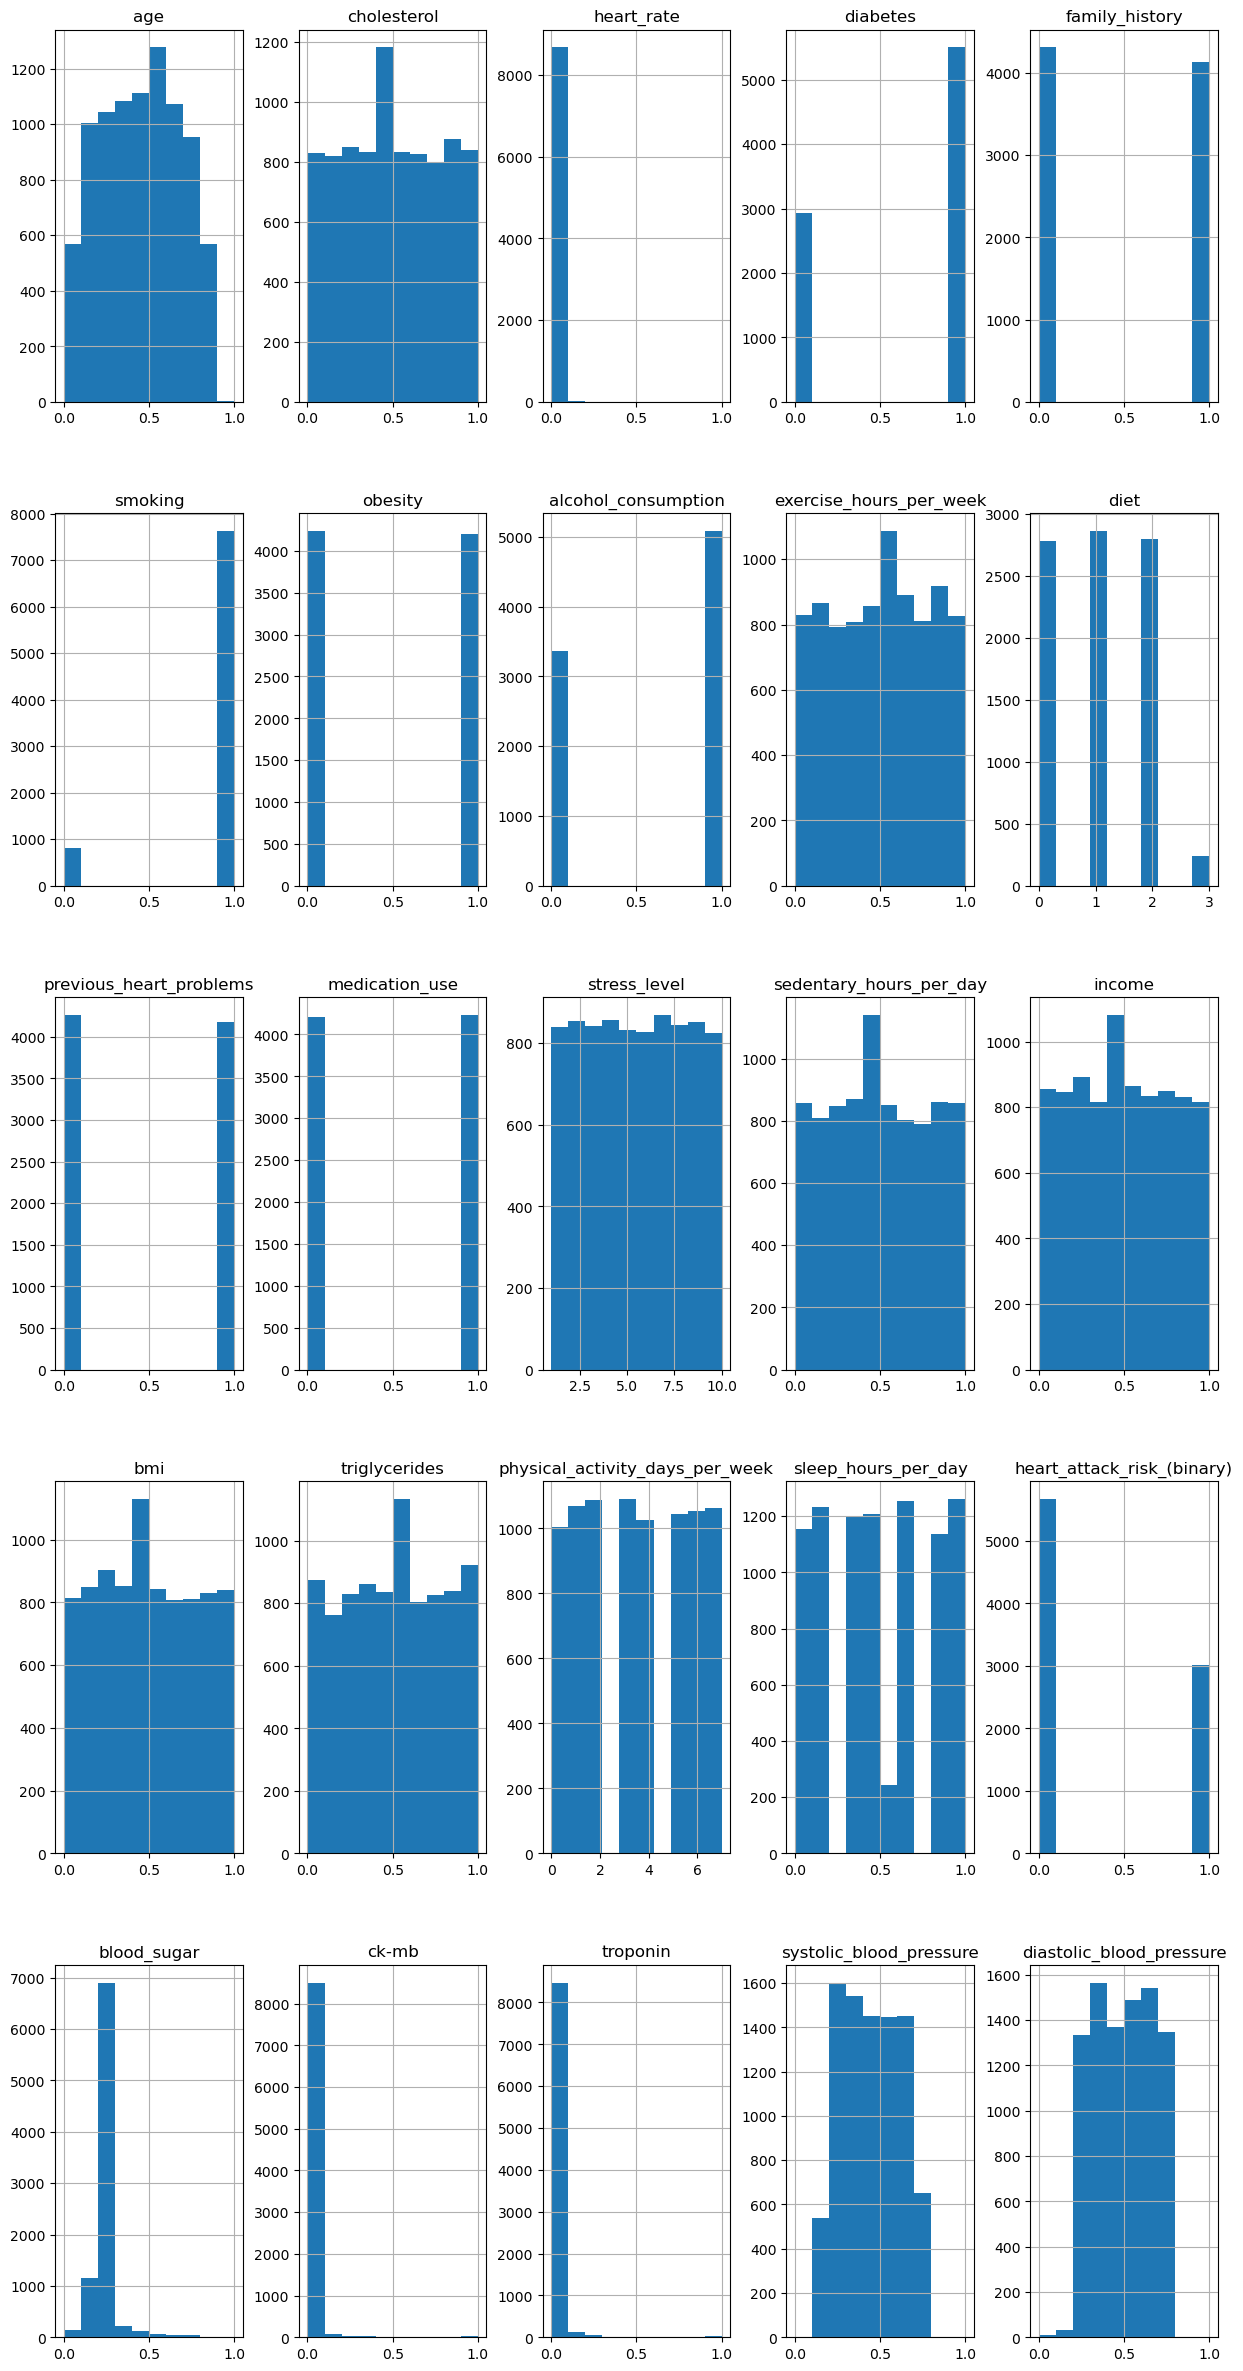

In [15]:
df_overview(df_main)

Первые пять строк датафрейма


,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825



Ключевая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              966 non-null    float64
 1   cholesterol                      966 non-null    float64
 2   heart_rate                       966 non-null    float64
 3   diabetes                         935 non-null    float64
 4   family_history                   935 non-null    float64
 5   smoking                          935 non-null    float64
 6   obesity                          935 non-null    float64
 7   alcohol_consumption              935 non-null    float64
 8   exercise_hours_per_week          966 non-null    float64
 9   diet                             966 non-null    int64  
 10  previous_heart_problems          935 non-null    float64
 11  medication_use                   935 non-null    f

age                                 0
cholesterol                         0
heart_rate                          0
diabetes                           31
family_history                     31
smoking                            31
obesity                            31
alcohol_consumption                31
exercise_hours_per_week             0
diet                                0
previous_heart_problems            31
medication_use                     31
stress_level                       31
sedentary_hours_per_day             0
income                              0
bmi                                 0
triglycerides                       0
physical_activity_days_per_week    31
sleep_hours_per_day                 0
blood_sugar                         0
ck-mb                               0
troponin                            0
gender                              0
systolic_blood_pressure             0
diastolic_blood_pressure            0
id                                  0
dtype: int64


Описательные статистики для количественных данных


,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck-mb,troponin,systolic_blood_pressure,diastolic_blood_pressure
count,966.000000,966.000000,966.000000,935.000000,935.000000,935.000000,935.000000,935.000000,966.000000,966.000000,...,966.000000,966.000000,966.000000,935.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,0.452916,0.488181,0.051644,0.656684,0.481283,0.898396,0.516578,0.583957,0.490706,1.053830,...,0.484408,0.476796,0.486688,3.443850,0.512571,0.224127,0.048855,0.034926,0.447172,0.496822
std,0.231068,0.282039,0.035502,0.475070,0.499917,0.302289,0.499993,0.493165,0.284902,0.884642,...,0.273879,0.291987,0.284534,2.302778,0.322292,0.065270,0.079742,0.053855,0.171837,0.173935
min,0.044944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,...,0.003351,0.002598,0.000000,0.000000,0.000000,0.029644,0.000000,0.000194,0.012903,0.116279
25%,0.247191,0.243750,0.036664,0.000000,0.000000,1.000000,0.000000,0.000000,0.243431,0.000000,...,0.261446,0.217527,0.249675,1.000000,0.166667,0.227018,0.048229,0.036512,0.296774,0.348837
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,1.000000,1.000000,0.502110,1.000000,...,0.492015,0.471185,0.488961,3.000000,0.500000,0.227018,0.048229,0.036512,0.445161,0.488372
75%,0.640449,0.710714,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.734425,2.000000,...,0.705371,0.720503,0.718182,5.000000,0.833333,0.227018,0.048229,0.036512,0.600000,0.639535
max,0.853933,0.996429,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998938,3.000000,...,0.998885,0.999496,0.998701,7.000000,1.000000,0.750988,1.000000,0.970871,0.741935,0.790698



Гистограммы для количественных данных


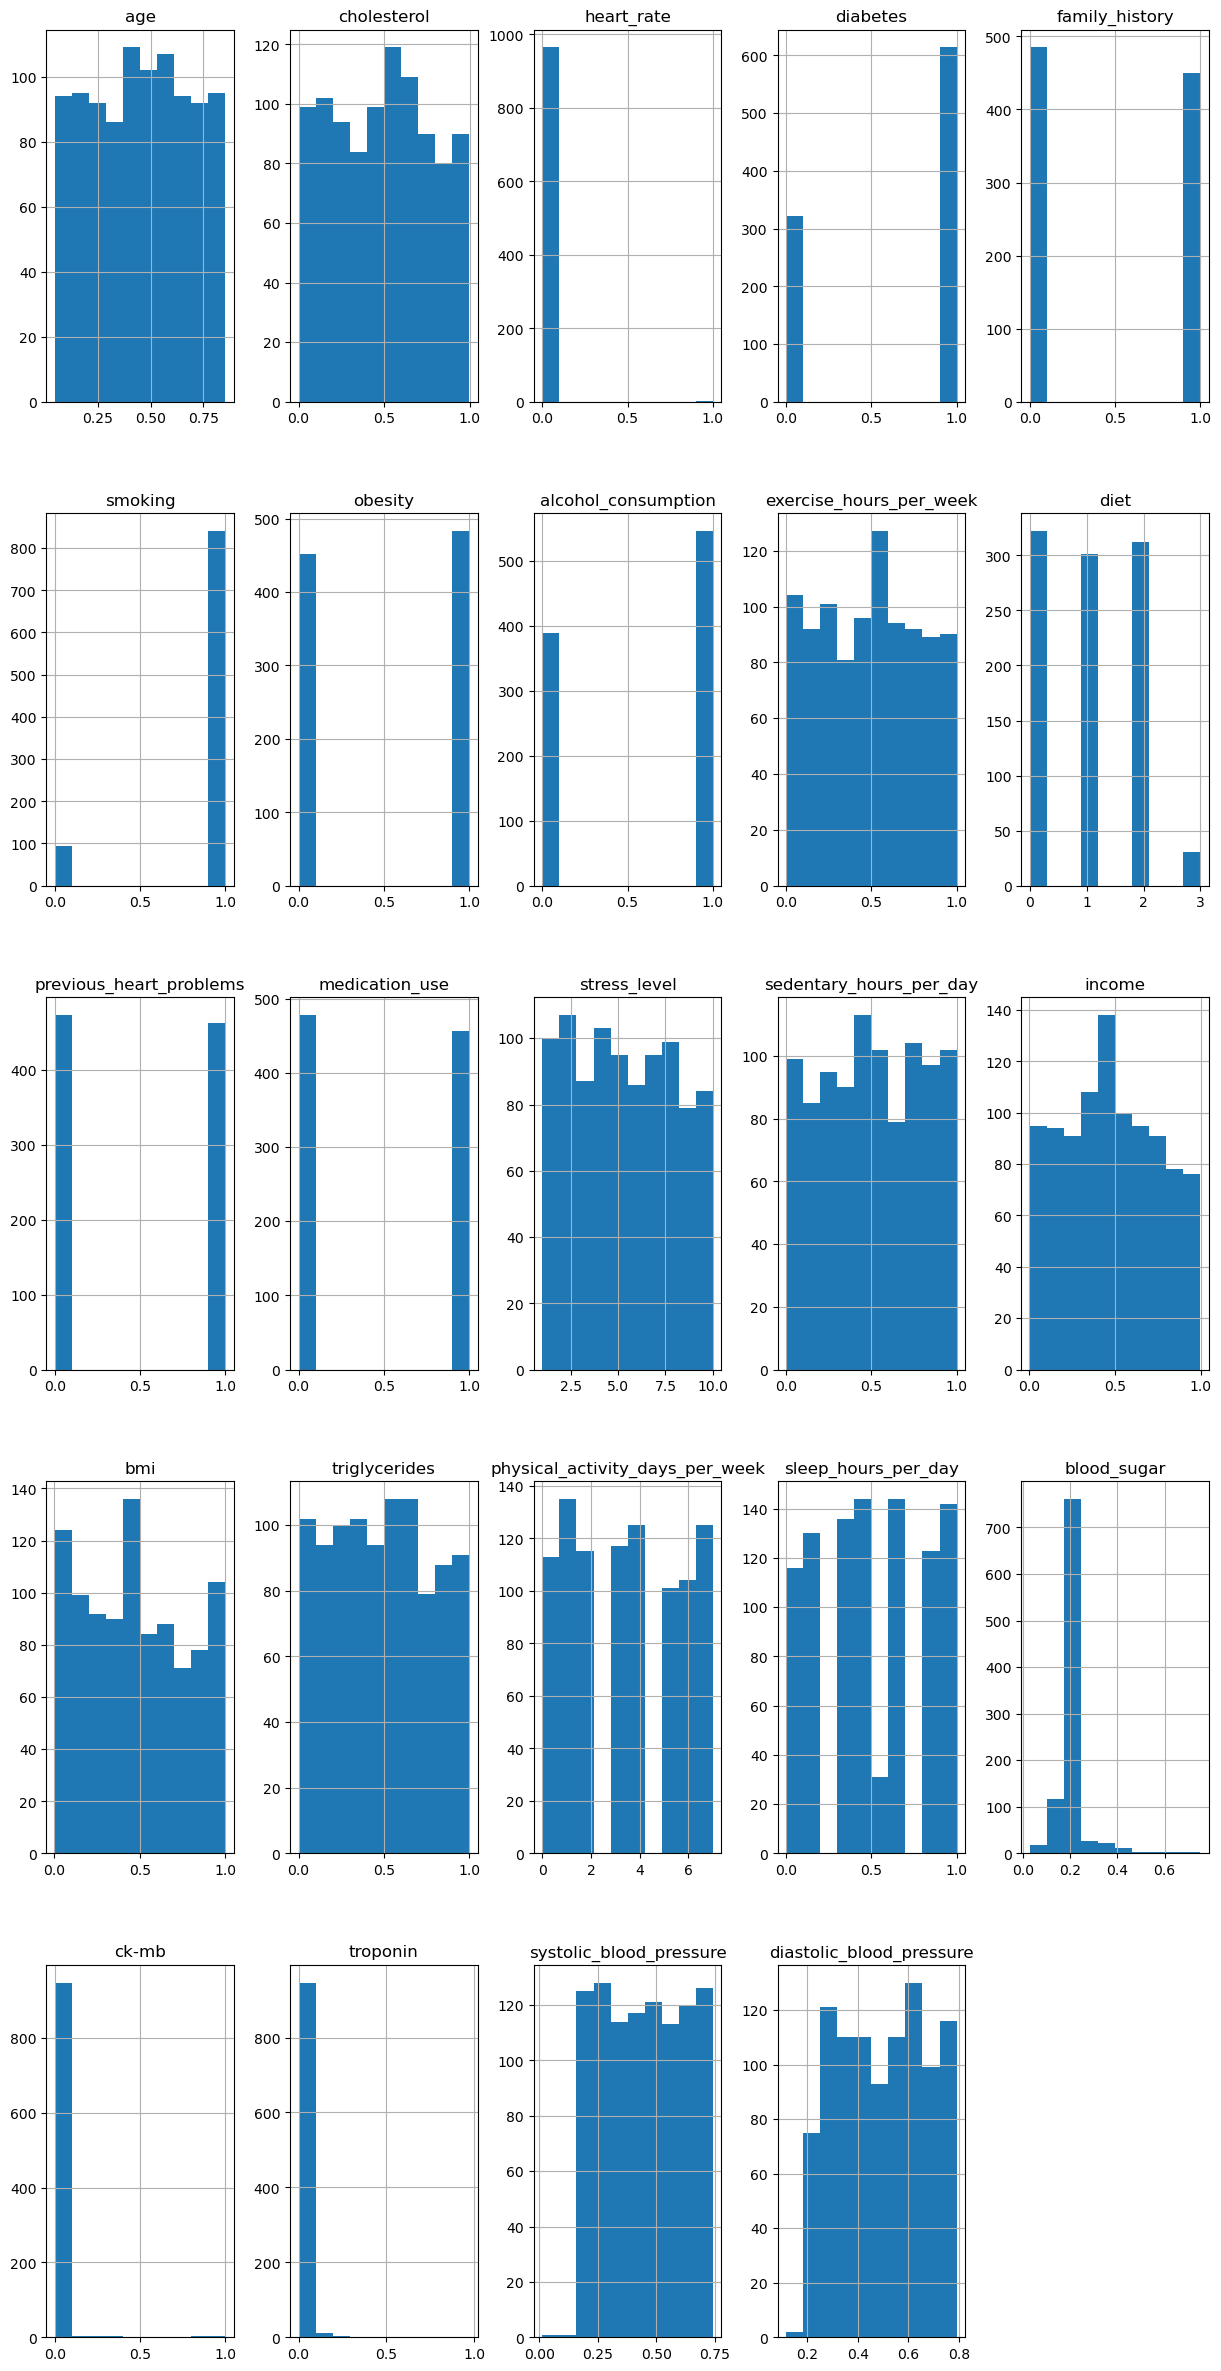

In [16]:
df_overview(df_test)

**Выводы:**
* Данные загружены корректно.
* Как в тренировочных данных, так и в тестовых данных наблюдается пропущенные значения, что необходимо учитывать при моделировании и прогнозировании.
* Некоторые категориальные данные имеют тип `float64`, потребуется преобразование типов данных, которое будет выполнено далее на этапе исследовательского анализа.
* Гистограммы позволяют предположить, что количественные данные уже масштабированы.
* Гистограммы позволяют предположить, что в данных наблюдается единичные аномалии, которые могут быть устранены на этапе исследовательского анализа.

## Исследовательский анализ данных и предварительная обработка

### Удаление пропущенных данных в тренировочной выборке

In [17]:
df_main = df_main.dropna()
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8442 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8442 non-null   float64
 1   cholesterol                      8442 non-null   float64
 2   heart_rate                       8442 non-null   float64
 3   diabetes                         8442 non-null   float64
 4   family_history                   8442 non-null   float64
 5   smoking                          8442 non-null   float64
 6   obesity                          8442 non-null   float64
 7   alcohol_consumption              8442 non-null   float64
 8   exercise_hours_per_week          8442 non-null   float64
 9   diet                             8442 non-null   int64  
 10  previous_heart_problems          8442 non-null   float64
 11  medication_use                   8442 non-null   float64
 12  stress_level        

### Исследовательский анализ

In [18]:
category_columns = []
numeric_columns = []
float_to_int_columns = []

#### Риск сердечного приступа (heart_attack_risk_(binary))

Высокий риск сердечного приступа - количество значений



heart_attack_risk_(binary)
0.0    5429
1.0    3013
Name: heart_attack_risk_(binary), dtype: int64

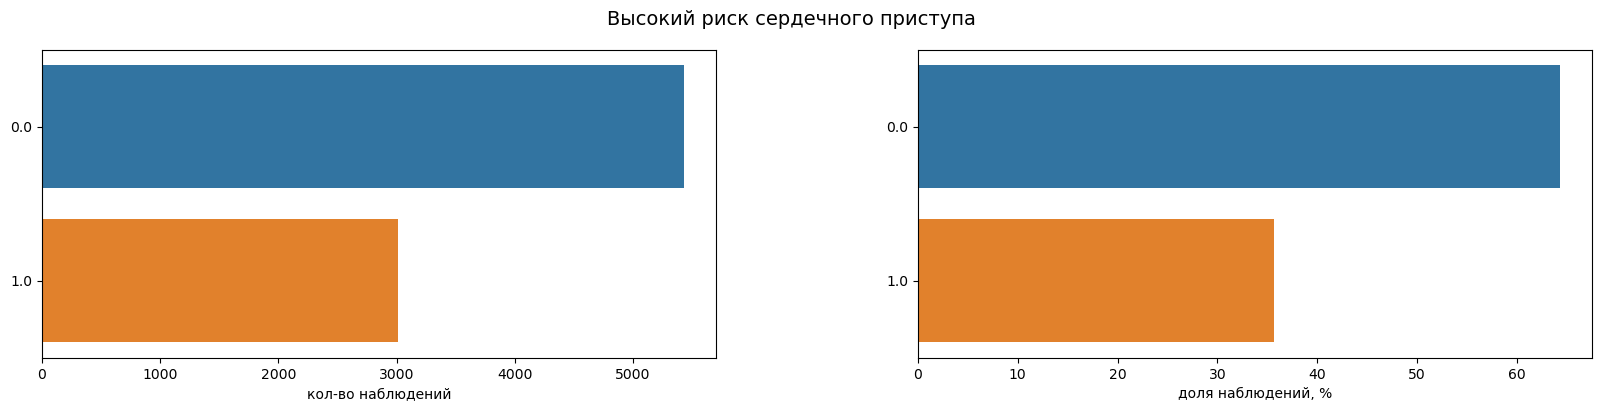

In [19]:
initial_data_analisys_category(df_main, 'heart_attack_risk_(binary)', target_column = 'None', target_value = 'None')

In [20]:
df_main['heart_attack_risk_(binary)'] = df_main['heart_attack_risk_(binary)'].astype('int')

**Вывод:** 36% - наблюдения с высоким риском сердечного приступа, 64% - наблюдения с низким риском сердечного приступа. Дисбаланс классов будем учитывать при моделировании.

#### Возраст (`age`)

**Тренировочная выборка**

Возраст() - описательные статистики



count    8442.000000
mean        0.449008
std         0.232809
min         0.044944
25%         0.247191
50%         0.460674
75%         0.640449
max         0.853933
Name: age, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 0


count    5429.000000
mean        0.447662
std         0.231750
min         0.044944
25%         0.247191
50%         0.449438
75%         0.629213
max         0.853933
Name: age, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 1


count    3013.000000
mean        0.451433
std         0.234723
min         0.044944
25%         0.247191
50%         0.460674
75%         0.651685
max         0.853933
Name: age, dtype: float64

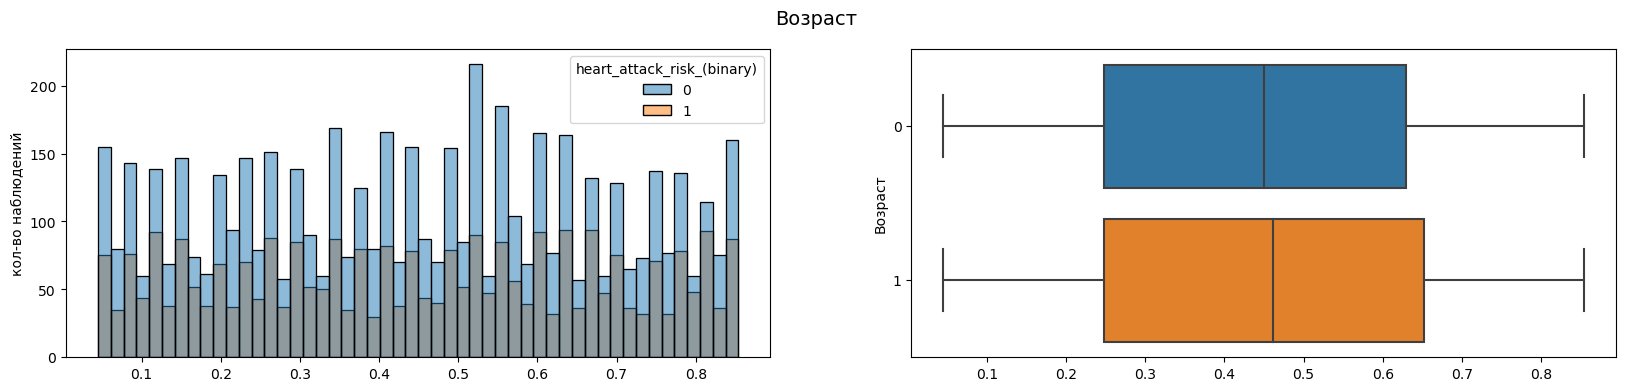

In [21]:
initial_data_analisys_numeric(df_main, 'age', split_column = 'heart_attack_risk_(binary)', selected_bins = 50)

In [22]:
numeric_columns.append('age')

**Вывод**: можно предположить, что существует зависимость между возрастом и риском инфаркта, но она не является ярковыраженной.

**Тестовая выборка**

Возраст() - описательные статистики



count    966.000000
mean       0.452916
std        0.231068
min        0.044944
25%        0.247191
50%        0.460674
75%        0.640449
max        0.853933
Name: age, dtype: float64

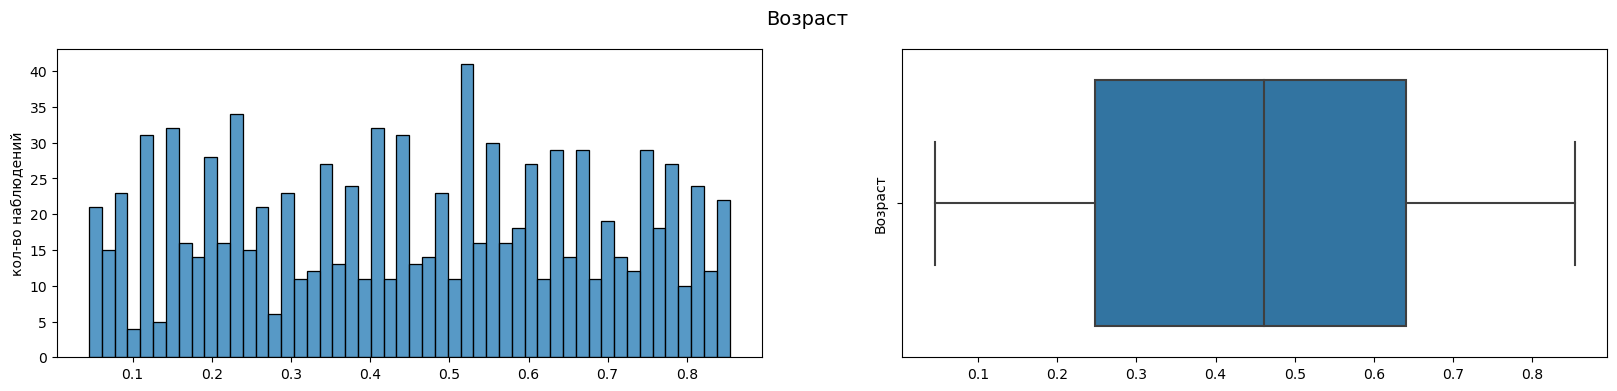

In [23]:
initial_data_analisys_numeric(df_test, 'age', selected_bins = 50)

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.

#### Холестерин (`cholesterol`)

**Тренировочная выборка**

Холестерин() - описательные статистики



count    8442.000000
mean        0.501108
std         0.288785
min         0.000000
25%         0.260714
50%         0.496429
75%         0.750000
max         1.000000
Name: cholesterol, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 0


count    5429.000000
mean        0.497027
std         0.288193
min         0.000000
25%         0.257143
50%         0.492857
75%         0.746429
max         1.000000
Name: cholesterol, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 1


count    3013.000000
mean        0.508461
std         0.289751
min         0.000000
25%         0.267857
50%         0.503571
75%         0.764286
max         1.000000
Name: cholesterol, dtype: float64

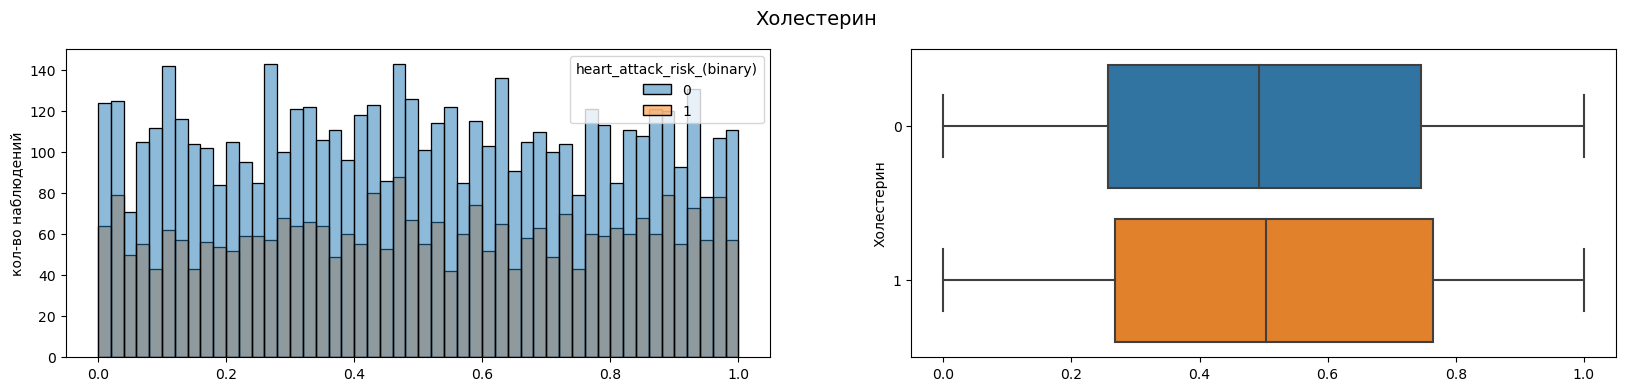

In [24]:
initial_data_analisys_numeric(df_main, 'cholesterol', split_column = 'heart_attack_risk_(binary)', selected_bins = 50)

In [25]:
numeric_columns.append('cholesterol')

**Вывод:** можно предположить, что существует зависимость между уровнем холестерина и риском инфаркта, но она не является ярковыраженной.

**Тестовая выборка**

Холестерин() - описательные статистики



count    966.000000
mean       0.488181
std        0.282039
min        0.000000
25%        0.243750
50%        0.499780
75%        0.710714
max        0.996429
Name: cholesterol, dtype: float64

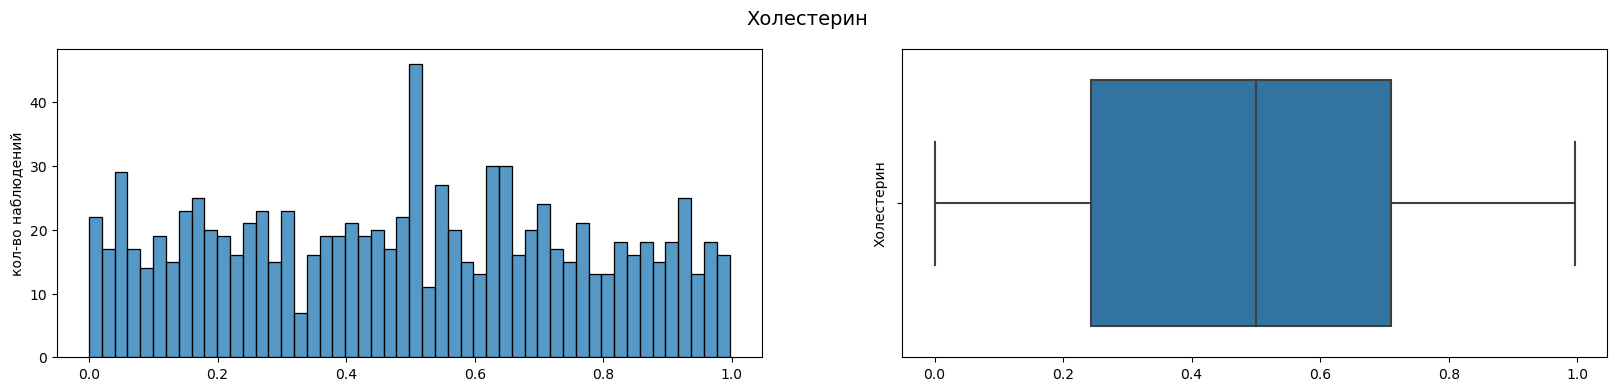

In [26]:
initial_data_analisys_numeric(df_test, 'cholesterol', selected_bins = 50)

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.

#### Сердечный ритм (`heart_rate`)

**Тренировочная выборка**

Сердечный ритм() - описательные статистики



count    8442.000000
mean        0.050194
std         0.018442
min         0.018332
25%         0.034830
50%         0.050412
75%         0.065995
max         0.082493
Name: heart_rate, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 0


count    5429.000000
mean        0.050215
std         0.018390
min         0.018332
25%         0.034830
50%         0.050412
75%         0.065995
max         0.082493
Name: heart_rate, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 1


count    3013.000000
mean        0.050157
std         0.018537
min         0.018332
25%         0.033914
50%         0.050412
75%         0.065995
max         0.082493
Name: heart_rate, dtype: float64

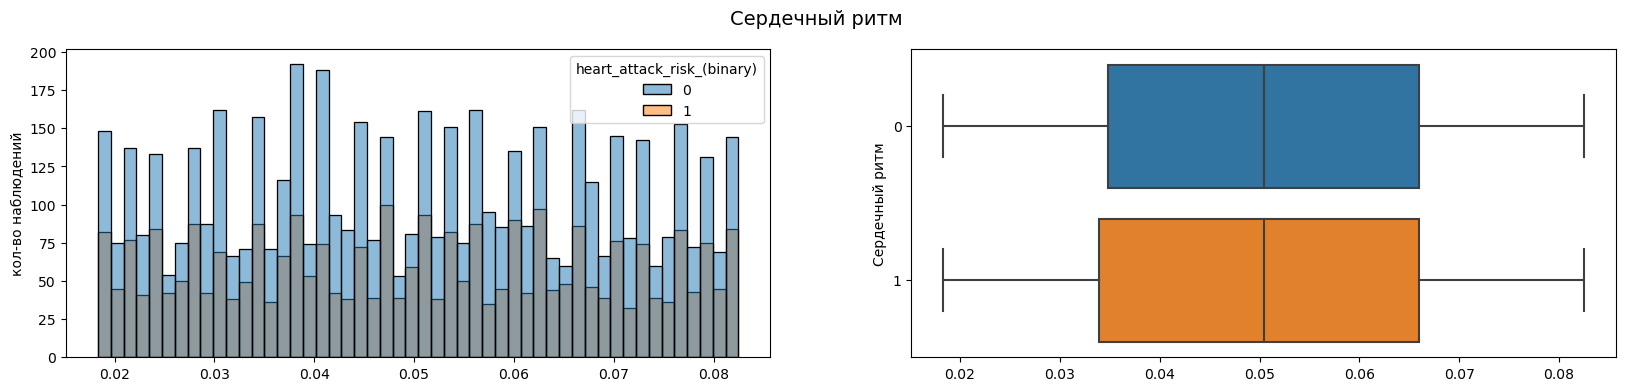

In [27]:
initial_data_analisys_numeric(df_main, 'heart_rate', split_column = 'heart_attack_risk_(binary)', selected_bins = 50)

In [28]:
numeric_columns.append('heart_rate')

**Вывод:** по результатам анализа не выявлено зависимости риска сердечного приступа от сердечного ритма.

**Тестовая выборка**

Сердечный ритм() - описательные статистики



count    966.000000
mean       0.051644
std        0.035502
min        0.000000
25%        0.036664
50%        0.050412
75%        0.065995
max        1.000000
Name: heart_rate, dtype: float64

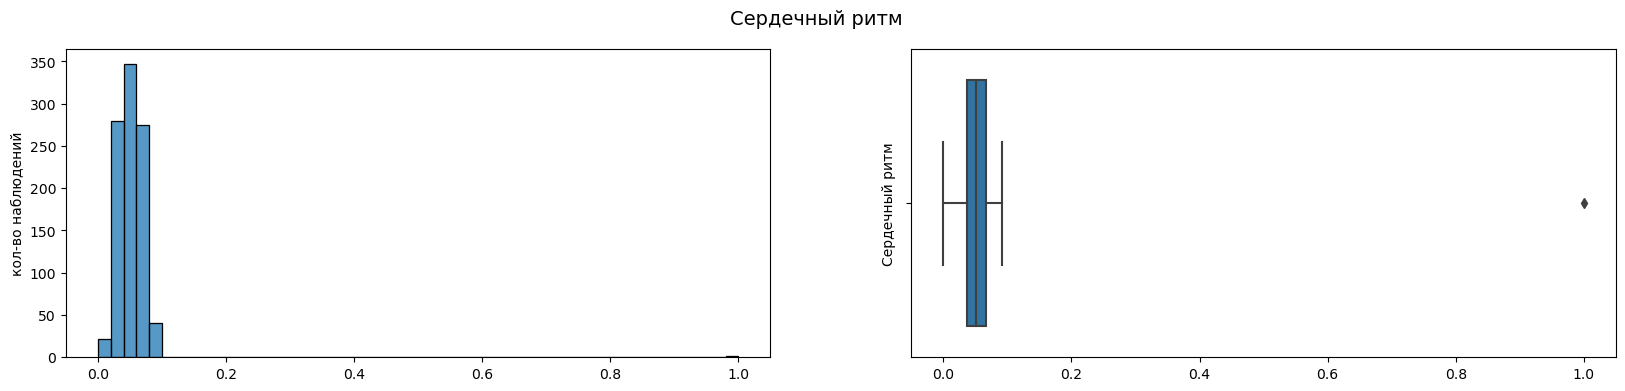

In [29]:
initial_data_analisys_numeric(df_test, 'heart_rate', selected_bins = 50)

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы, наблюдается единичный выброс.

#### Занятия спортом (`exercise_hours_per_week`)

**Тренировочная выборка**

Занятия спортом (ч/неделю)() - описательные статистики



count    8442.000000
mean        0.503415
std         0.288881
min         0.000000
25%         0.253359
50%         0.508244
75%         0.754901
max         1.000000
Name: exercise_hours_per_week, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 0


count    5429.000000
mean        0.501378
std         0.288960
min         0.000000
25%         0.252158
50%         0.502872
75%         0.754962
max         1.000000
Name: exercise_hours_per_week, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 1


count    3013.000000
mean        0.507085
std         0.288750
min         0.000133
25%         0.255758
50%         0.518336
75%         0.754813
max         0.999915
Name: exercise_hours_per_week, dtype: float64

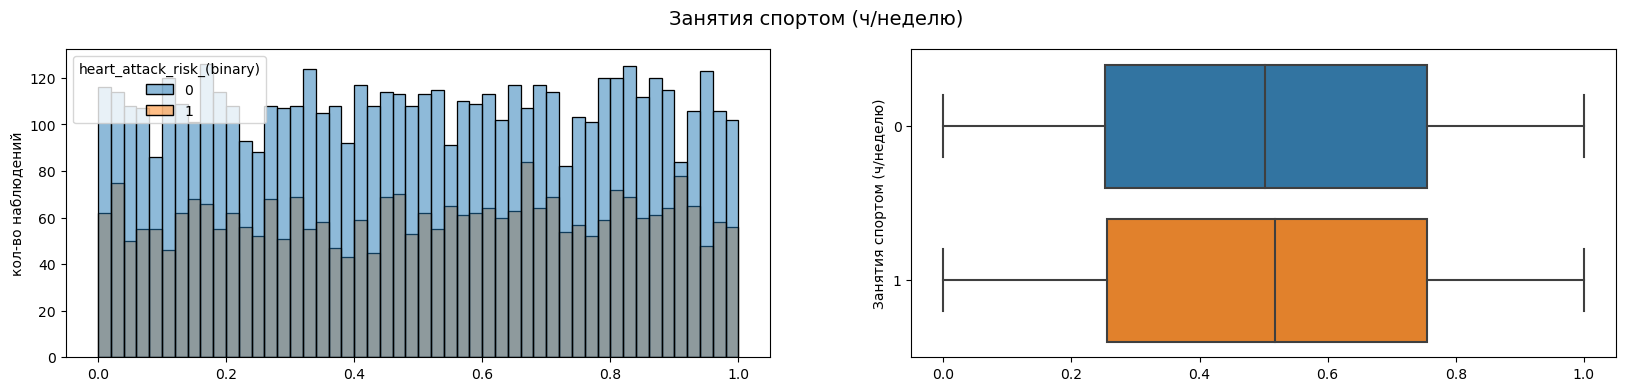

In [30]:
initial_data_analisys_numeric(df_main, 'exercise_hours_per_week', split_column = 'heart_attack_risk_(binary)', selected_bins = 50)

In [31]:
numeric_columns.append('exercise_hours_per_week')

**Вывод:** можно предположить, что существует некоторая зависимость между занятиями спортом и риском инфаркта, но она не является ярковыраженной.

**Тестовая выборка**

Занятия спортом (ч/неделю)() - описательные статистики



count    966.000000
mean       0.490706
std        0.284902
min        0.000336
25%        0.243431
50%        0.502110
75%        0.734425
max        0.998938
Name: exercise_hours_per_week, dtype: float64

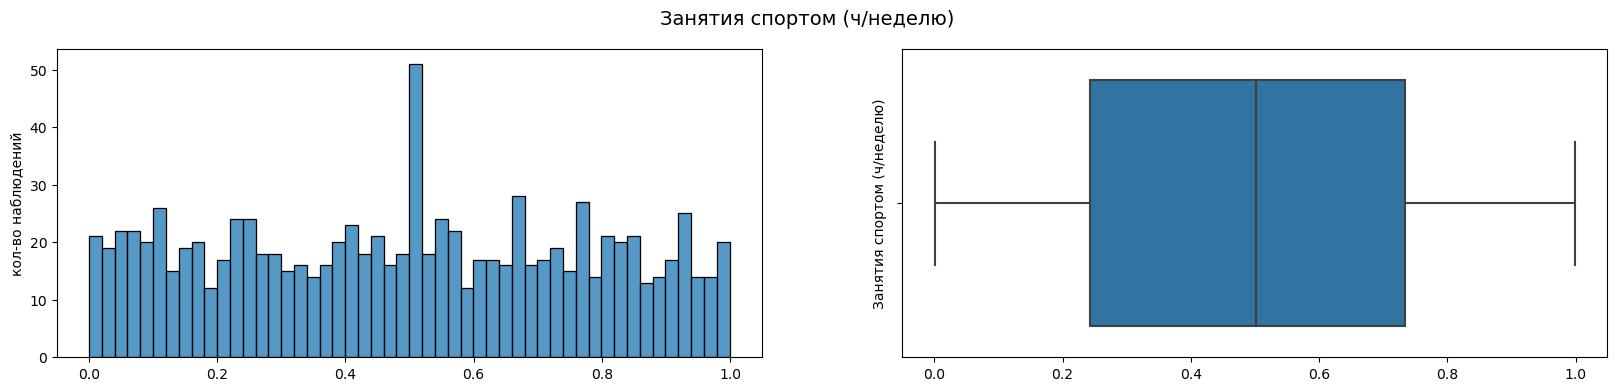

In [32]:
initial_data_analisys_numeric(df_test, 'exercise_hours_per_week', selected_bins = 50)

**Вывод**: в тестовой выборке чаще встречается значение порядка 0.5, чем в тренировочной выборке.

#### Сидячие часы (`sedentary_hours_per_day`)

**Тренирововчная выборка**

Сидячие ч/день() - описательные статистики



count    8442.000000
mean        0.499142
std         0.289418
min         0.000000
25%         0.247650
50%         0.492734
75%         0.751047
max         1.000000
Name: sedentary_hours_per_day, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 0


count    5429.000000
mean        0.498746
std         0.288854
min         0.000000
25%         0.246833
50%         0.491115
75%         0.751948
max         0.999419
Name: sedentary_hours_per_day, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 1


count    3013.000000
mean        0.499857
std         0.290479
min         0.000022
25%         0.250695
50%         0.497913
75%         0.749723
max         1.000000
Name: sedentary_hours_per_day, dtype: float64

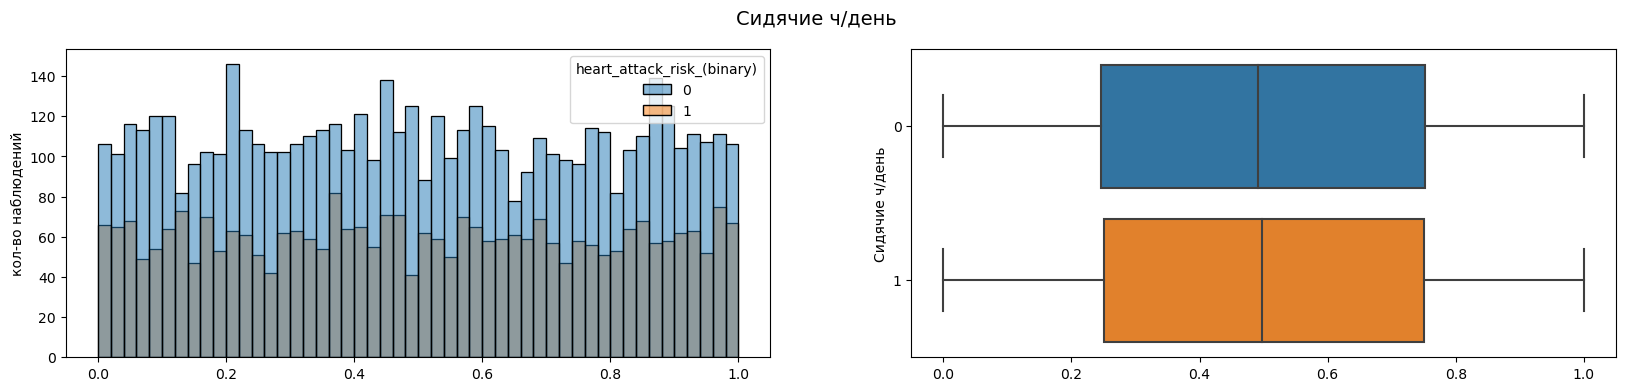

In [33]:
initial_data_analisys_numeric(df_main, 'sedentary_hours_per_day', split_column = 'heart_attack_risk_(binary)', selected_bins = 50)

In [34]:
numeric_columns.append('sedentary_hours_per_day')

**Вывод:** исследовательский анализ не выявил зависимость между количеством сидячих часо в день и риском сердечного приступа.

**Тестовая выборка**

Сидячие ч/день() - описательные статистики



count    966.000000
mean       0.506715
std        0.287826
min        0.001187
25%        0.258713
50%        0.501327
75%        0.759591
max        0.999033
Name: sedentary_hours_per_day, dtype: float64

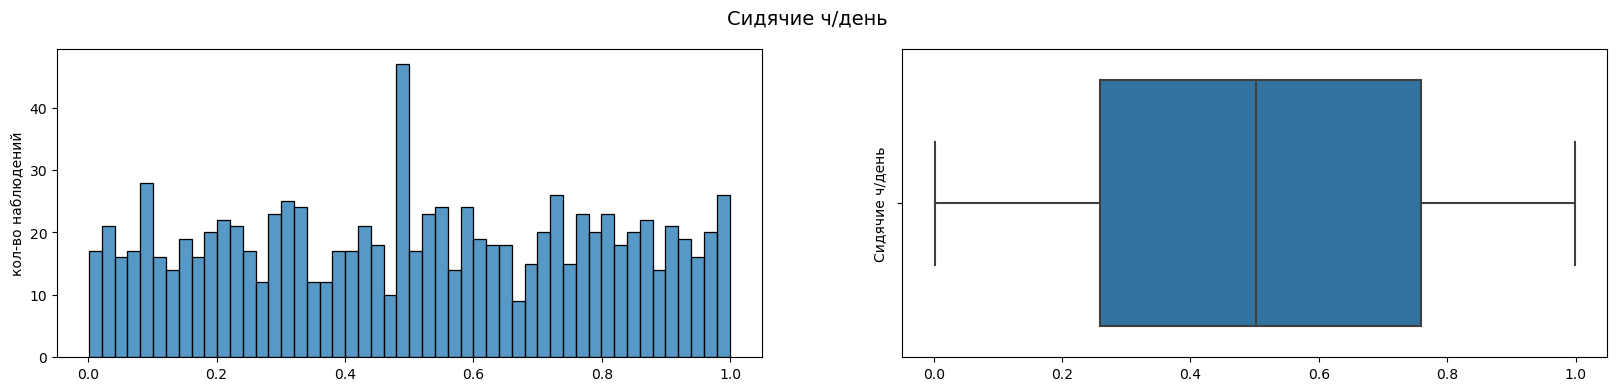

In [35]:
initial_data_analisys_numeric(df_test, 'sedentary_hours_per_day', selected_bins = 50)

**Вывод**: в тестовой выборке чаще встречается значение порядка 0.5, чем в тренировочной выборке.

#### Доход (`income`)

**Тренирововчная выборка**

Доход() - описательные статистики



count    8442.000000
mean        0.496089
std         0.288767
min         0.000000
25%         0.244591
50%         0.496052
75%         0.747603
max         1.000000
Name: income, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 0


count    5429.000000
mean        0.494326
std         0.288813
min         0.000000
25%         0.241833
50%         0.491847
75%         0.745009
max         0.999775
Name: income, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 1


count    3013.000000
mean        0.499265
std         0.288703
min         0.001676
25%         0.247603
50%         0.502401
75%         0.751801
max         1.000000
Name: income, dtype: float64

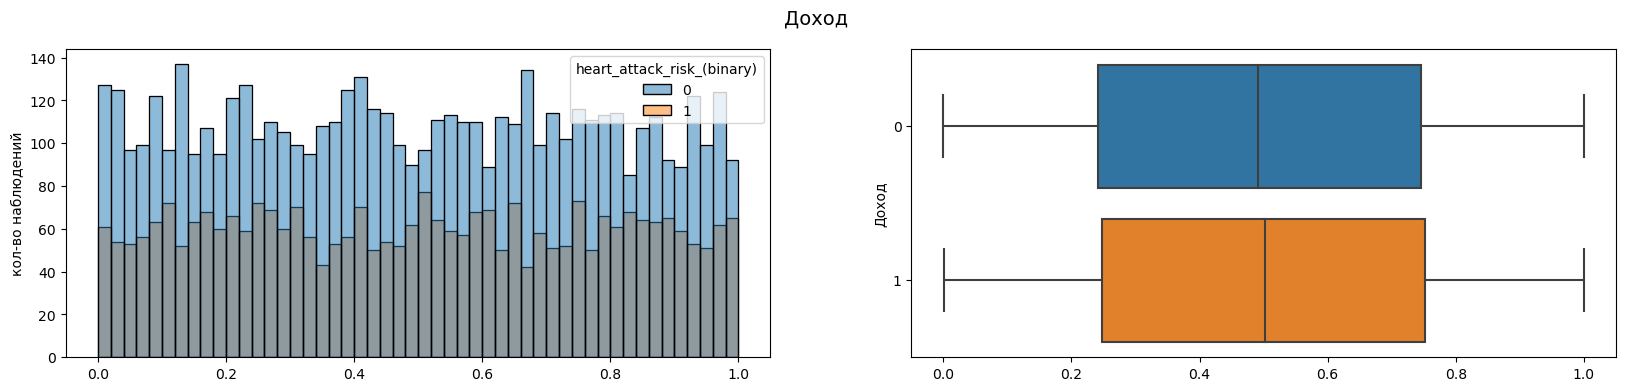

In [36]:
initial_data_analisys_numeric(df_main, 'income', split_column = 'heart_attack_risk_(binary)', selected_bins = 50)

In [37]:
numeric_columns.append('income')

**Вывод:** можно предположить, что существует зависимость между уровнем дохода и риском инфаркта, но она не является ярковыраженной.

**Тестовая выборка**

Доход() - описательные статистики



count    966.000000
mean       0.484408
std        0.273879
min        0.003351
25%        0.261446
50%        0.492015
75%        0.705371
max        0.998885
Name: income, dtype: float64

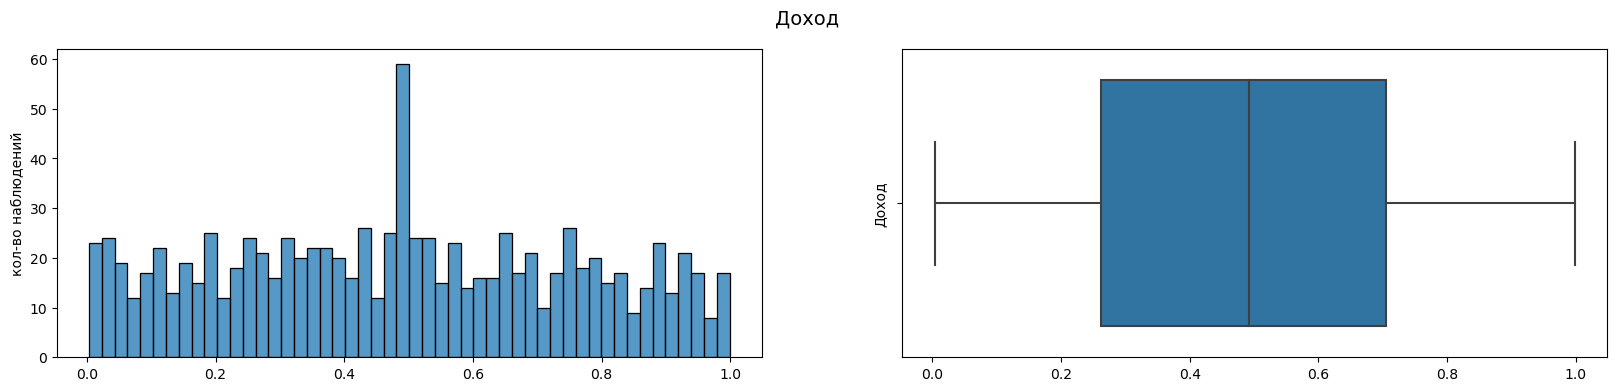

In [38]:
initial_data_analisys_numeric(df_test, 'income', selected_bins = 50)

**Вывод**: в тестовой выборке чаще встречается значение порядка 0.5, чем в тренировочной выборке.
#### Индекс массы тела (`bmi`)
**Тренирововчная выборка**

ИМТ() - описательные статистики



count    8442.000000
mean        0.496831
std         0.286599
min         0.000000
25%         0.247935
50%         0.490801
75%         0.744399
max         1.000000
Name: bmi, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 0


count    5429.000000
mean        0.498331
std         0.285949
min         0.000000
25%         0.251518
50%         0.492713
75%         0.744528
max         0.999835
Name: bmi, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 1


count    3013.000000
mean        0.494128
std         0.287795
min         0.000963
25%         0.244488
50%         0.486474
75%         0.743679
max         1.000000
Name: bmi, dtype: float64

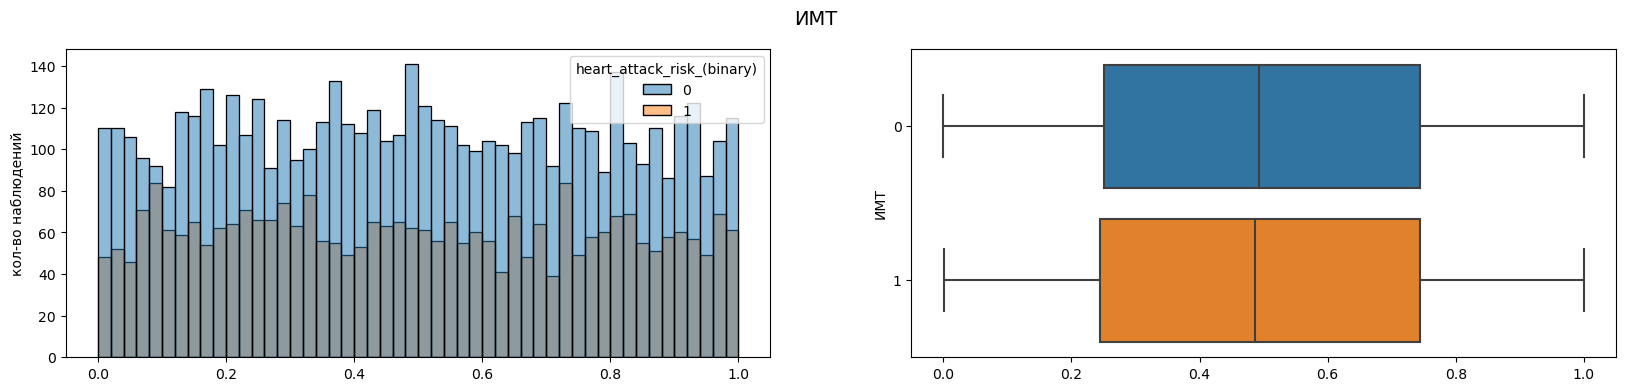

In [39]:
initial_data_analisys_numeric(df_main, 'bmi', split_column = 'heart_attack_risk_(binary)', selected_bins = 50)

In [40]:
numeric_columns.append('bmi')

**Вывод:** можно предположить, что существует зависимость между ИМТ и риском инфаркта, но она не является ярковыраженной.

**Тестовая выборка**

ИМТ() - описательные статистики



count    966.000000
mean       0.476796
std        0.291987
min        0.002598
25%        0.217527
50%        0.471185
75%        0.720503
max        0.999496
Name: bmi, dtype: float64

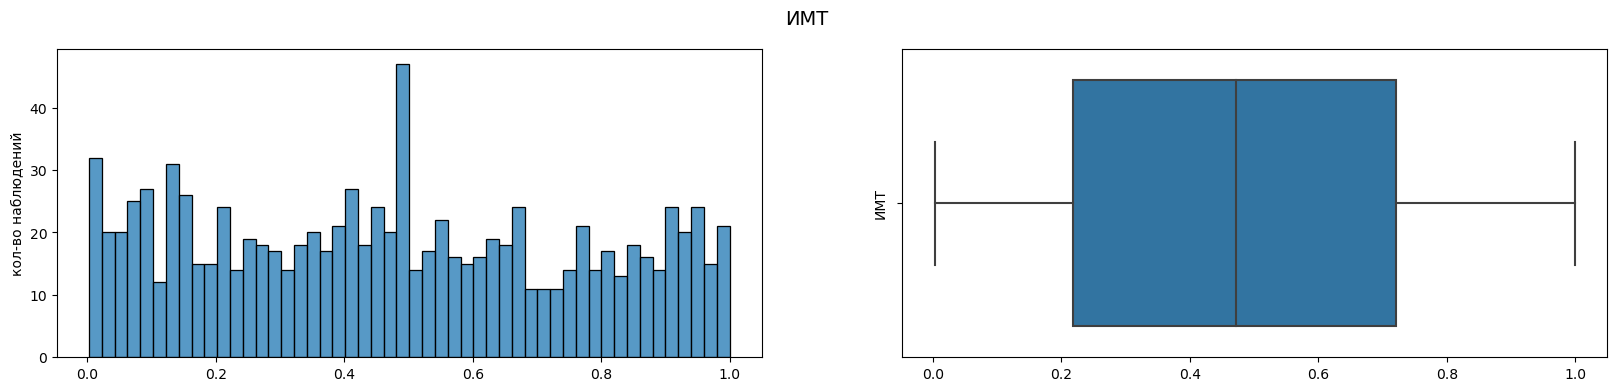

In [41]:
initial_data_analisys_numeric(df_test, 'bmi', selected_bins = 50)

**Вывод**: в тестовой выборке чаще встречается значение порядка 0.5, чем в тренировочной выборке.

#### Триглицериды (`triglycerides`)

**Тренирововчная выборка**

Триглицериды() - описательные статистики



count    8442.000000
mean        0.505539
std         0.290412
min         0.000000
25%         0.257143
50%         0.507792
75%         0.758442
max         1.000000
Name: triglycerides, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 0


count    5429.000000
mean        0.502939
std         0.289265
min         0.000000
25%         0.257143
50%         0.502597
75%         0.757143
max         1.000000
Name: triglycerides, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 1


count    3013.000000
mean        0.510223
std         0.292457
min         0.000000
25%         0.257143
50%         0.514286
75%         0.762338
max         1.000000
Name: triglycerides, dtype: float64

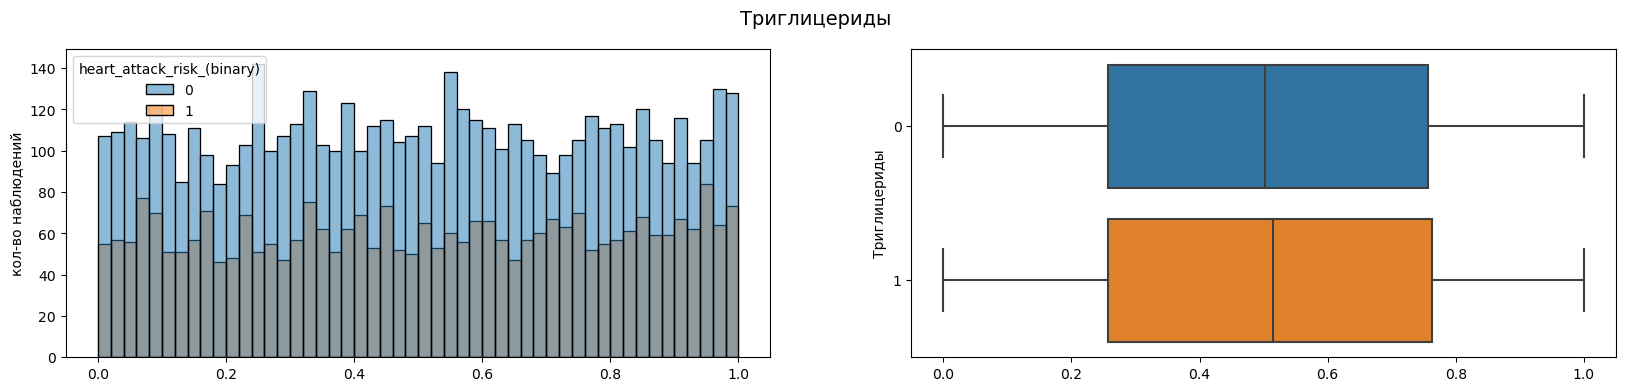

In [42]:
initial_data_analisys_numeric(df_main, 'triglycerides', split_column = 'heart_attack_risk_(binary)', selected_bins = 50)

In [43]:
numeric_columns.append('triglycerides')

**Вывод:** можно предположить, что существует зависимость между уровнем триглицеридов и риском инфаркта, но она не является ярковыраженной.

**Тестовая выборка**

Триглицериды() - описательные статистики



count    966.000000
mean       0.486688
std        0.284534
min        0.000000
25%        0.249675
50%        0.488961
75%        0.718182
max        0.998701
Name: triglycerides, dtype: float64

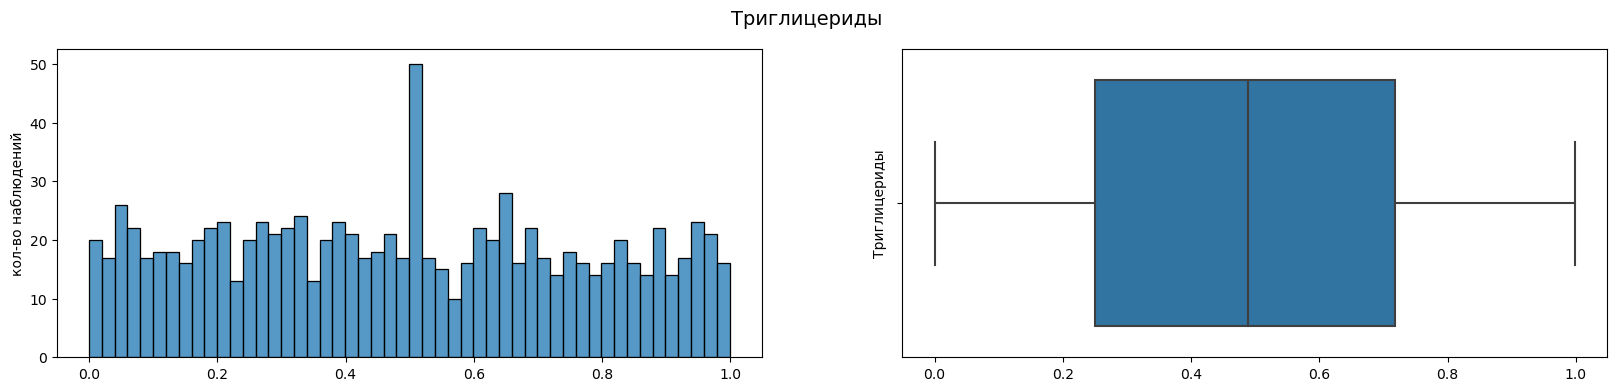

In [44]:
initial_data_analisys_numeric(df_test, 'triglycerides', selected_bins = 50)


**Вывод**: в тестовой выборке чаще встречается значение порядка 0.5, чем в тренировочной выборке.

#### Сахар в крови (`blood_sugar`)

**Тренирововчная выборка**

Сахар в крови() - описательные статистики



count    8442.000000
mean        0.227998
std         0.074623
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: blood_sugar, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 0


count    5429.000000
mean        0.228300
std         0.076064
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         0.918972
Name: blood_sugar, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 1


count    3013.000000
mean        0.227455
std         0.071962
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: blood_sugar, dtype: float64

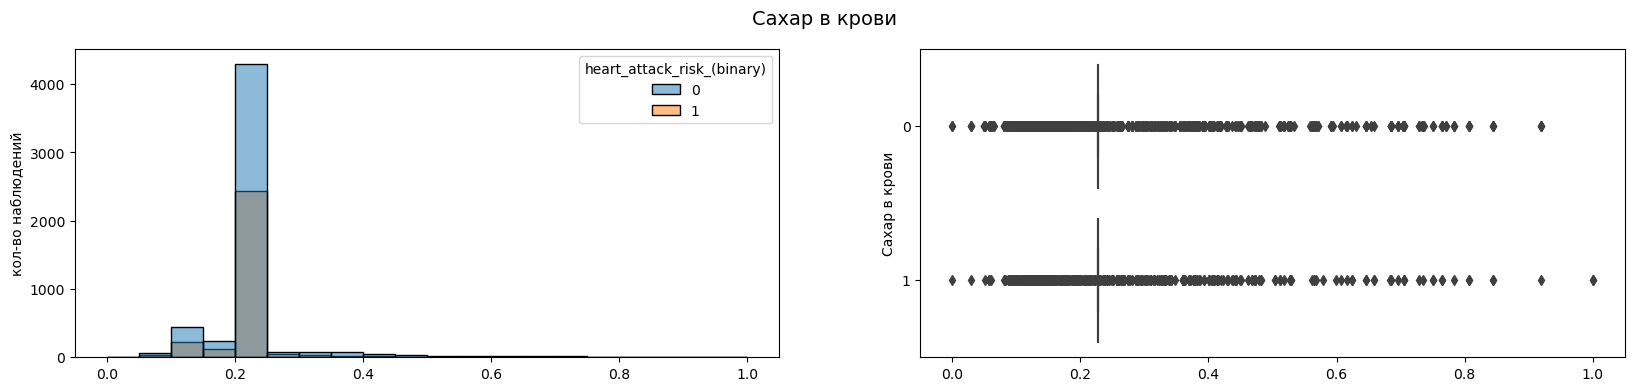

In [45]:
initial_data_analisys_numeric(df_main, 'blood_sugar', split_column = 'heart_attack_risk_(binary)', selected_bins = 20)

In [46]:
numeric_columns.append('blood_sugar')

**Вывод:** абсолютное большинство значений сконцентрированы в одной точке вне зависимости от уровня риска сердечного приступа.

**Тестовая выборка**

Сахар в крови() - описательные статистики



count    966.000000
mean       0.224127
std        0.065270
min        0.029644
25%        0.227018
50%        0.227018
75%        0.227018
max        0.750988
Name: blood_sugar, dtype: float64

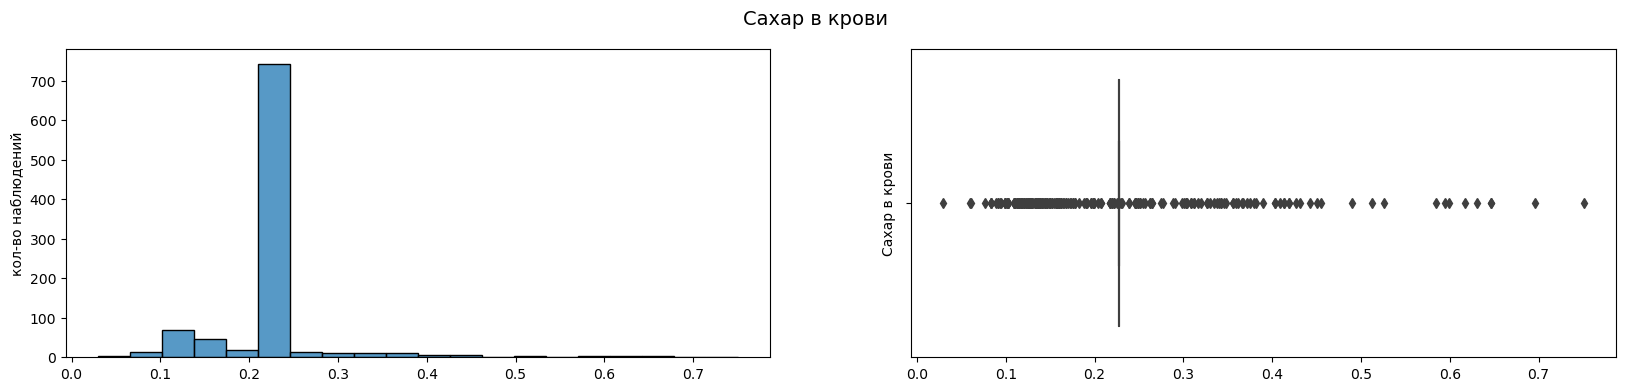

In [47]:
initial_data_analisys_numeric(df_test, 'blood_sugar', selected_bins = 20)

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.

#### Креатинкиназа МВ (`ck-mb`)

**Тренирововчная выборка**

Креатинкиназа КК() - описательные статистики



count    8442.000000
mean        0.047745
std         0.070399
min         0.000000
25%         0.048229
50%         0.048229
75%         0.048229
max         1.000000
Name: ck-mb, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 0


count    5429.000000
mean        0.048080
std         0.073472
min         0.000080
25%         0.048229
50%         0.048229
75%         0.048229
max         1.000000
Name: ck-mb, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 1


count    3013.000000
mean        0.047141
std         0.064501
min         0.000000
25%         0.048229
50%         0.048229
75%         0.048229
max         1.000000
Name: ck-mb, dtype: float64

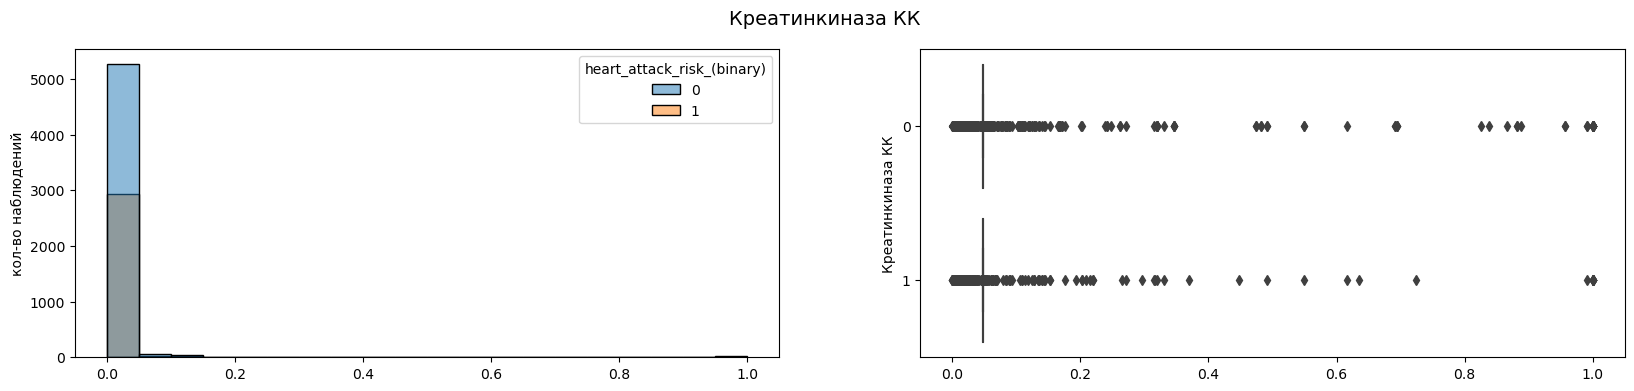

In [48]:
initial_data_analisys_numeric(df_main, 'ck-mb', split_column = 'heart_attack_risk_(binary)', selected_bins = 20)

In [49]:
numeric_columns.append('ck-mb')

**Вывод:** абсолютное большинство значений сконцентрированы в одной точке вне зависимости от уровня риска сердечного приступа.

**Тестовая выборка**

Креатинкиназа КК() - описательные статистики



count    966.000000
mean       0.048855
std        0.079742
min        0.000000
25%        0.048229
50%        0.048229
75%        0.048229
max        1.000000
Name: ck-mb, dtype: float64

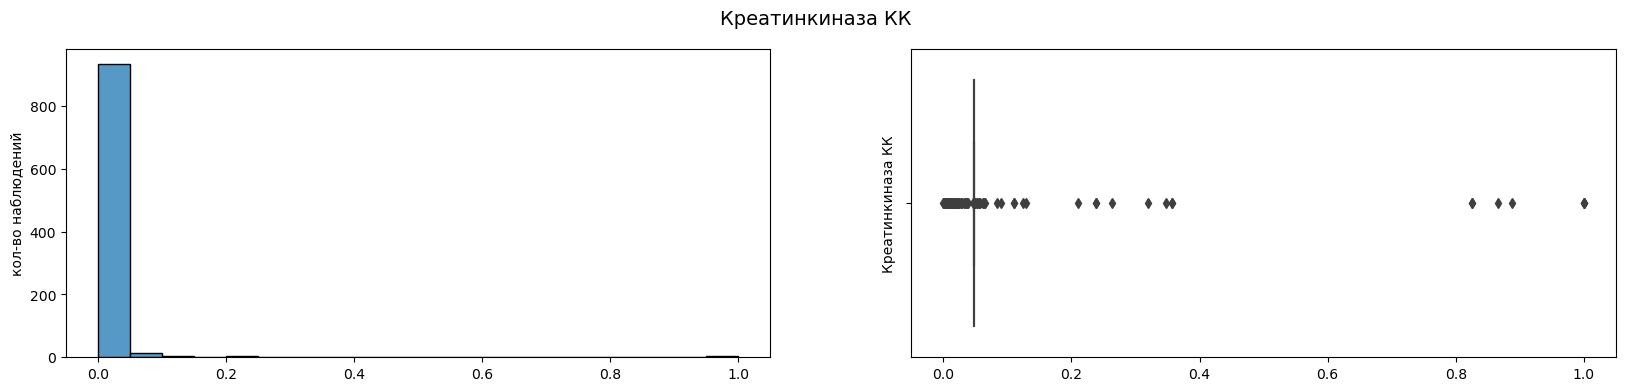

In [50]:
initial_data_analisys_numeric(df_test, 'ck-mb', selected_bins = 20)

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.
#### Тропонин (`troponin`)

**Тренирововчная выборка**

Тропонин() - описательные статистики



count    8442.000000
mean        0.036867
std         0.059284
min         0.000000
25%         0.036512
50%         0.036512
75%         0.036512
max         1.000000
Name: troponin, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 0


count    5429.000000
mean        0.036618
std         0.055758
min         0.000000
25%         0.036512
50%         0.036512
75%         0.036512
max         1.000000
Name: troponin, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 1


count    3013.000000
mean        0.037317
std         0.065166
min         0.000097
25%         0.036512
50%         0.036512
75%         0.036512
max         0.970871
Name: troponin, dtype: float64

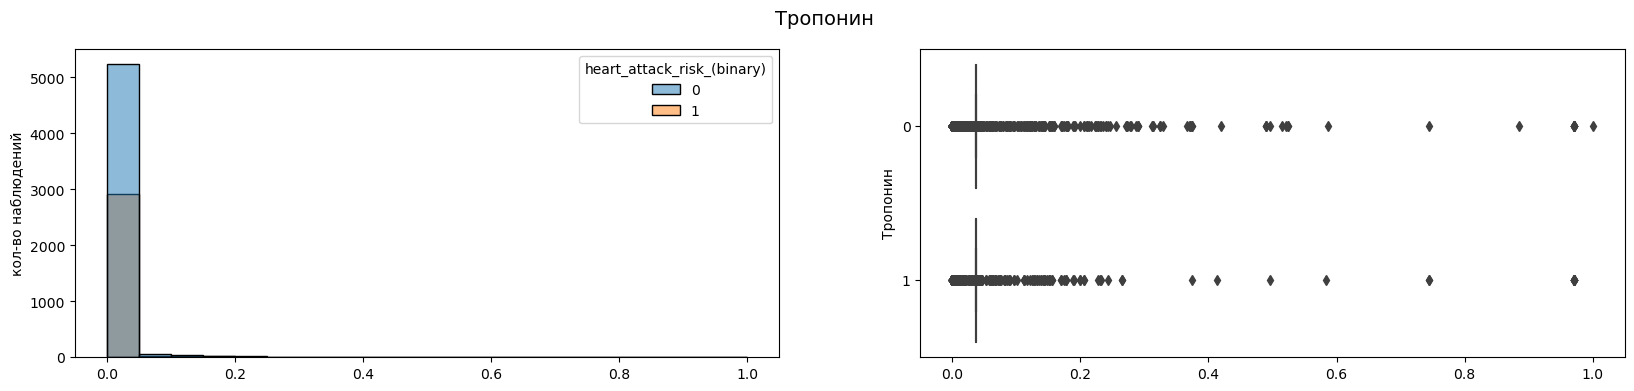

In [51]:
initial_data_analisys_numeric(df_main, 'troponin', split_column = 'heart_attack_risk_(binary)', selected_bins = 20)

In [52]:
numeric_columns.append('troponin')

**Вывод:** абсолютное большинство значений сконцентрированы в одной точке вне зависимости от уровня риска сердечного приступа.

**Тестовая выборка**

Тропонин() - описательные статистики



count    966.000000
mean       0.034926
std        0.053855
min        0.000194
25%        0.036512
50%        0.036512
75%        0.036512
max        0.970871
Name: troponin, dtype: float64

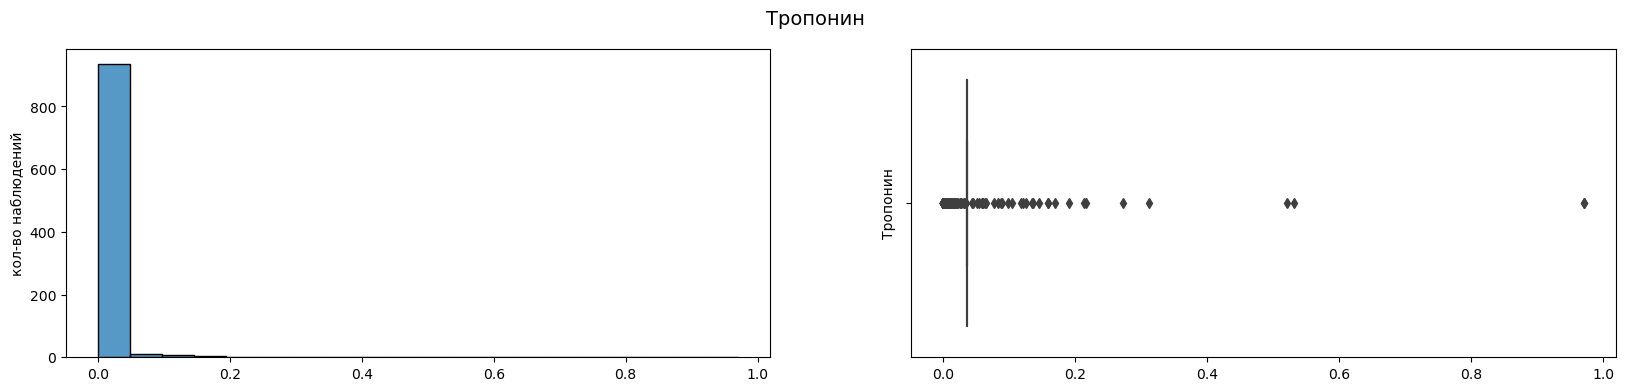

In [53]:
initial_data_analisys_numeric(df_test, 'troponin', selected_bins = 20)

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.
#### Систолическое давление (`systolic_blood_pressure`)

**Тренирововчная выборка**

Систолическое давление() - описательные статистики



count    8442.000000
mean        0.451955
std         0.170187
min         0.161290
25%         0.303226
50%         0.451613
75%         0.600000
max         0.741935
Name: systolic_blood_pressure, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 0


count    5429.000000
mean        0.448501
std         0.170359
min         0.161290
25%         0.296774
50%         0.445161
75%         0.600000
max         0.741935
Name: systolic_blood_pressure, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 1


count    3013.000000
mean        0.458178
std         0.169725
min         0.161290
25%         0.316129
50%         0.458065
75%         0.606452
max         0.741935
Name: systolic_blood_pressure, dtype: float64

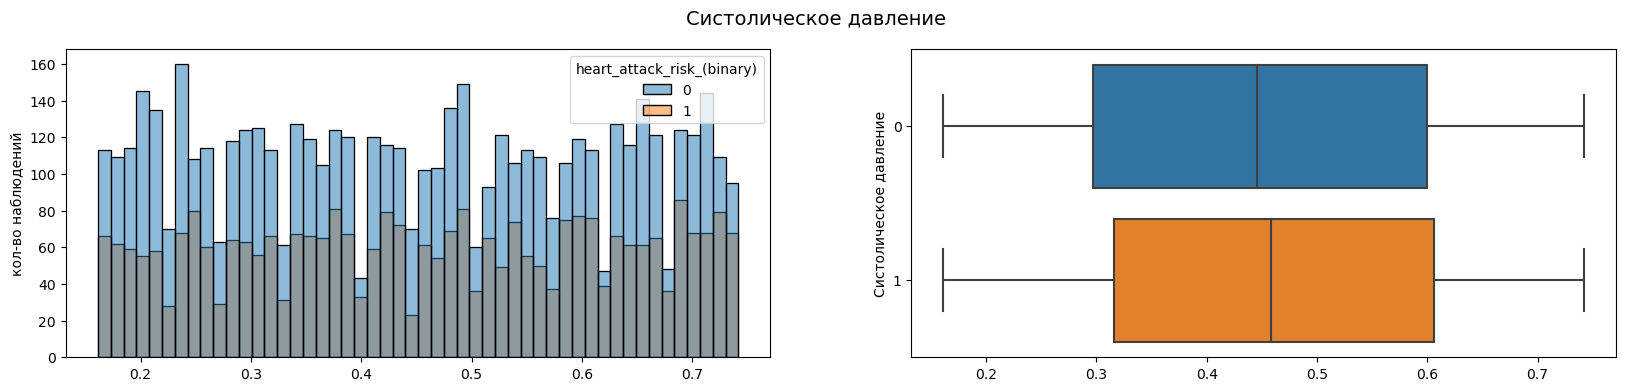

In [54]:
initial_data_analisys_numeric(df_main, 'systolic_blood_pressure', split_column = 'heart_attack_risk_(binary)', selected_bins = 50)

In [55]:
numeric_columns.append('systolic_blood_pressure')

**Вывод:** Высокий риск сердечного приступа может быть связан с более высоким систолическим давлением.

**Тестовая выборка**

Систолическое давление() - описательные статистики



count    966.000000
mean       0.447172
std        0.171837
min        0.012903
25%        0.296774
50%        0.445161
75%        0.600000
max        0.741935
Name: systolic_blood_pressure, dtype: float64

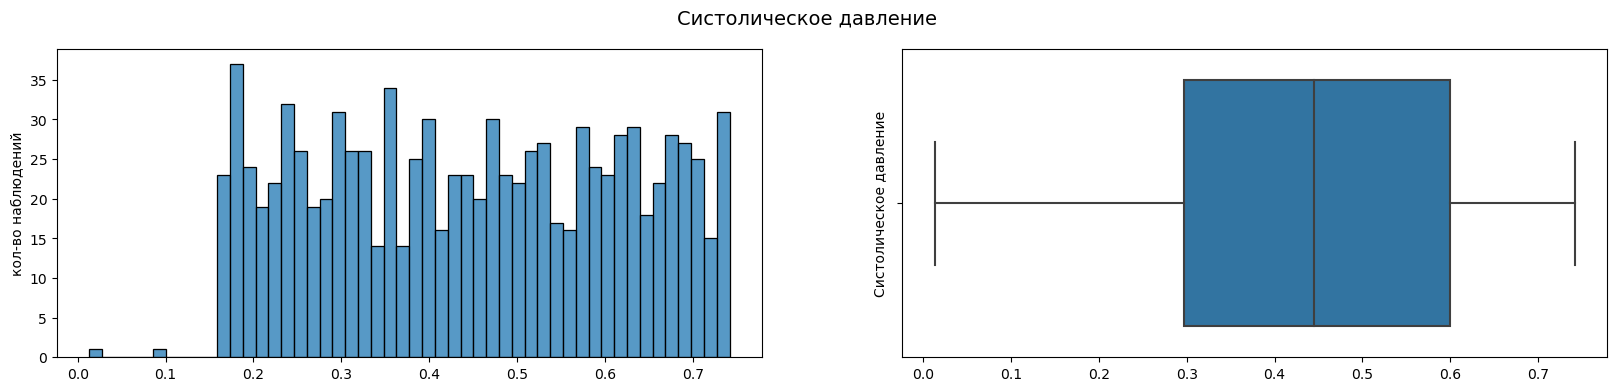

In [56]:
initial_data_analisys_numeric(df_test, 'systolic_blood_pressure', selected_bins = 50)

**Вывод**: в тестовой выборке отсутствуют наблюдения с низким давлением.

#### Диастолическое давление (`diastolic_blood_pressure`)

**Тренирововчная выборка**

Диастолическое давление() - описательные статистики



count    8442.000000
mean        0.501672
std         0.170302
min         0.209302
25%         0.348837
50%         0.500000
75%         0.651163
max         0.790698
Name: diastolic_blood_pressure, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 0


count    5429.000000
mean        0.502347
std         0.171069
min         0.209302
25%         0.348837
50%         0.500000
75%         0.651163
max         0.790698
Name: diastolic_blood_pressure, dtype: float64


Категория в столбце  heart_attack_risk_(binary) 1


count    3013.000000
mean        0.500455
std         0.168934
min         0.209302
25%         0.348837
50%         0.500000
75%         0.639535
max         0.790698
Name: diastolic_blood_pressure, dtype: float64

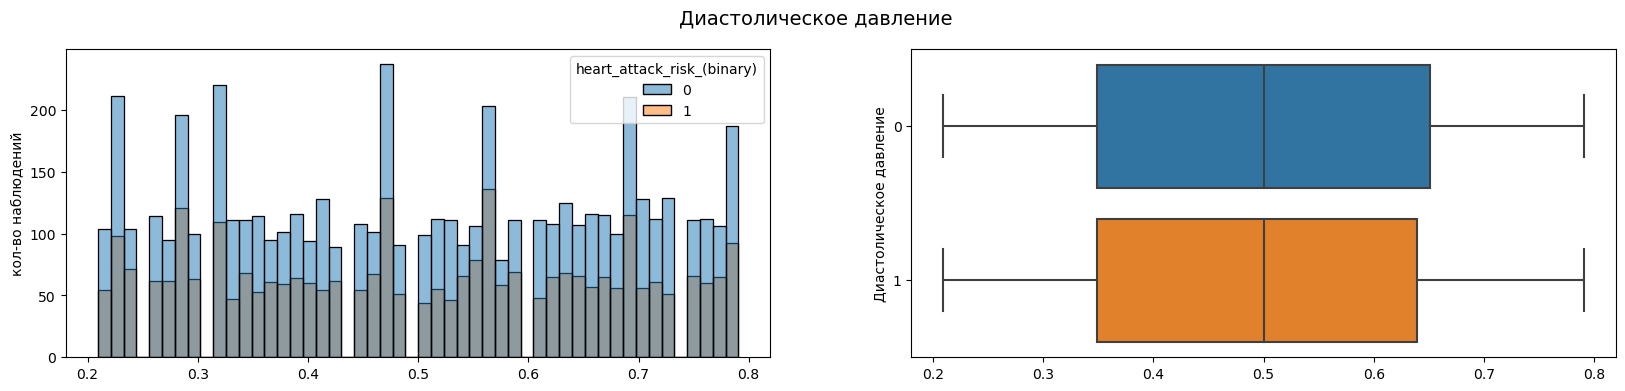

In [57]:
initial_data_analisys_numeric(df_main, 'diastolic_blood_pressure', split_column = 'heart_attack_risk_(binary)', selected_bins = 50)

In [58]:
numeric_columns.append('diastolic_blood_pressure')

**Вывод:** Исследовательский анлиз не показал зависимости между риском сердечного приступа и диастолическим давлением.

**Тестовая выборка**

Диастолическое давление() - описательные статистики



count    966.000000
mean       0.496822
std        0.173935
min        0.116279
25%        0.348837
50%        0.488372
75%        0.639535
max        0.790698
Name: diastolic_blood_pressure, dtype: float64

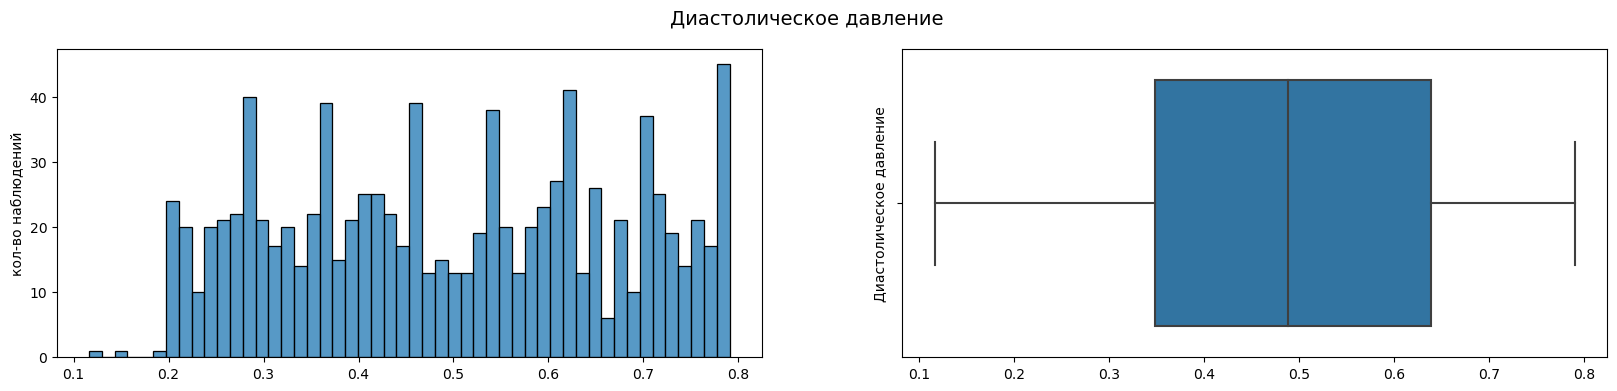

In [59]:
initial_data_analisys_numeric(df_test, 'diastolic_blood_pressure', selected_bins = 50)

**Вывод**: в тестовой выборке отсутствуют наблюдения с низким давлением, что соответствует более высокоми систолическому давлению в тестовой выборке.

#### Диабет (`diabetes`)

**Тренирововчная выборка**

Диабет - количество значений



diabetes
1.0    5505
0.0    2937
Name: diabetes, dtype: int64

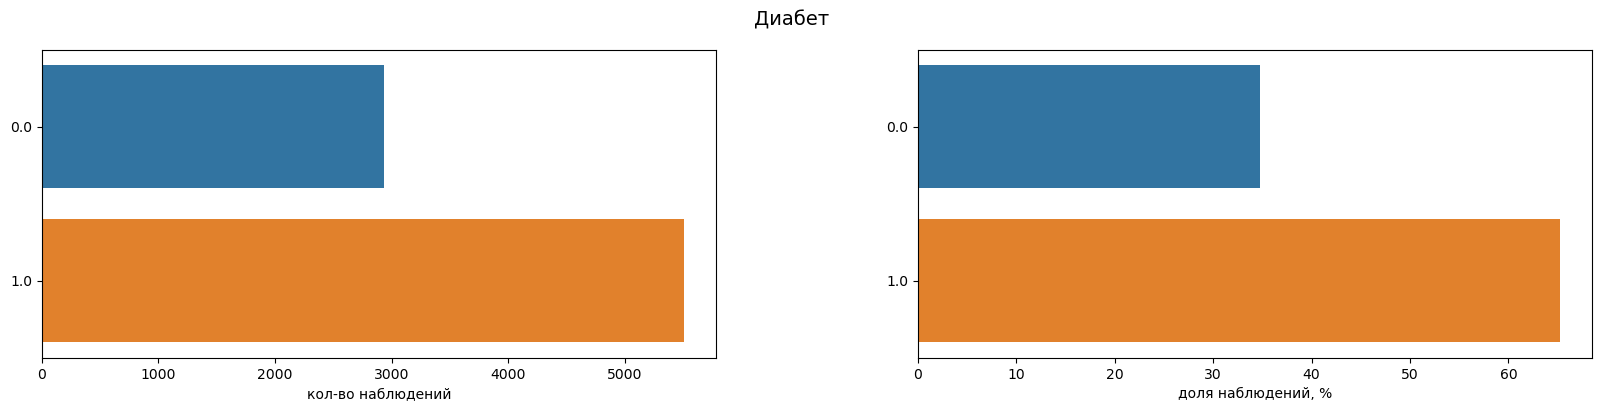

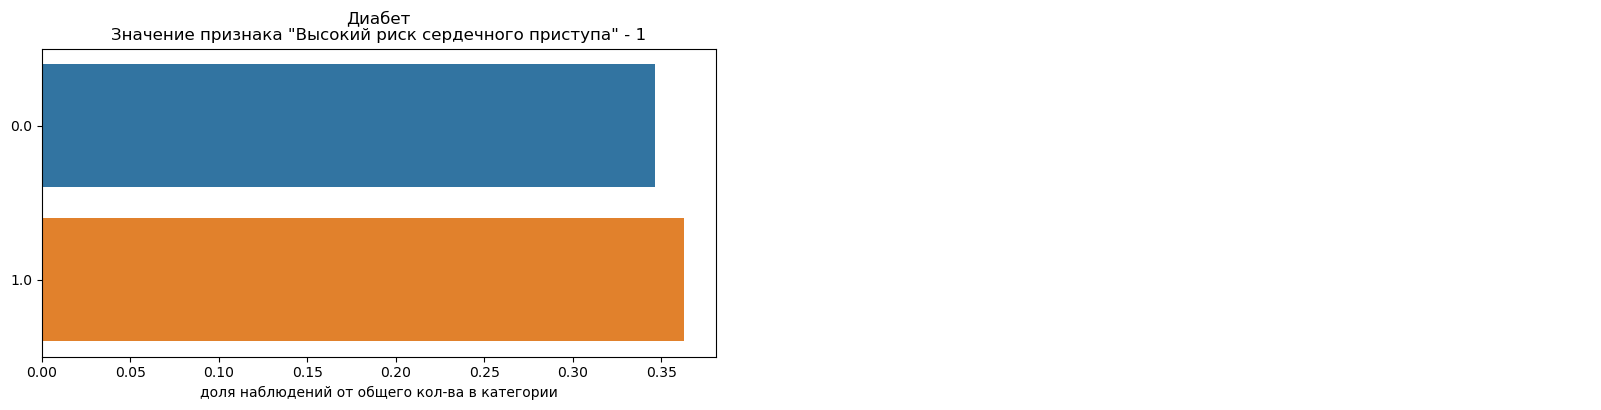

In [60]:
initial_data_analisys_category(df_main, 'diabetes', target_column = 'heart_attack_risk_(binary)', target_value = 1)

In [61]:
df_main['diabetes'] = df_main['diabetes'].astype('int')
float_to_int_columns.append('diabetes')
category_columns.append('diabetes')

**Вывод:** В выборке 65% наблдений - пациенты с диабетом. Высокий риск сердечного приступа чаще встречается у пациентов с диабетом.

**Тестовая выборка**

Диабет - количество значений



diabetes
1.0    614
0.0    321
Name: diabetes, dtype: int64

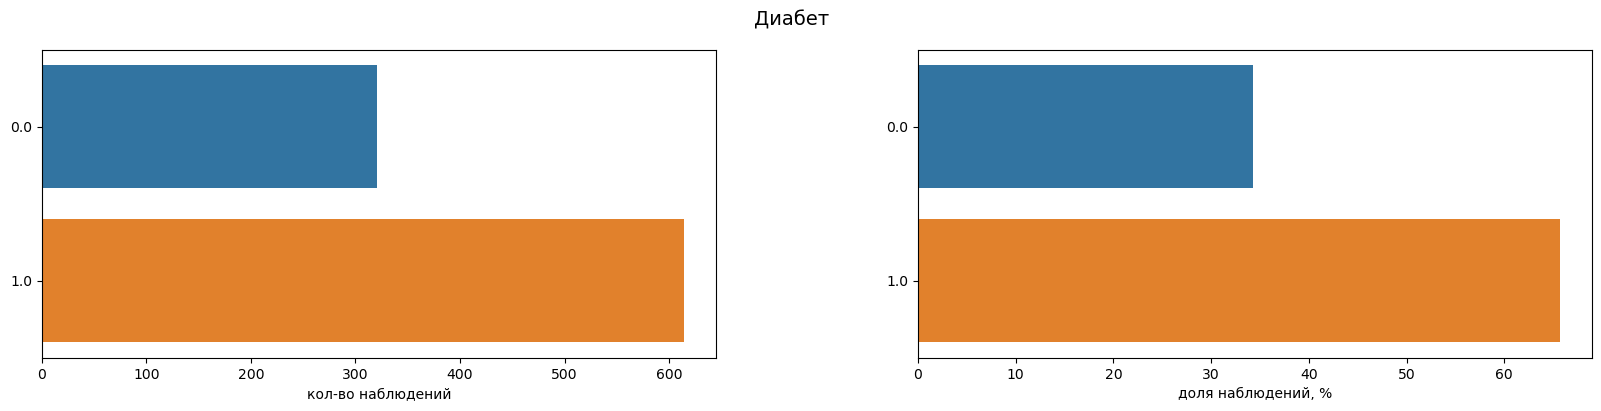

In [62]:
initial_data_analisys_category(df_test, 'diabetes')

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.

#### Курение (`smoking`)

**Тренирововчная выборка**

Курение - количество значений



smoking
1.0    7622
0.0     820
Name: smoking, dtype: int64

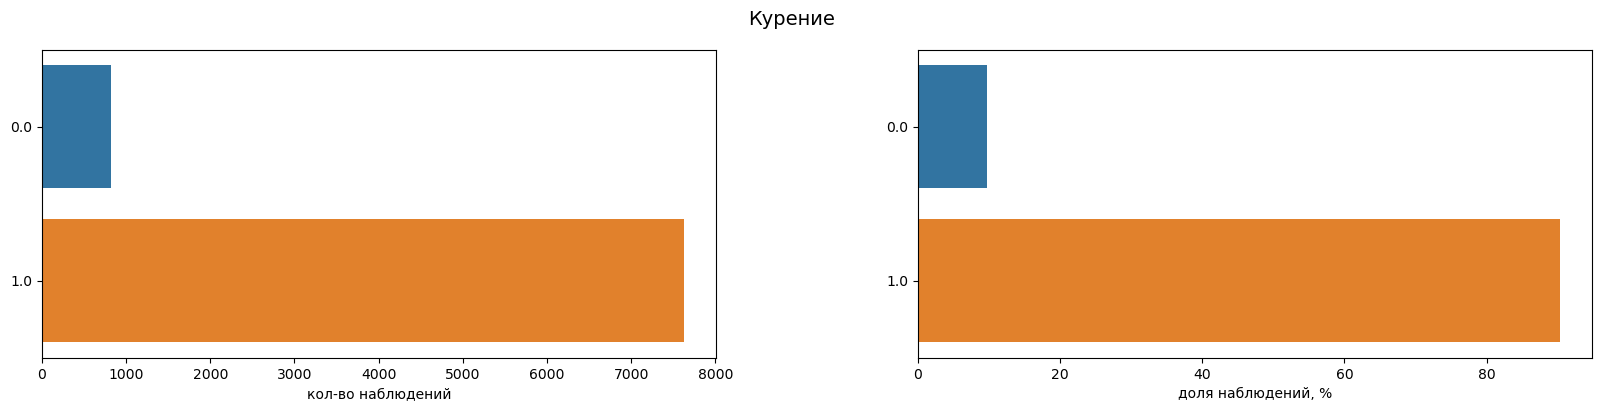

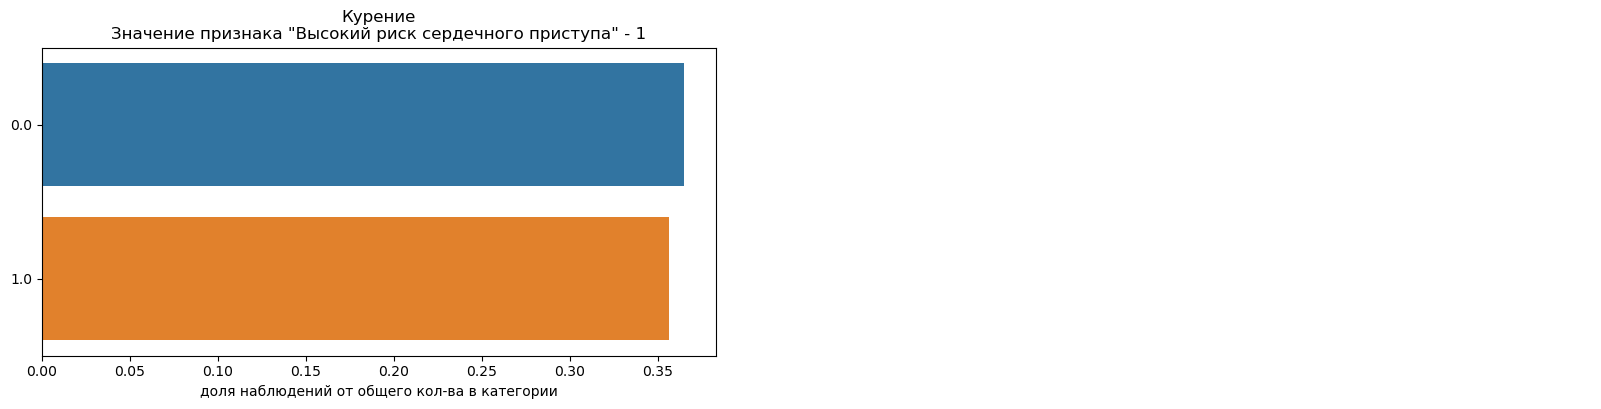

In [63]:
initial_data_analisys_category(df_main, 'smoking', target_column = 'heart_attack_risk_(binary)', target_value = 1)

In [64]:
df_main['smoking'] = df_main['smoking'].astype('int')
float_to_int_columns.append('smoking')
category_columns.append('smoking')

**Вывод:** В выборке 90% наблдений - курящие пациенты. Высокий риск сердечного приступа чаще встречается у пациентов, которые не курят, что не соотведствует общепринятым представлениям о вреде курения.

**Тестовая выборка**

Курение - количество значений



smoking
1.0    840
0.0     95
Name: smoking, dtype: int64

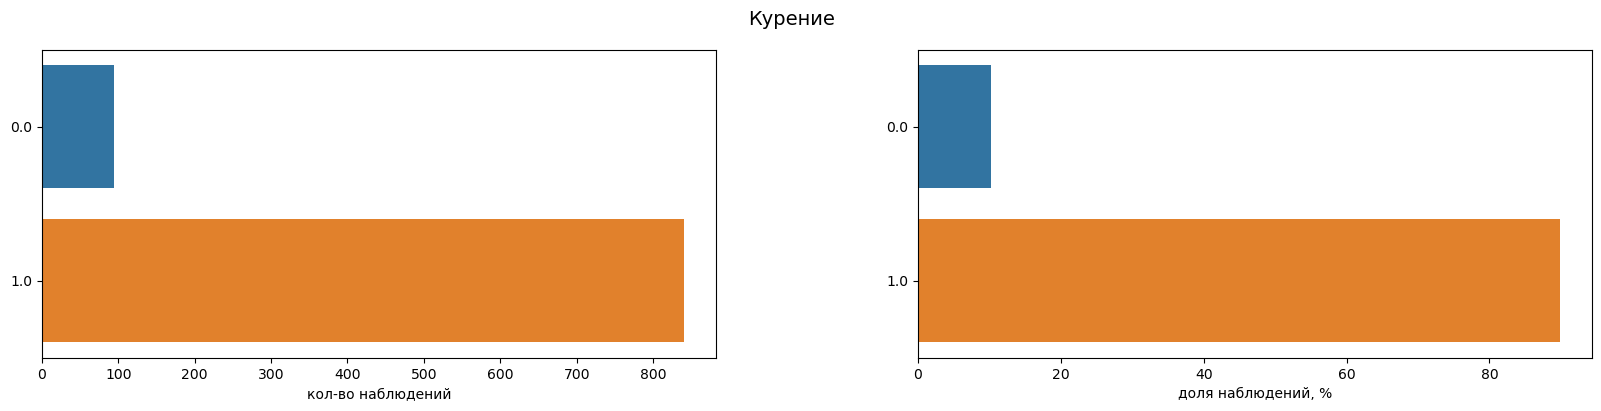

In [65]:
initial_data_analisys_category(df_test, 'smoking')

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.
#### Семейная история болезни (`family_history`)

**Тренирововчная выборка**

Семейный история болезни - количество значений



family_history
0.0    4309
1.0    4133
Name: family_history, dtype: int64

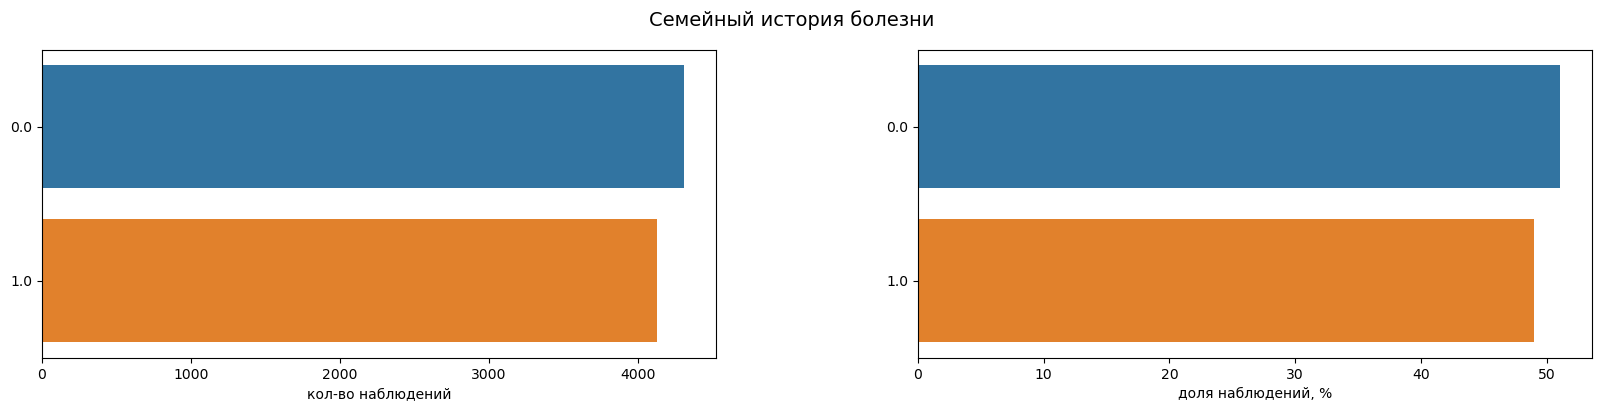

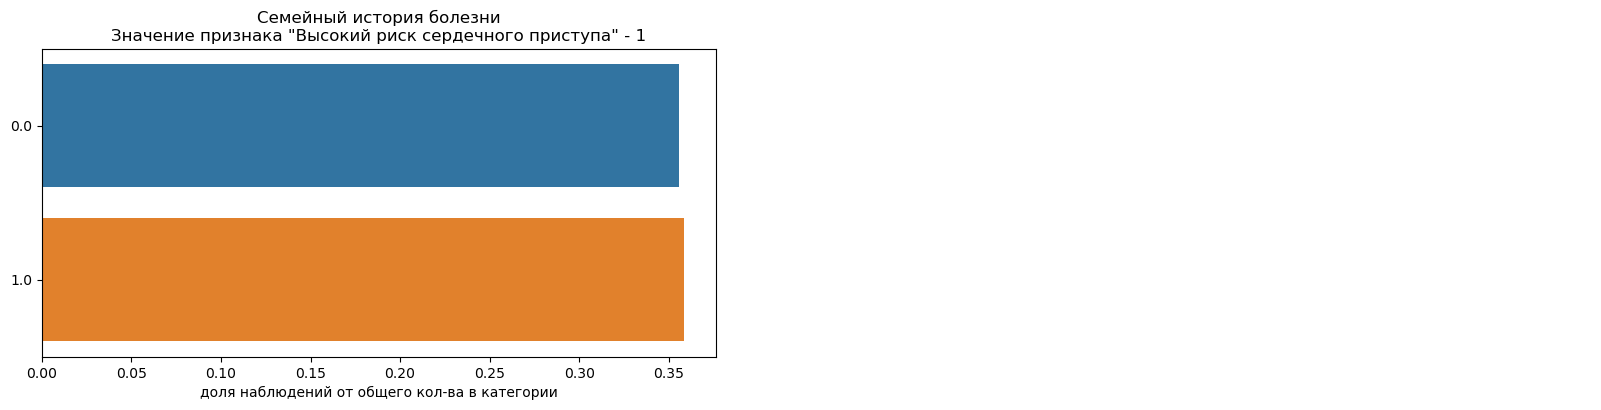

In [66]:
initial_data_analisys_category(df_main, 'family_history', target_column = 'heart_attack_risk_(binary)', target_value = 1)

In [67]:
df_main['family_history'] = df_main['family_history'].astype('int')
float_to_int_columns.append('family_history')
category_columns.append('family_history')

**Вывод:** Высокий риск сердечного присупа встречается одинаково часто у пациентов с и без истории сердечных заболеваний в семейном анамнезе.

**Тестовая выборка**

Семейный история болезни - количество значений



family_history
0.0    485
1.0    450
Name: family_history, dtype: int64

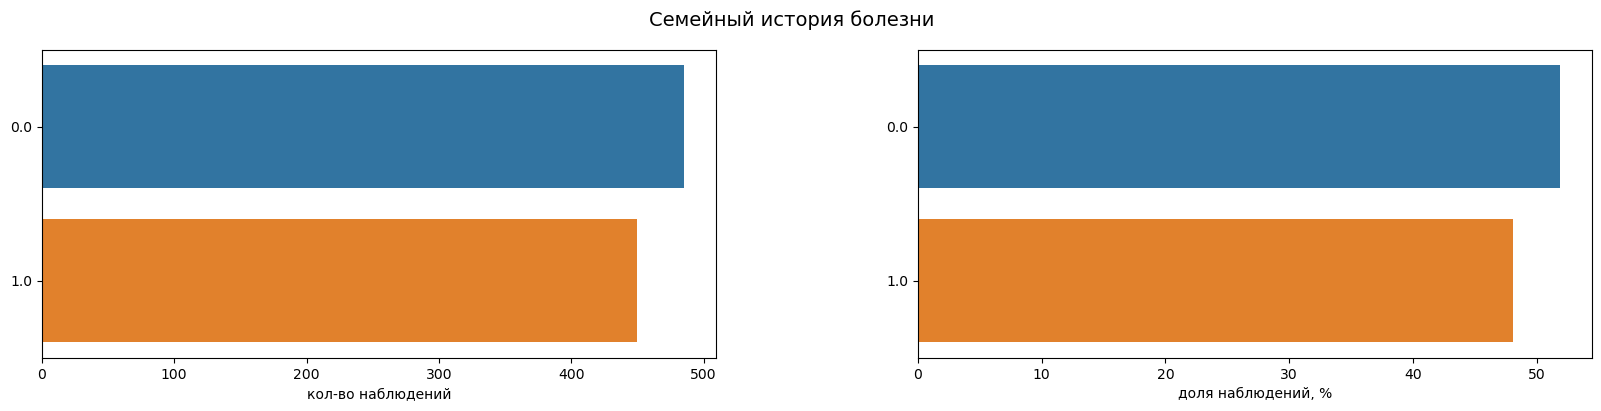

In [68]:
initial_data_analisys_category(df_test, 'family_history')

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.

#### Ожирение (`obesity`)

**Тренирововчная выборка**

Ожирение - количество значений



obesity
0.0    4235
1.0    4207
Name: obesity, dtype: int64

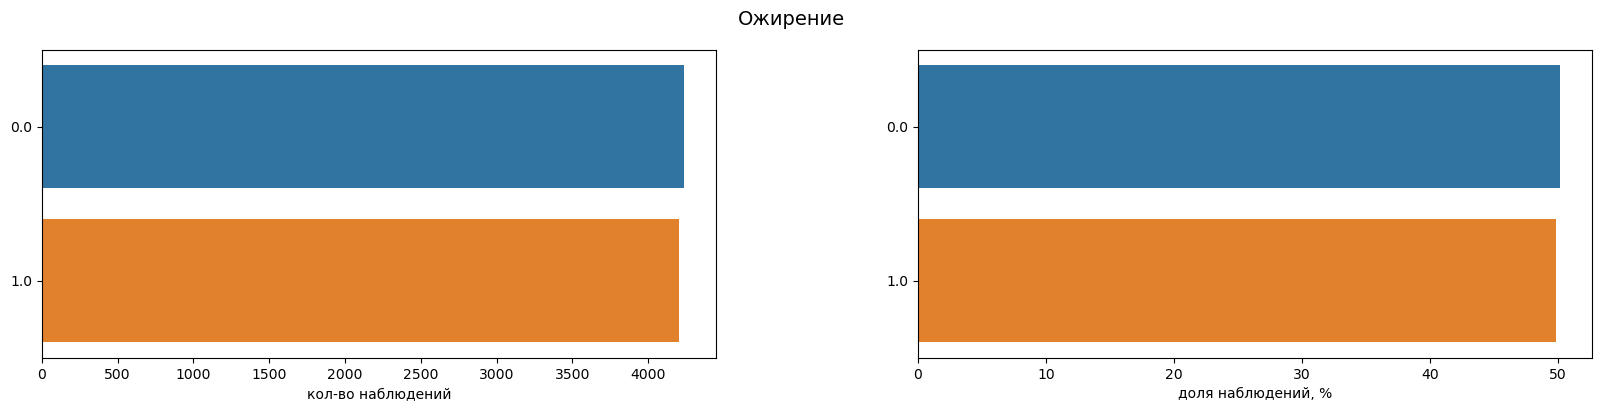

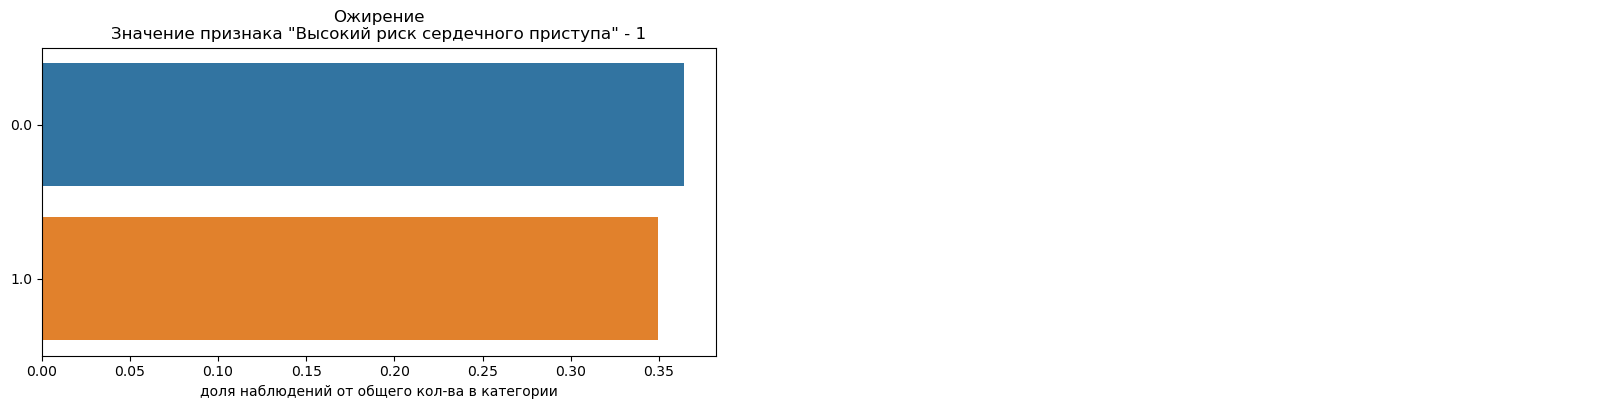

In [69]:
initial_data_analisys_category(df_main, 'obesity', target_column = 'heart_attack_risk_(binary)', target_value = 1)

In [70]:
df_main['obesity'] = df_main['obesity'].astype('int')
float_to_int_columns.append('obesity')
category_columns.append('obesity')

**Вывод:** Высокий риск сердечного присупа встречается реже у пациентов с ожирением, чем без него.

**Тестовая выборка**

Ожирение - количество значений



obesity
1.0    483
0.0    452
Name: obesity, dtype: int64

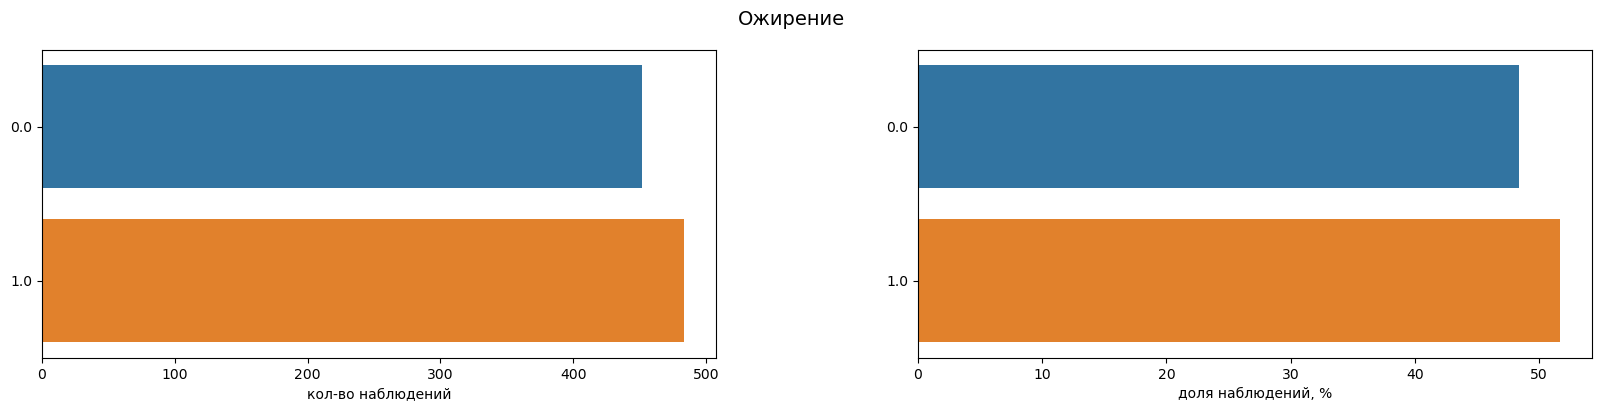

In [71]:
initial_data_analisys_category(df_test, 'obesity')

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.
#### Потребление алкоголя (`alcohol_consumption`)

**Тренирововчная выборка**

Потребление алкоголя - количество значений



alcohol_consumption
1.0    5082
0.0    3360
Name: alcohol_consumption, dtype: int64

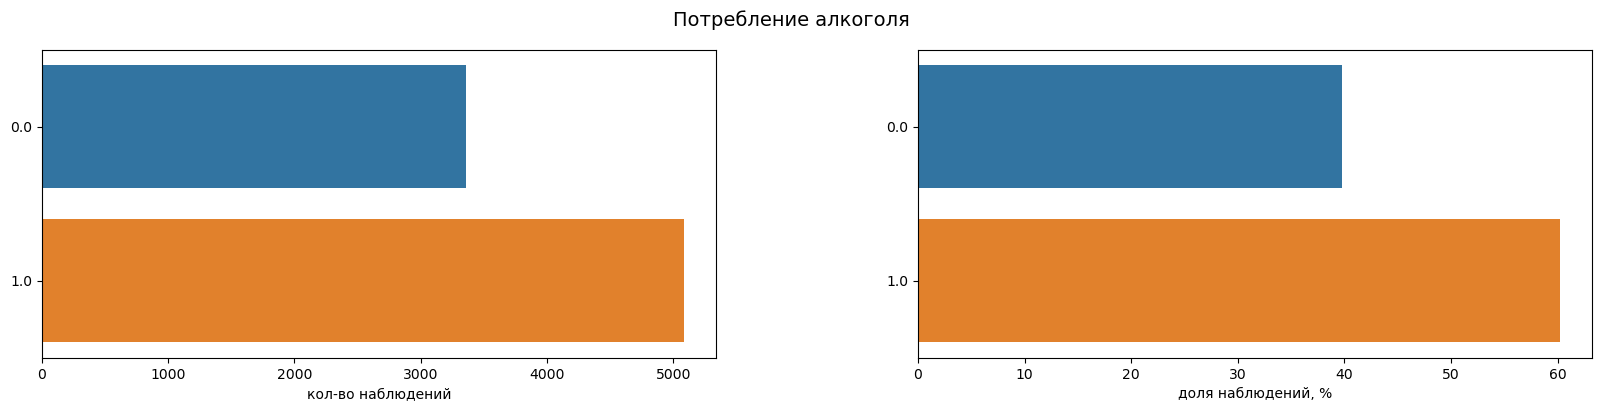

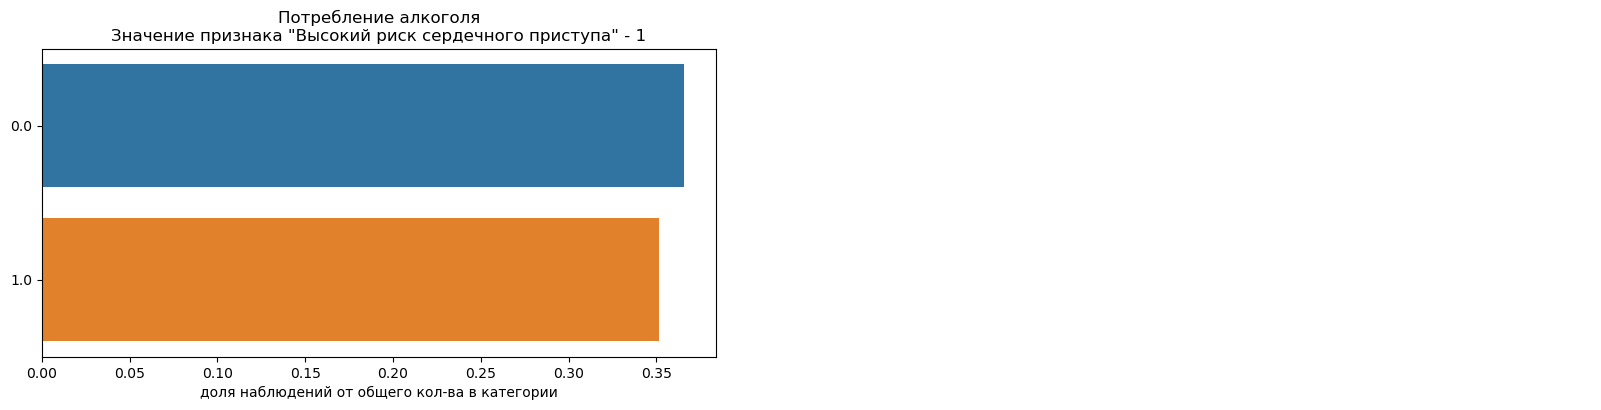

In [72]:
initial_data_analisys_category(df_main, 'alcohol_consumption', target_column = 'heart_attack_risk_(binary)', target_value = 1)

In [73]:
df_main['alcohol_consumption'] = df_main['alcohol_consumption'].astype('int')
float_to_int_columns.append('alcohol_consumption')
category_columns.append('alcohol_consumption')

**Вывод:** Высокий риск сердечного присупа встречается реже у пациентов с ожирением, чем без него.

**Тестовая выборка**

Потребление алкоголя - количество значений



alcohol_consumption
1.0    546
0.0    389
Name: alcohol_consumption, dtype: int64

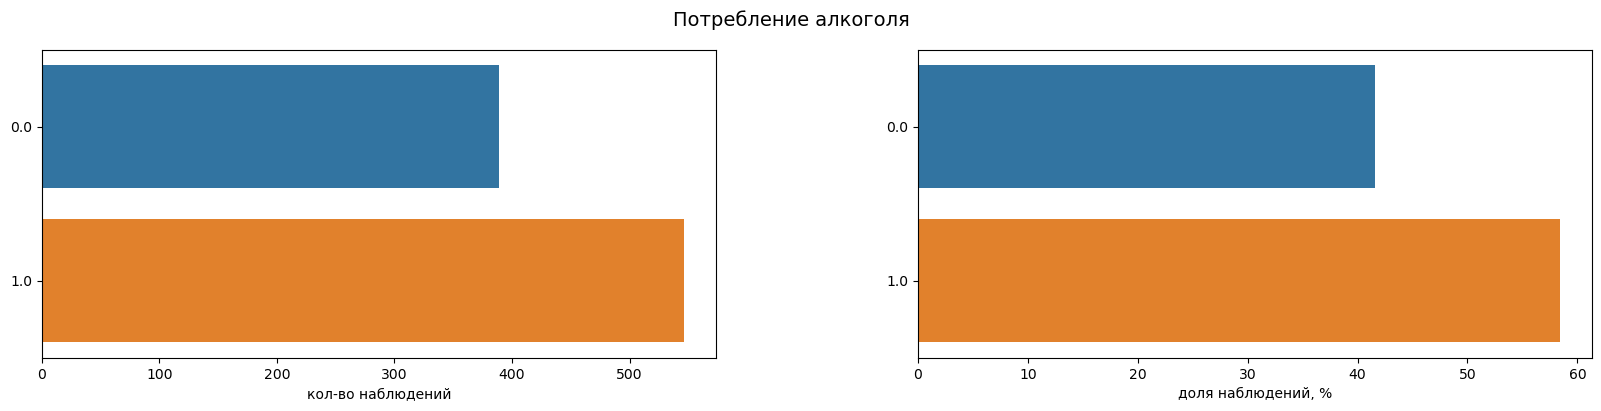

In [74]:
initial_data_analisys_category(df_test, 'alcohol_consumption')

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.

#### Диета (`diet`)

**Тренирововчная выборка**

Диета - количество значений



diet
1    2863
2    2796
0    2783
Name: diet, dtype: int64

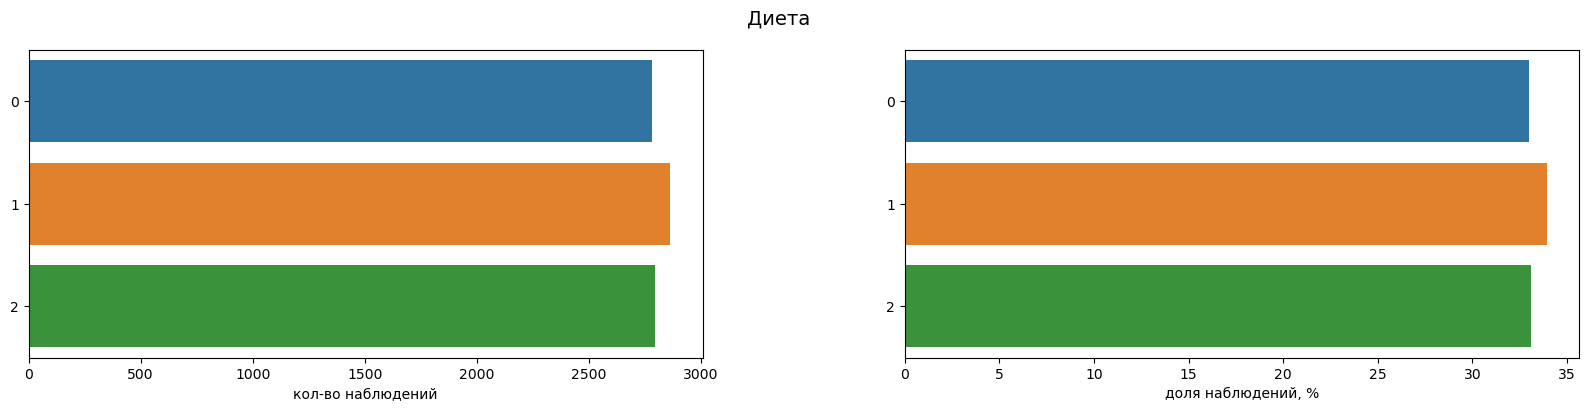

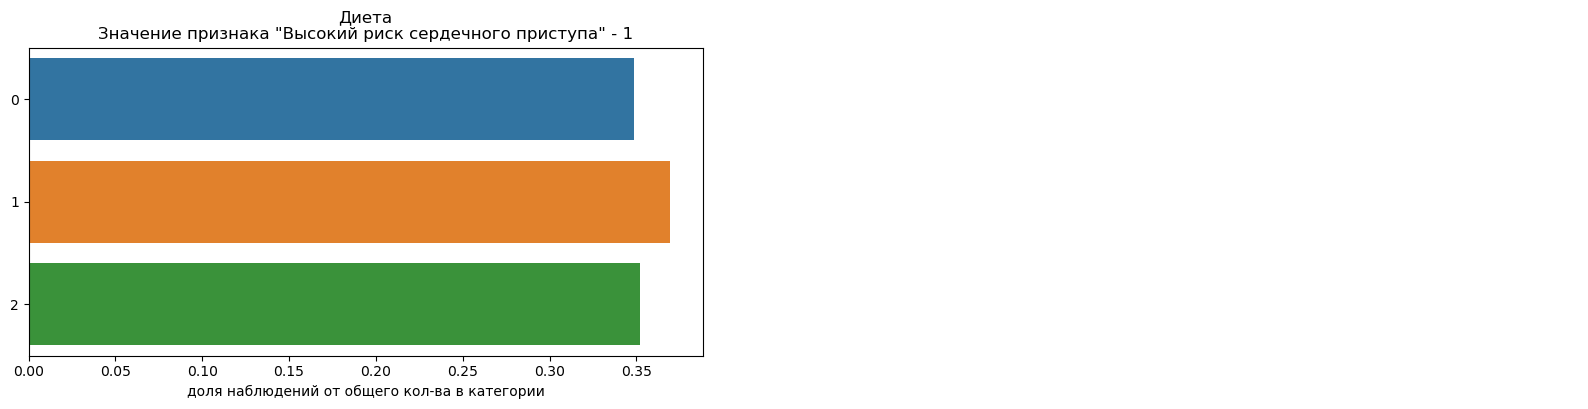

In [75]:
initial_data_analisys_category(df_main, 'diet', target_column = 'heart_attack_risk_(binary)', target_value = 1)

In [76]:
df_main['diet'] = df_main['diet'].astype('int')
float_to_int_columns.append('diet')
category_columns.append('diet')

**Вывод:** Высокий риск сердечного присупа встречается чаще у пациентов, придерживающихся диеты 1.

**Тестовая выборка**

Диета - количество значений



diet
0    322
2    312
1    301
3     31
Name: diet, dtype: int64

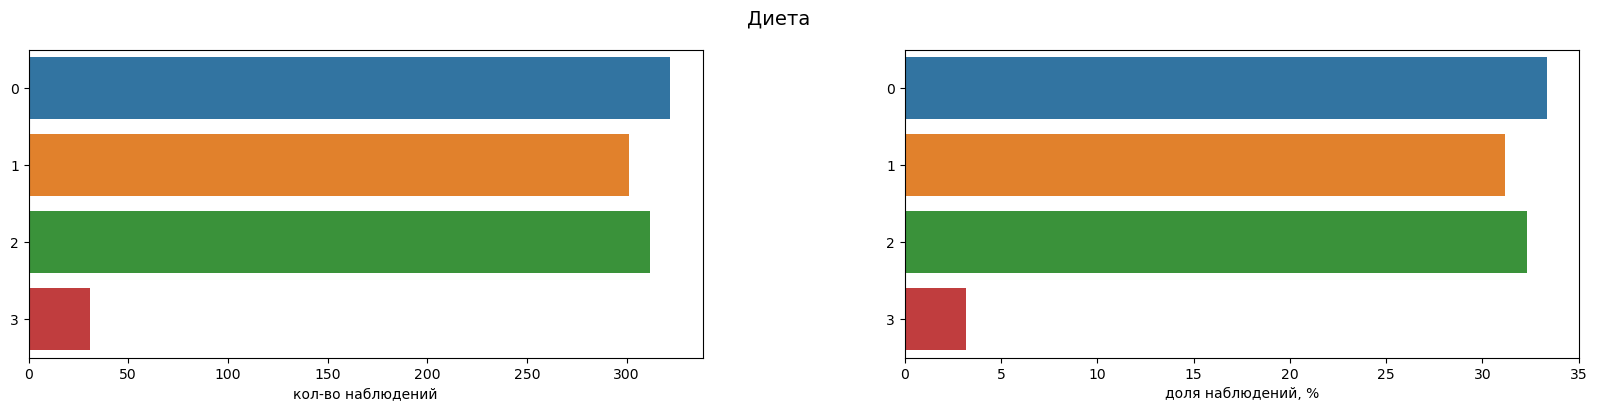

In [77]:
initial_data_analisys_category(df_test, 'diet')

**Вывод**: В тестовой выборке есть категория, которой нет в тренировочной выборке.

#### Предшествующие проблемы с сердцем (`previous_heart_problems`)

**Тренирововчная выборка**

Ранние проблемы с сердцем - количество значений



previous_heart_problems
0.0    4260
1.0    4182
Name: previous_heart_problems, dtype: int64

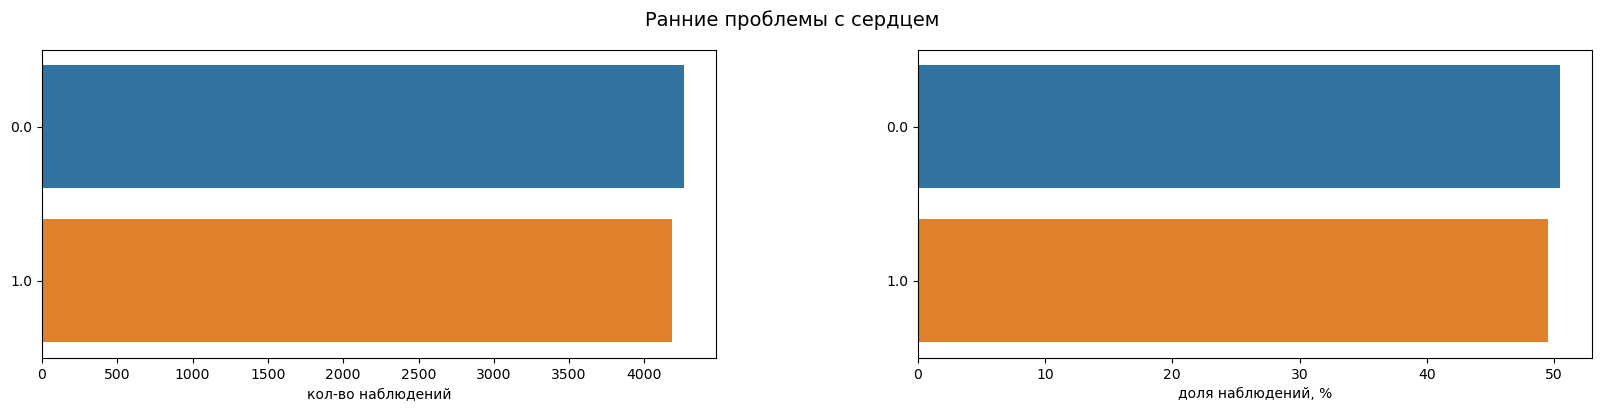

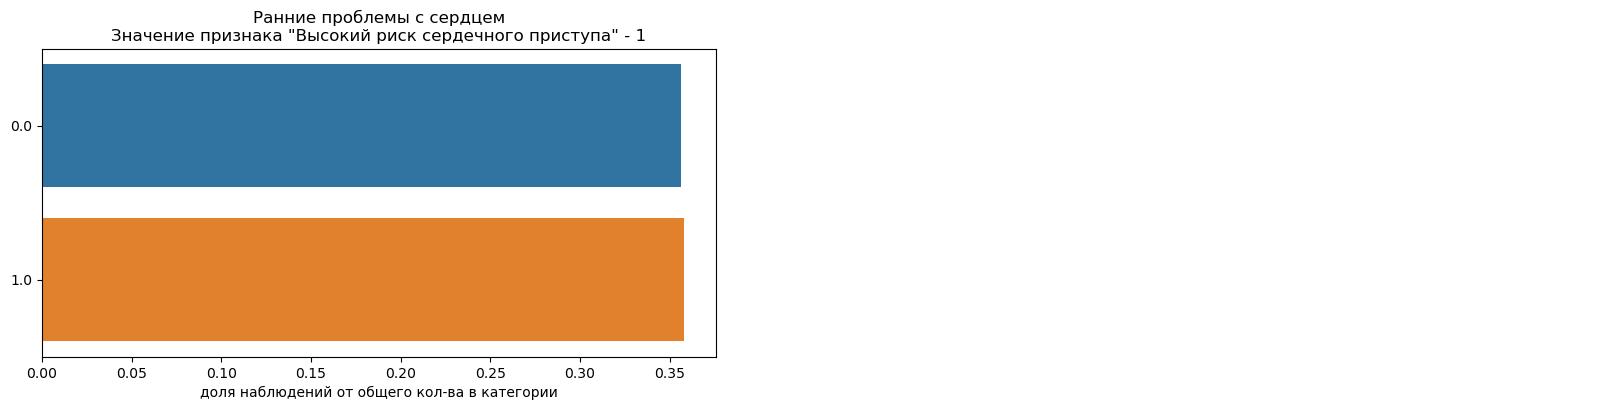

In [78]:
initial_data_analisys_category(df_main, 'previous_heart_problems', target_column = 'heart_attack_risk_(binary)', target_value = 1)

In [79]:
df_main['previous_heart_problems'] = df_main['previous_heart_problems'].astype('int')
float_to_int_columns.append('previous_heart_problems')
category_columns.append('previous_heart_problems')

**Вывод:** Высокий риск сердечного присупа одинаково часто встречается у пациентов, у которых ранее были и не было проблем с сердцем.

**Тестовая выборка**

Ранние проблемы с сердцем - количество значений



previous_heart_problems
0.0    473
1.0    462
Name: previous_heart_problems, dtype: int64

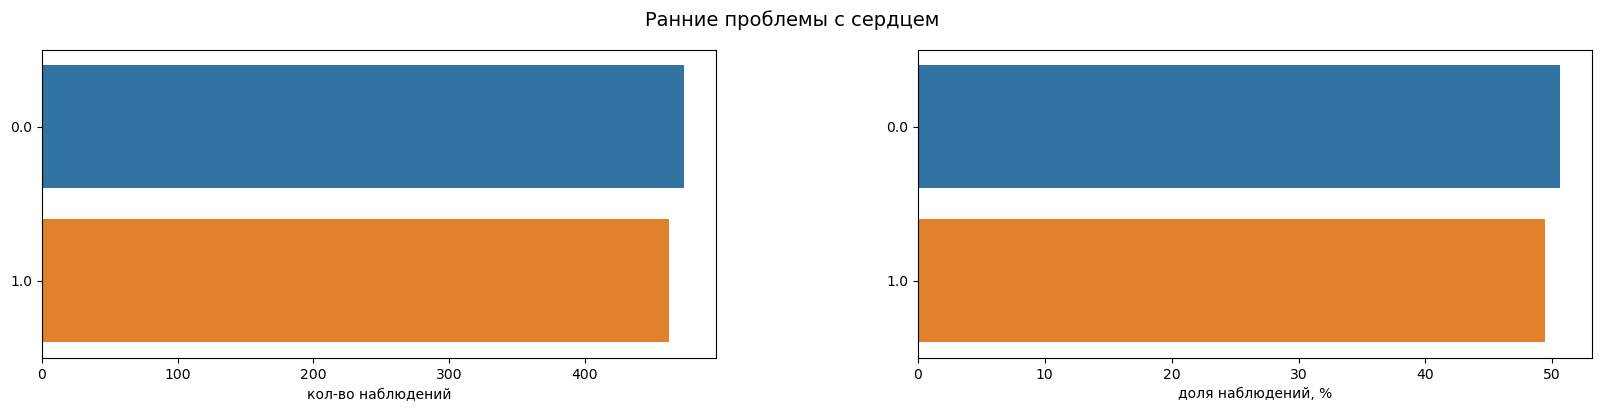

In [80]:
initial_data_analisys_category(df_test, 'previous_heart_problems')

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.

#### Прием препаратов (`medication_use`)

**Тренирововчная выборка**

Прием препаратов - количество значений



medication_use
1.0    4231
0.0    4211
Name: medication_use, dtype: int64

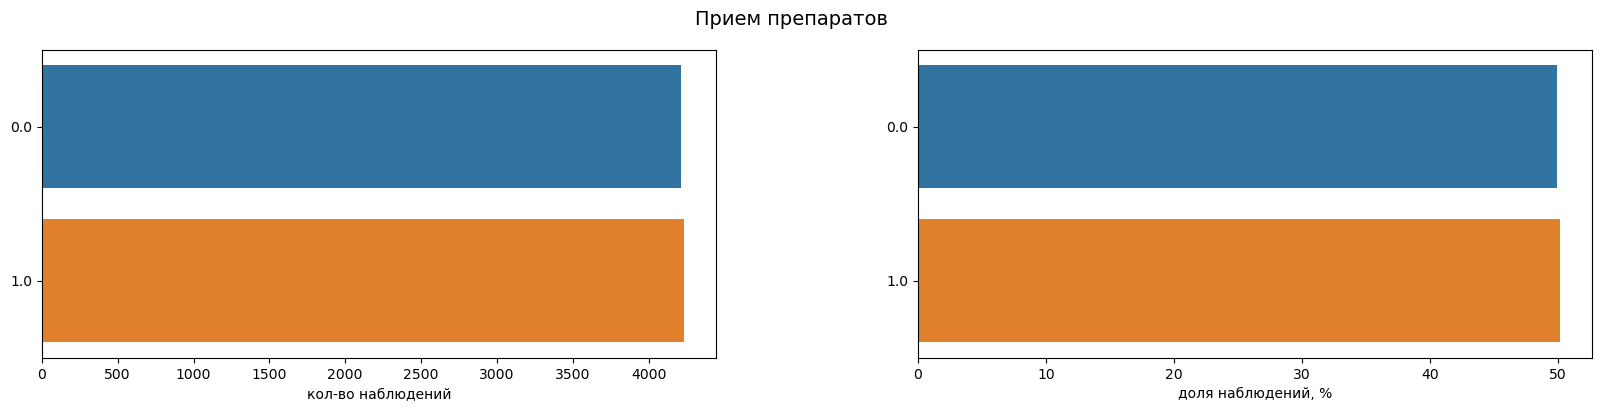

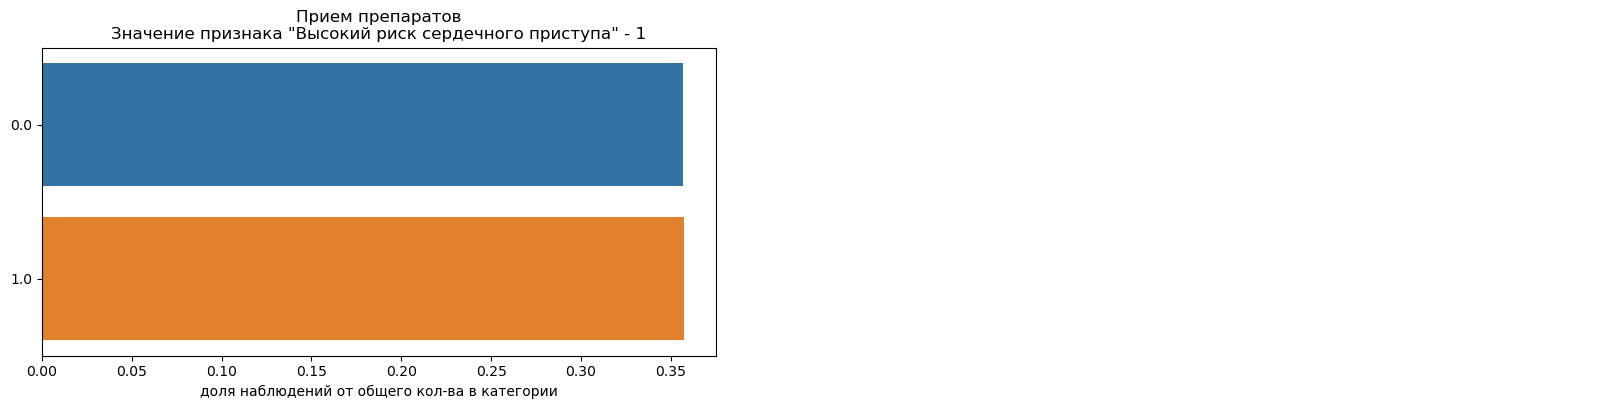

In [81]:
initial_data_analisys_category(df_main, 'medication_use', target_column = 'heart_attack_risk_(binary)', target_value = 1)

In [82]:
df_main['medication_use'] = df_main['medication_use'].astype('int')
float_to_int_columns.append('medication_use')
category_columns.append('medication_use')

**Вывод:** Высокий риск сердечного присупа одинаково часто встречается у пациентов, которые принемают и не принимают лекарства.

**Тестовая выборка**

Прием препаратов - количество значений



medication_use
0.0    478
1.0    457
Name: medication_use, dtype: int64

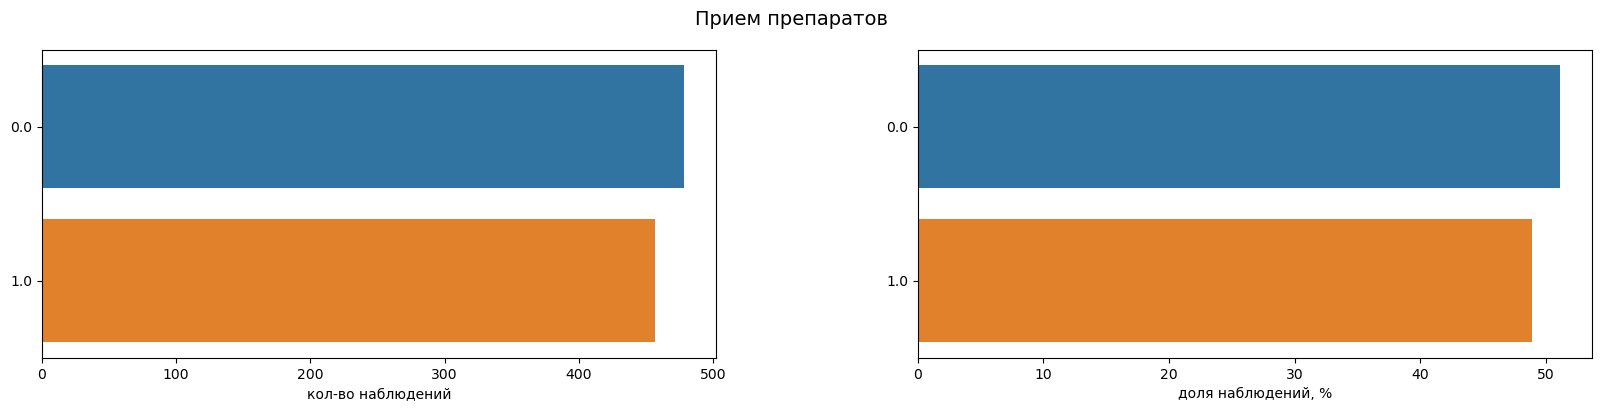

In [83]:
initial_data_analisys_category(df_test, 'medication_use')

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.

#### Уровень стресса (`stress_level`)

**Тренирововчная выборка**

Уровень стресса - количество значений



stress_level
7.0     869
4.0     857
2.0     854
9.0     852
8.0     844
3.0     841
1.0     840
5.0     833
6.0     828
10.0    824
Name: stress_level, dtype: int64

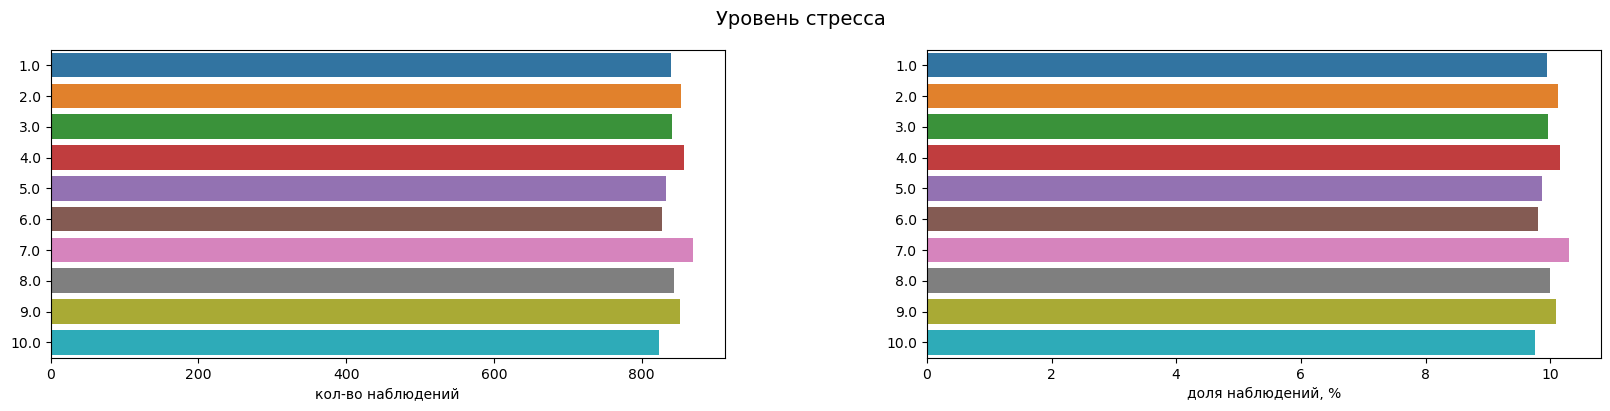

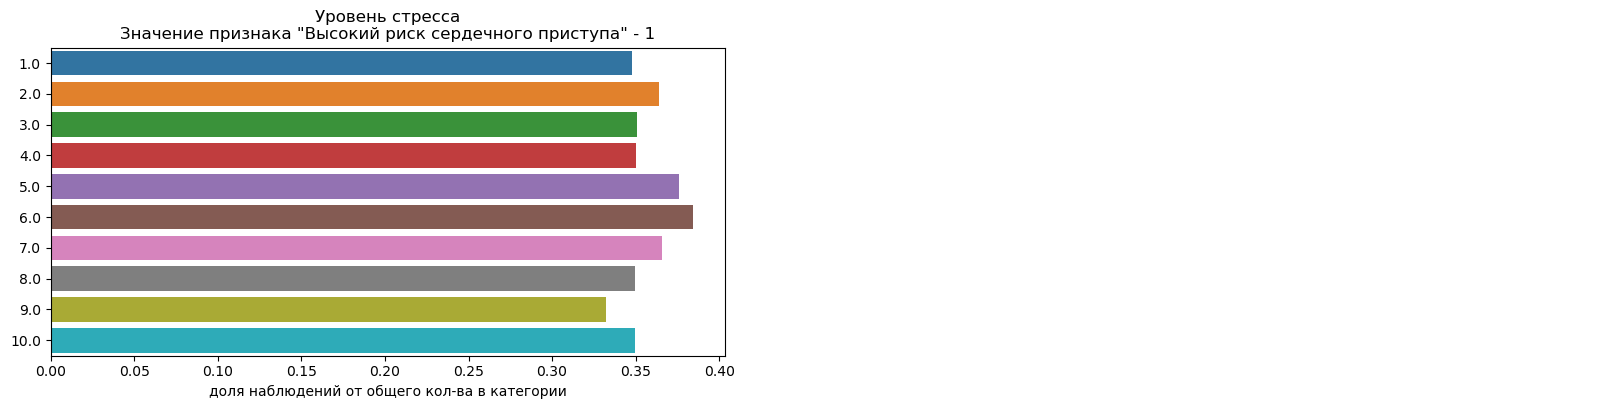

In [84]:
initial_data_analisys_category(df_main, 'stress_level', target_column = 'heart_attack_risk_(binary)', target_value = 1)

In [85]:
df_main['stress_level'] = df_main['stress_level'].astype('int')
float_to_int_columns.append('stress_level')
numeric_columns.append('stress_level')

**Вывод:** Не наблюдается выраженного тренда на снижение/увеличение риска сердечного приступа при снижении/увеличении уровня стресса.

**Тестовая выборка**

Уровень стресса - количество значений



stress_level
2.0     107
4.0     103
1.0     100
8.0      99
5.0      95
7.0      95
3.0      87
6.0      86
10.0     84
9.0      79
Name: stress_level, dtype: int64

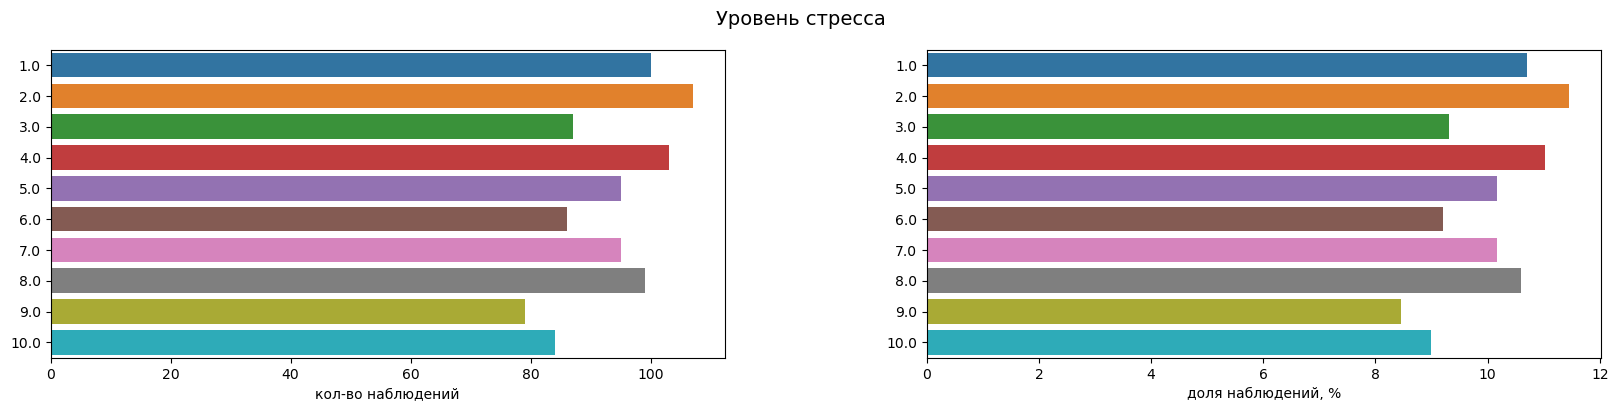

In [86]:
initial_data_analisys_category(df_test, 'stress_level')

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.

#### Физическая активность (`physical_activity_days_per_week`)

**Тренирововчная выборка**

Физическая активность (д/неделю) - количество значений



physical_activity_days_per_week
3.0    1091
2.0    1087
1.0    1069
7.0    1063
6.0    1055
5.0    1046
4.0    1025
0.0    1006
Name: physical_activity_days_per_week, dtype: int64

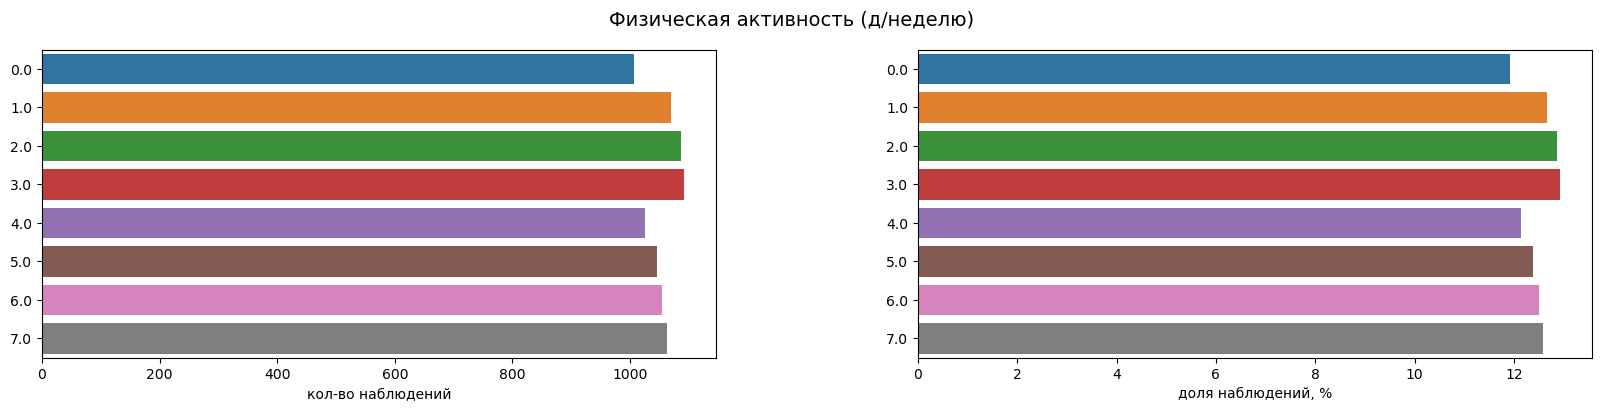

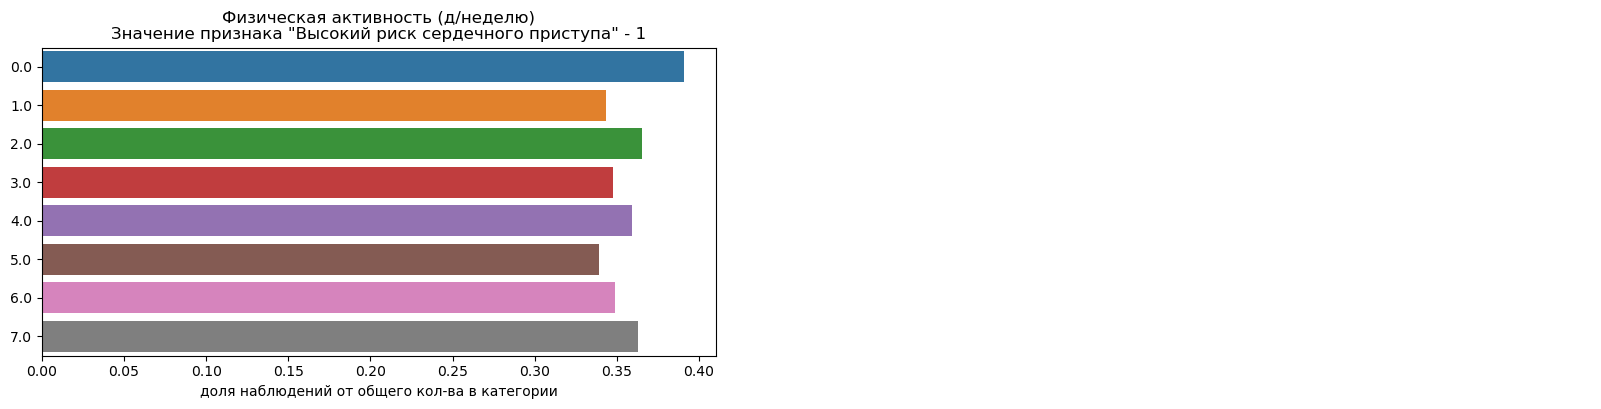

In [87]:
initial_data_analisys_category(df_main, 'physical_activity_days_per_week', target_column = 'heart_attack_risk_(binary)', target_value = 1)

In [88]:
df_main['physical_activity_days_per_week'] = df_main['physical_activity_days_per_week'].astype('int')
float_to_int_columns.append('physical_activity_days_per_week')
numeric_columns.append('physical_activity_days_per_week')

**Вывод:** Не наблюдается выраженного тренда на снижение/увеличение риска сердечного приступа при снижении/увеличении физической активности.

**Тестовая выборка**

Физическая активность (д/неделю) - количество значений



physical_activity_days_per_week
1.0    135
4.0    125
7.0    125
3.0    117
2.0    115
0.0    113
6.0    104
5.0    101
Name: physical_activity_days_per_week, dtype: int64

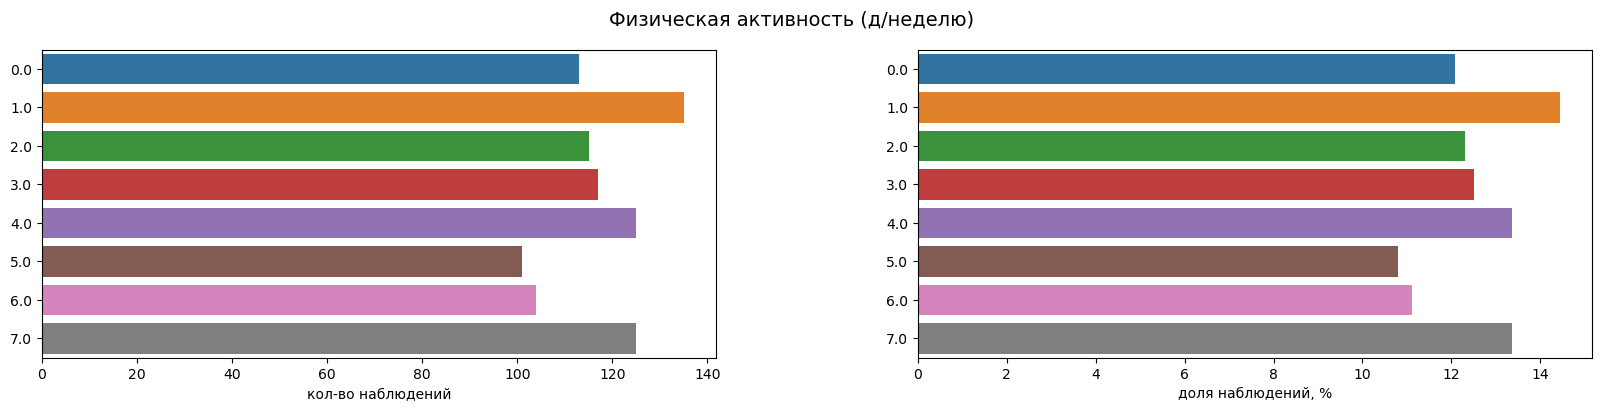

In [89]:
initial_data_analisys_category(df_test, 'physical_activity_days_per_week')

**Вывод**: данные в тренировочной и тестовой выборке сопоставимы.

#### Сон (`sleep_hours_per_day`)

**Тренирововчная выборка**

Сон (ч/день) - количество значений



sleep_hours_per_day
1.000000    1261
0.666667    1252
0.166667    1231
0.500000    1208
0.333333    1200
0.000000    1153
0.833333    1137
Name: sleep_hours_per_day, dtype: int64

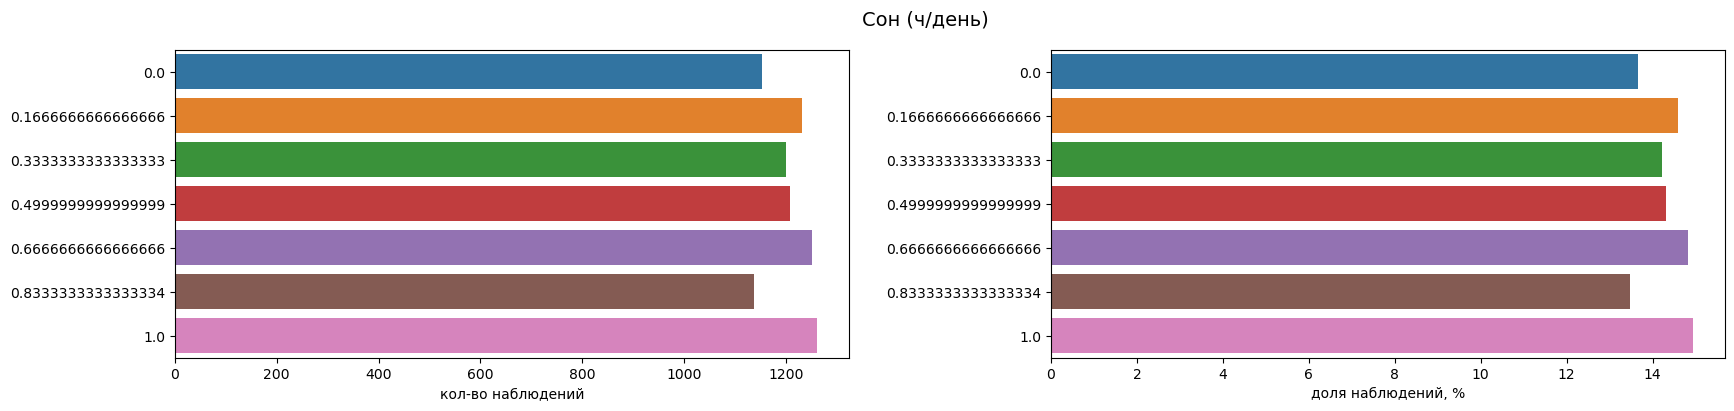

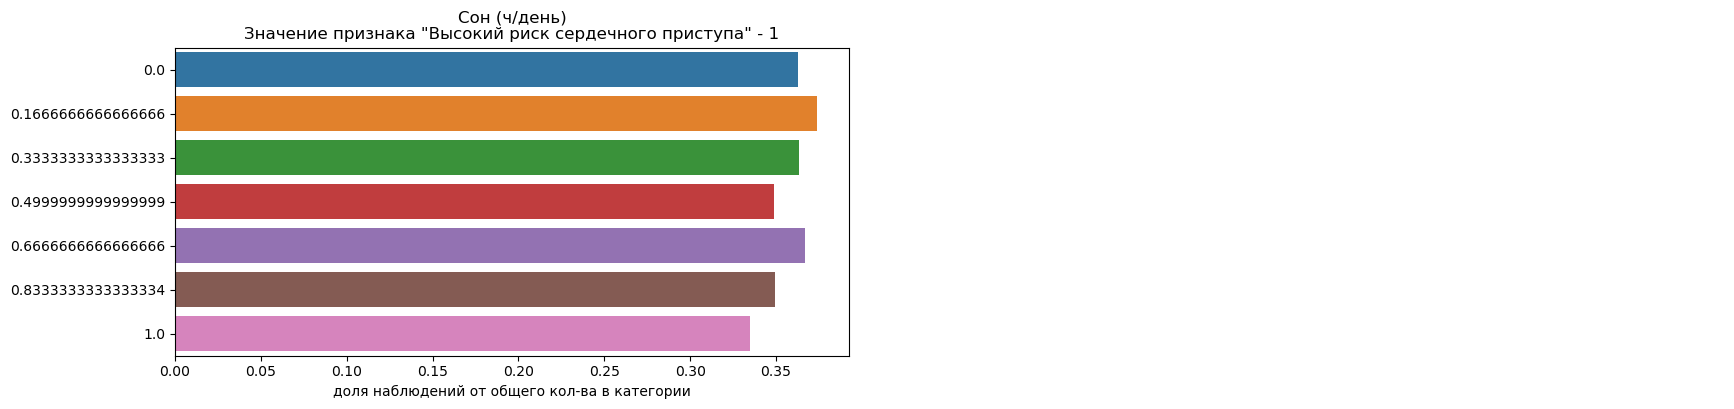

In [90]:
initial_data_analisys_category(df_main, 'sleep_hours_per_day', target_column = 'heart_attack_risk_(binary)', target_value = 1)

In [91]:
numeric_columns.append('sleep_hours_per_day')

**Вывод:** Не наблюдается выраженного тренда на снижение/увеличение риска сердечного приступа при снижении/увеличении продолжительности сна.

**Тестовая выборка**

Сон (ч/день) - количество значений



sleep_hours_per_day
0.500000    144
0.666667    144
1.000000    142
0.333333    136
0.166667    130
0.833333    123
0.000000    116
0.504621     31
Name: sleep_hours_per_day, dtype: int64

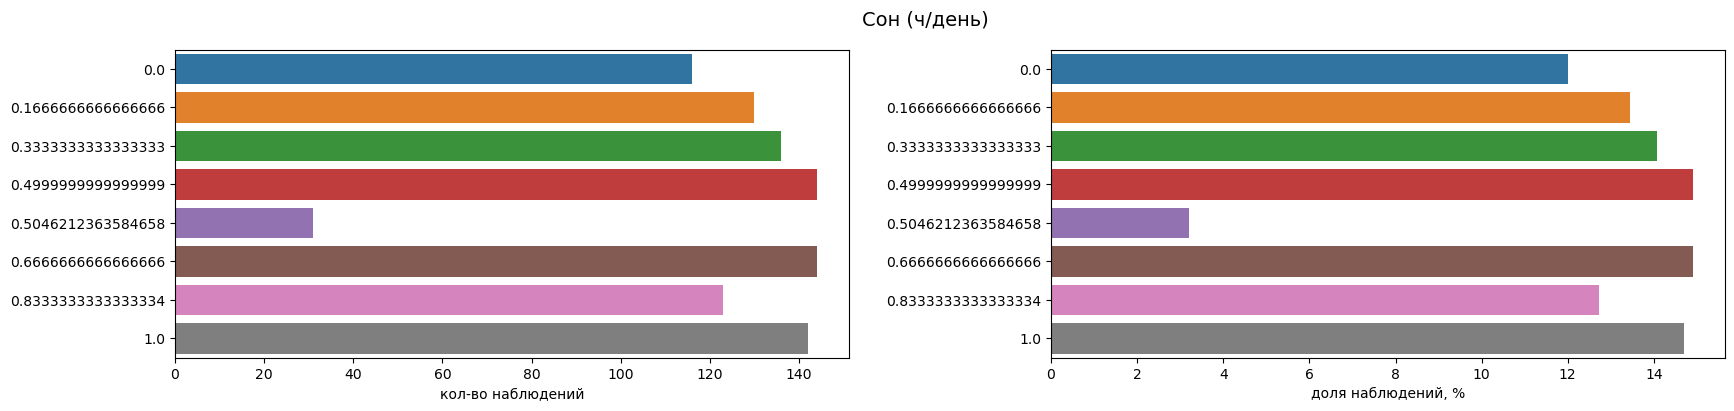

In [92]:
initial_data_analisys_category(df_test, 'sleep_hours_per_day')

**Вывод**: в тестовой выборке наблюдается дополнительное значение продолжительности сна.

#### Пол (`gender`)

**Тренирововчная выборка**

Пол - количество значений



gender
Male      5882
Female    2560
Name: gender, dtype: int64

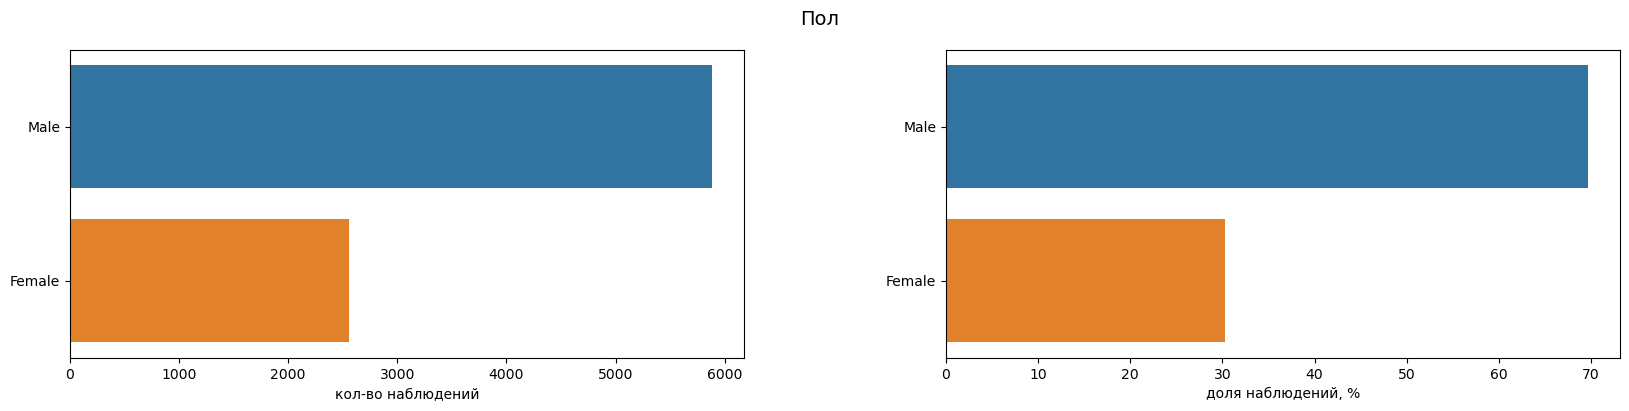

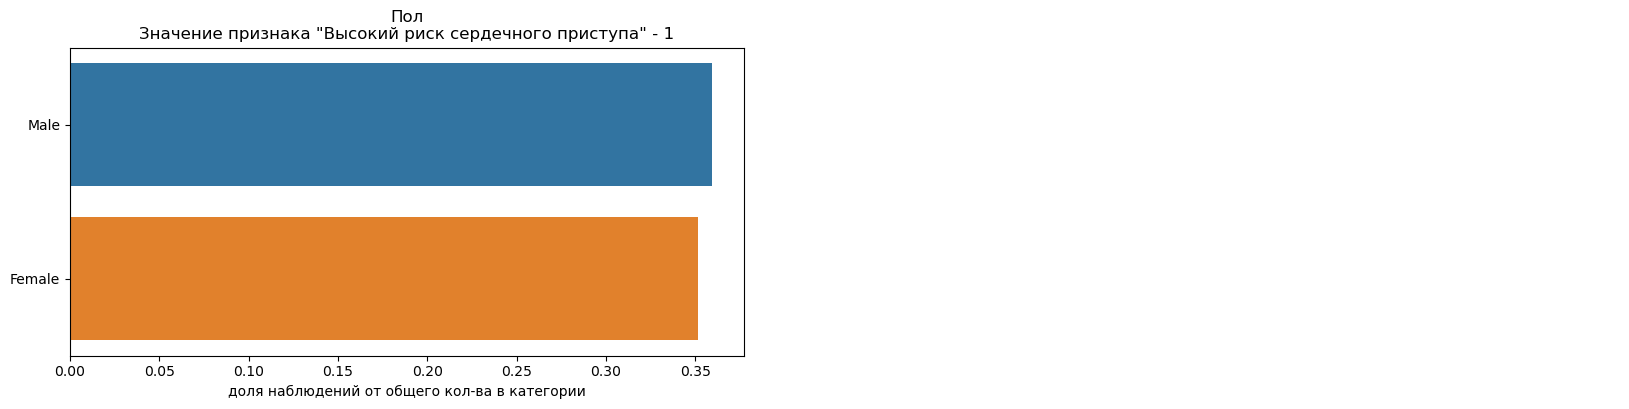

In [93]:
initial_data_analisys_category(df_main, 'gender', target_column = 'heart_attack_risk_(binary)', target_value = 1)

In [94]:
category_columns.append('gender')

**Вывод:** Высокий риск сердечных приступов может встречаться у мужчин чаще, чем у женщин. В выборке преобладают мужчины.

**Тестовая выборка**

Пол - количество значений



gender
Male      650
Female    285
1.0        22
0.0         9
Name: gender, dtype: int64

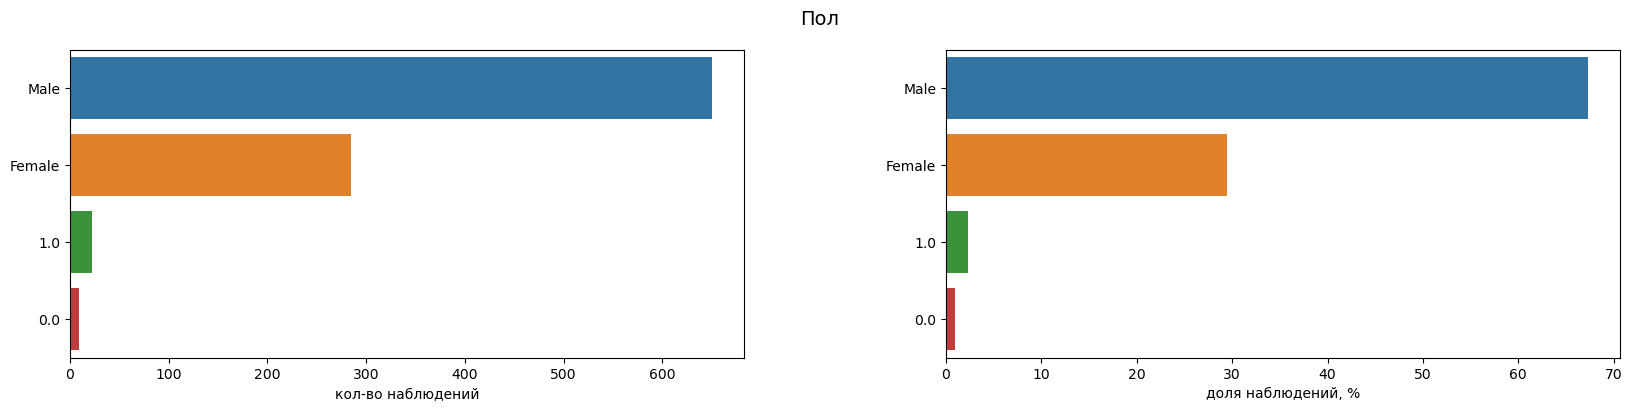

In [95]:
initial_data_analisys_category(df_test, 'gender')

**Вывод:** В тестовой выборке для части наблюдений пол закодирован цифрой. С учетом частоты нулей и единиц, а также с учетом того, что в аналагичных датасетах, найденных в открытых источниках мужской пол кодируется единицей, при обработке тестовых данных будем использовать функцию для перевода числовой кодировки к описанию.

In [96]:
def fill_gender(x):
    if x ==  'Male' or x =='Female':
        return x
    if x == 1:
        return 'Male'
    else:
        return 'Female'

In [97]:
print(numeric_columns)
print('Количество численных признаков: ', len(numeric_columns), '\n')
print(category_columns)
print('Количество категориальных признаков: ', len(category_columns), '\n')
print(float_to_int_columns)
print('Количество признаков, для которых требуется изменение типа данных: ', len(float_to_int_columns), '\n')

['age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', 'blood_sugar', 'ck-mb', 'troponin', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'stress_level', 'physical_activity_days_per_week', 'sleep_hours_per_day']
Количество численных признаков:  16 

['diabetes', 'smoking', 'family_history', 'obesity', 'alcohol_consumption', 'diet', 'previous_heart_problems', 'medication_use', 'gender']
Количество категориальных признаков:  9 

['diabetes', 'smoking', 'family_history', 'obesity', 'alcohol_consumption', 'diet', 'previous_heart_problems', 'medication_use', 'stress_level', 'physical_activity_days_per_week']
Количество признаков, для которых требуется изменение типа данных:  10 



## Корреляционный анализ

### Корреляция $\phi_k$

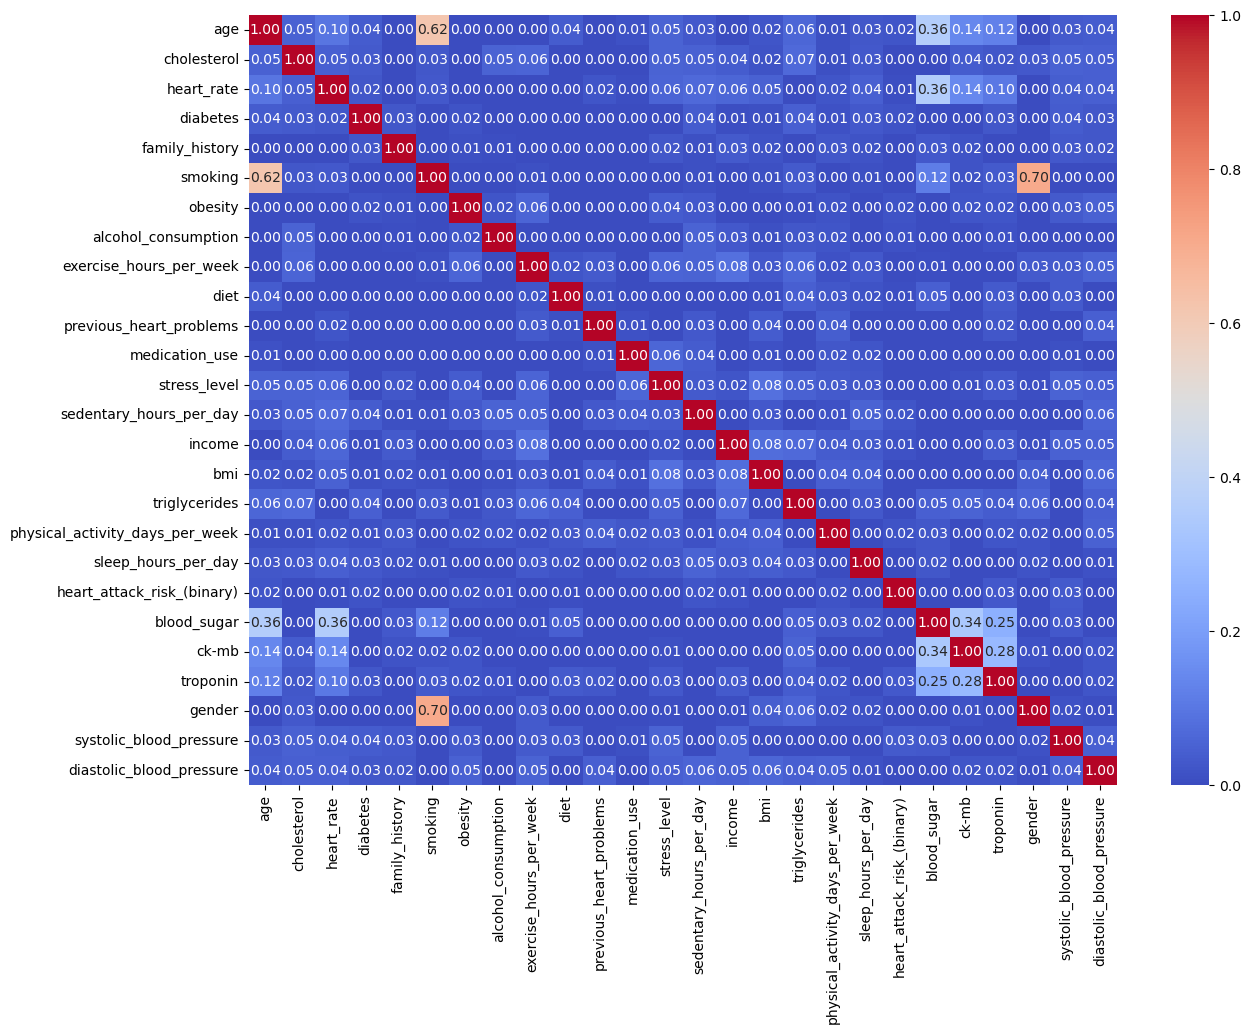

In [98]:
phi = df_main.drop('id', axis = 1).phik_matrix(
    interval_cols = [x for x in numeric_columns if x not in ['stress_level', 'physical_activity_days_per_week', 'sleep_hours_per_day']]
)
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(phi, annot=True, fmt='.2f', cmap='coolwarm', ax = ax);

**Выводы:** 
* Целевой признак не коррелирует с входными признаками.
* С учетом отсутствия выраженных зависимостей для обучения будем использовать модели kNN, дерево решений и градиентный бустинг.
* Наблюдается выраженная корреляция курения с полом и возрастом, что может ухудшать обучаемость модели при одновременном включении этих признаков.
* Наблюдается некоторая корреляция сахара в крови, креатинкиназы МВ  и тропонина, что может ухудшать обучаемость модели при одновременном включении этих признаков.
* С точки зрпения качества входных данных подозрительным кажется отсутствие корреляции
    * систолического и диастолического давления;
    * индекса массы тела, который рассчитывается через массу и рост, и ожирения.

### Дополнительные проверки

#### Систолическое и диастолическое давление

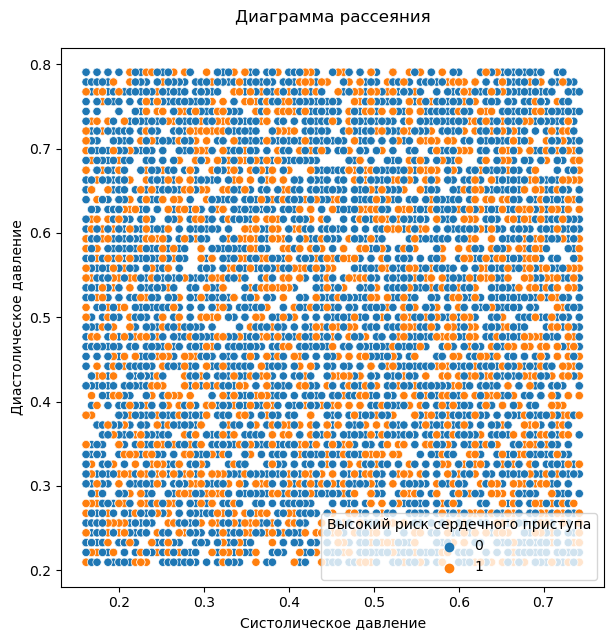

In [99]:
scatter_plot(x= 'systolic_blood_pressure', y='diastolic_blood_pressure', df=df_main, hue='heart_attack_risk_(binary)')

В наборе данных наблюдаются любые сочетания систолического и диастолического давления.

#### ИМТ и ожирение

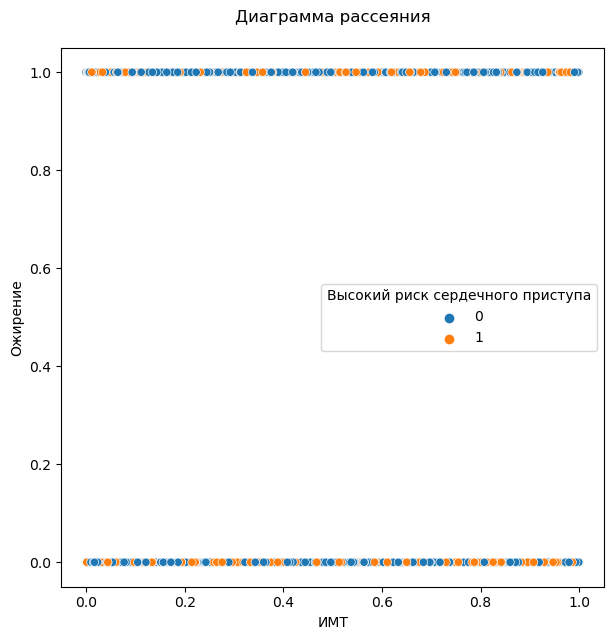

In [100]:
scatter_plot(x= 'bmi', y='obesity', df=df_main, hue='heart_attack_risk_(binary)')

Ожирение и его отсутствие при любых значениях индекса массы тела некорректно. Ожирение, как правило, определяется при ИМТ 30+, т.е. в данных должна наблюдаться грань, при которой признак ожирения переключается с 0 на 1. 

## Выбор оптимальной модели

### Выбор признаков для моделирования

При моделировании не будем учитывать следующие признаки:
* Высокая корреляция с другими признаками
    * `smoking`
    * `blood_sugar`
    * `ck-mb`
* Отсутствие влияния на целевой признак по результатам исследовательского и корреляционного анализа
    * `family_history`
    * `previous_heart_problems`
    * `medication_use`
* Подозрение на то, что данные не корректны
    * `diastolic_blood_pressure`
    * `obesity`

*Комментарий: признаки закомментированы в полном списке для оперативного обновления моделей при выборе иного подхода к отбору признаков*


In [101]:
selected_columns = [
      'age',
      'cholesterol',
      'heart_rate',
      'diabetes',
      #'family_history',
      #'smoking',
      #'obesity',
      'alcohol_consumption',
      'exercise_hours_per_week',
      'diet',
      #'previous_heart_problems',
      #'medication_use',
      'stress_level',
      'sedentary_hours_per_day',
      'income',
      'bmi',
      'triglycerides',
      'physical_activity_days_per_week',
      'sleep_hours_per_day',
      #'heart_attack_risk_(binary)',
      #'blood_sugar',
      #'ck-mb',
      'troponin',
      'gender',
      'systolic_blood_pressure',
      #'diastolic_blood_pressure',
      #'id'
]

In [102]:
df_sample = df_main.loc[:, selected_columns + ['heart_attack_risk_(binary)']].drop_duplicates()
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8416 entries, 0 to 8684
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8416 non-null   float64
 1   cholesterol                      8416 non-null   float64
 2   heart_rate                       8416 non-null   float64
 3   diabetes                         8416 non-null   int64  
 4   alcohol_consumption              8416 non-null   int64  
 5   exercise_hours_per_week          8416 non-null   float64
 6   diet                             8416 non-null   int64  
 7   stress_level                     8416 non-null   int64  
 8   sedentary_hours_per_day          8416 non-null   float64
 9   income                           8416 non-null   float64
 10  bmi                              8416 non-null   float64
 11  triglycerides                    8416 non-null   float64
 12  physical_activity_da

### Обучающая и валидационная выборка

In [103]:
X_train, X_valid, y_train, y_valid = train_test_split(
    df_sample.drop(['heart_attack_risk_(binary)'], axis=1),
    df_sample['heart_attack_risk_(binary)'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_sample['heart_attack_risk_(binary)']
)

### Предварительная обработка данных

In [104]:
ohe_columns = list(set(['gender']) & set(selected_columns))

cat_columns = list(set(category_columns) & set(selected_columns))
try:
    cat_columns.remove('gender')
except:
    passthrough

num_columns = list(set(numeric_columns) & set(selected_columns))

In [105]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [106]:
num_pipe = Pipeline(
    [
        ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
    ]
)

In [107]:
cat_pipe = Pipeline(
    [
        ('simpleImputer_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ]
)

In [108]:
data_transformer = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns),
     ('cat', cat_pipe, cat_columns)
    ], 
    remainder='passthrough'
)

In [109]:
data_preprocessor = Pipeline(
    [('transformer', data_transformer),
     ('select', SelectKBest(score_func = f_classif, k=3))
    ]
)

### Выбор целевой метрики
Будем рассматривать ряд метрик.

In [110]:
scoring_cls = {
    'roc_auc_score': 'roc_auc',
    'accuracy_score': 'accuracy',
    'f1_score': 'f1',
    'recall_score' : 'recall',
    'precision_score' : 'precision'
}

В целях минимизации ложноотрицательных предсказани в качестве целевой метрики будем использовать recall, т.к. предполагается что пационты с предсказанным высоким риском сердечного приступа будут направлены на дополнительное обследование, и важно не упускать таких пациентов.

In [111]:
target_score = 'recall_score'

### Модель kNN

#### Обучение модели

In [112]:
pipe_knn = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models',  KNeighborsClassifier())
])

In [113]:
param_grid_knn = [
    {
        'models__n_neighbors': range(2, 10),
        'preprocessor__select' : [SelectKBest()],
        'preprocessor__select__score_func' : [f_classif, mutual_info_classif],
        'preprocessor__select__k' : range(1,7)   
    },

    {
        'models__n_neighbors': range(2, 10),
        'preprocessor__select' : ['passthrough']
    },

]

In [114]:
start_time = time.time()

In [115]:
random_search_knn = RandomizedSearchCV(
    pipe_knn, 
    param_grid_knn,
    scoring = scoring_cls,
    refit = target_score,
    cv=5,
    n_iter=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search_knn.fit(X_train, y_train)
random_search_knn.best_estimator_

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   Pipeline(steps=[('simpleImputer_ohe',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['gender']),
                                                                  ('num',
                                                                   Pipeline(steps=[('simpleImputer_num',
                                                                                    SimpleIm...
                                                                    'systolic_blood_pressure',
                                                                    'sleep_hours_per_day',
                                                                    'age',
                                                                    'exercise_hours_per_week',
                                                                    'physical_activity_days_per_week',
                                                                    'cholesterol',
                                                                    'triglycerides',
                                                                    'income']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('simpleImputer_cat',
                                                                                    SimpleImputer(strategy='most_frequent'))]),
                                                                   ['alcohol_consumption',
                                                                    'diabetes',
                                                                    'diet'])])),
                                 ('select', SelectKBest(k=5))])),
                ('models', KNeighborsClassifier(n_neighbors=3))])

In [116]:
finish_time = time.time()

In [117]:
print(f'Выбор оптимальной модели занимает {round((finish_time - start_time) / 60, 1)} минут(ы)')

Выбор оптимальной модели занимает 0.2 минут(ы)


In [118]:
print(f'Значение целевой метрики на обучающей выборке {random_search_knn.best_score_:.2f}')
print(f'Значение метрики на тестовой выборке {recall_score(y_valid, random_search_knn.predict(X_valid)):.2f}')

Значение целевой метрики на обучающей выборке 0.33
Значение метрики на тестовой выборке 0.34


#### Значимые признаки

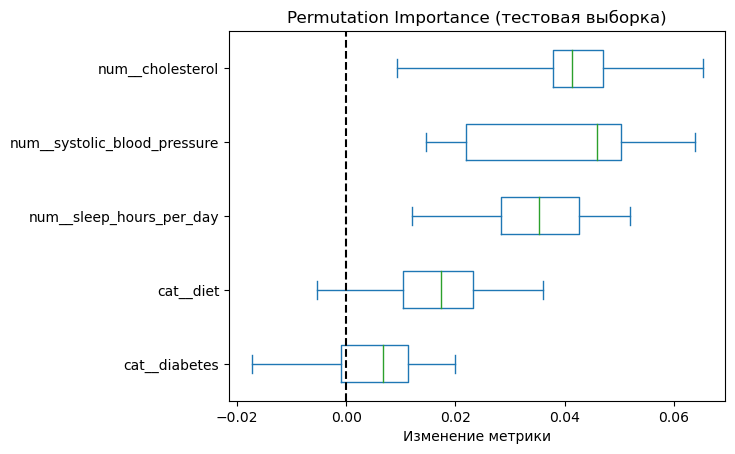

In [119]:
check_importance(search_result = random_search_knn, X_test = X_valid, y_test = y_valid, scoring = 'recall')

#### Выбор порога классификации

In [120]:
precision, recall, thresholds = precision_recall_curve(y_valid, random_search_knn.predict_proba(X_valid)[:,1])
pd.DataFrame({'thresholds' : thresholds,
              'recall' : recall[:-1],
              'precision' : precision[:-1]})

,thresholds,recall,precision
0,0.000000,1.000000,0.356939
1,0.333333,0.743009,0.371257
2,0.666667,0.340879,0.392638
3,1.000000,0.081225,0.455224


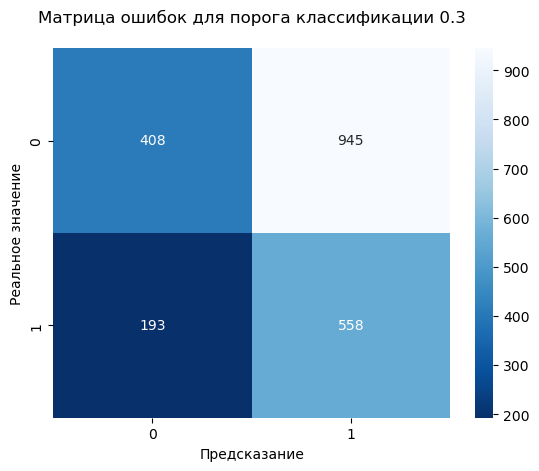

accuracy = 0.4591254752851711
precision = 0.3712574850299401
recall = 0.7430093209054593


In [121]:
view_metrics_for_threshold(random_search_knn.predict_proba(X_valid)[:,1], 0.3, y_valid)

#### Дополнительная информация

In [122]:
models_knn = pd.DataFrame(random_search_knn.cv_results_)

In [123]:
models_knn.loc[:, [
    'mean_fit_time',
    'mean_test_f1_score',
    'mean_test_roc_auc_score',
    'mean_test_accuracy_score',
    'mean_test_recall_score',
    'mean_test_precision_score',
]].sort_values(by = 'mean_test_' + target_score, ascending = False).head()

,mean_fit_time,mean_test_f1_score,mean_test_roc_auc_score,mean_test_accuracy_score,mean_test_recall_score,mean_test_precision_score
97,0.018648,0.355297,0.522446,0.573357,0.329047,0.386719
26,0.241561,0.358472,0.531368,0.583334,0.326386,0.397979
54,0.246701,0.356018,0.532274,0.578102,0.326386,0.391922
10,0.022927,0.350712,0.514552,0.572245,0.323725,0.383064
91,0.241904,0.350197,0.523244,0.574939,0.320621,0.386028


### Модель Decision Tree

#### Обучение модели

In [124]:
pipe_dt = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models',  DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight = 'balanced'))
])

In [125]:
param_grid_dt = [
    {
        'models__max_depth': range(5, 20),
        'models__max_features': range(2, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__select' : ['passthrough'],   
    },
]

In [126]:
start_time = time.time()

In [127]:
random_search_dt = RandomizedSearchCV(
    pipe_dt, 
    param_grid_dt,
    scoring = scoring_cls,
    refit = target_score,
    cv=5,
    n_iter=150,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search_dt.fit(X_train, y_train)
random_search_dt.best_estimator_

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   Pipeline(steps=[('simpleImputer_ohe',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['gender']),
                                                                  ('num',
                                                                   Pipeline(steps=[('simpleImputer_num',
                                                                                    SimpleIm...
                                                                    'exercise_hours_per_week',
                                                                    'physical_activity_days_per_week',
                                                                    'cholesterol',
                                                                    'triglycerides',
                                                                    'income']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('simpleImputer_cat',
                                                                                    SimpleImputer(strategy='most_frequent'))]),
                                                                   ['alcohol_consumption',
                                                                    'diabetes',
                                                                    'diet'])])),
                                 ('select', 'passthrough')])),
                ('models',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                                        max_features=2, random_state=42))])

In [128]:
finish_time = time.time()
print(f'Выбор оптимальной модели занимает {round((finish_time - start_time) / 60, 1)} минут(ы)')

Выбор оптимальной модели занимает 0.1 минут(ы)


In [129]:
print(f'Значение целевой метрики на обучающей выборке {random_search_dt.best_score_:.2f}')
print(f'Значение метрики на тестовой выборке {recall_score(y_valid, random_search_dt.predict(X_valid)):.2f}')

Значение целевой метрики на обучающей выборке 0.61
Значение метрики на тестовой выборке 0.64


#### Значимые признаки

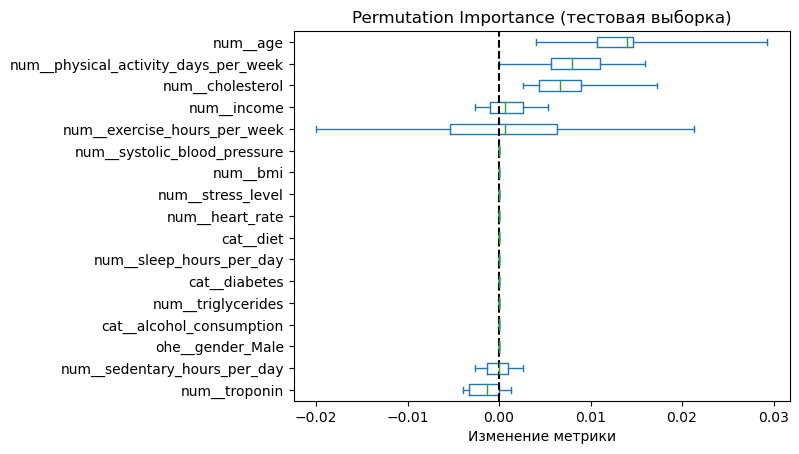

In [130]:
check_importance(search_result = random_search_dt, X_test = X_valid, y_test = y_valid, scoring = 'recall')

#### Выбор порога классификации

In [131]:
precision, recall, thresholds = precision_recall_curve(y_valid, random_search_dt.predict_proba(X_valid)[:,1])
pd.DataFrame({'thresholds' : thresholds,
              'recall' : recall[:-1],
              'precision' : precision[:-1]})



,thresholds,recall,precision
0,0.000000,1.000000,0.356939
1,0.328513,0.992011,0.356459
2,0.395487,0.969374,0.357038
3,0.472836,0.961385,0.355665
4,0.482232,0.824234,0.365839
5,0.512072,0.640479,0.363568
6,0.534388,0.077230,0.411348
7,0.545332,0.029294,0.440000
8,0.628532,0.029294,0.458333
9,0.843685,0.001332,0.200000


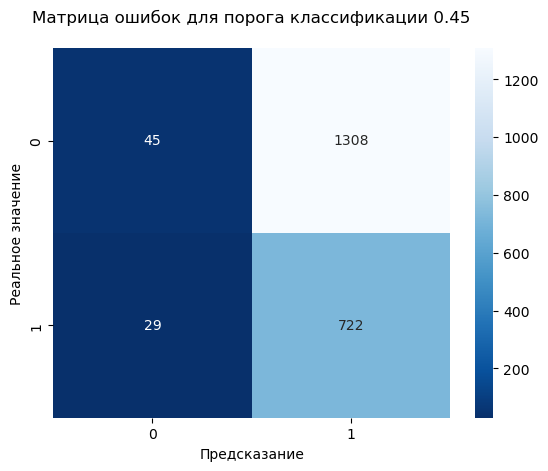

accuracy = 0.36454372623574144
precision = 0.3556650246305419
recall = 0.9613848202396804


In [132]:
view_metrics_for_threshold(random_search_dt.predict_proba(X_valid)[:,1], 0.45, y_valid)

#### Дополнительная информация

In [133]:
models_dt = pd.DataFrame(random_search_dt.cv_results_)

In [134]:
models_dt.loc[:, [
    'mean_fit_time',
    'mean_test_f1_score',
    'mean_test_roc_auc_score',
    'mean_test_accuracy_score',
    'mean_test_recall_score',
    'mean_test_precision_score',
]].sort_values(by = 'mean_test_' + target_score, ascending = False).head()

,mean_fit_time,mean_test_f1_score,mean_test_roc_auc_score,mean_test_accuracy_score,mean_test_recall_score,mean_test_precision_score
107,0.038279,0.444741,0.508197,0.477509,0.607539,0.363506
147,0.031050,0.451775,0.516178,0.485580,0.600443,0.366901
115,0.034912,0.452492,0.517682,0.492551,0.596009,0.370081
130,0.027251,0.440825,0.507850,0.478611,0.595565,0.357000
102,0.027905,0.439815,0.508981,0.478453,0.593348,0.356531


### Градиентный бустинг

#### Обучение модели

In [135]:
cat_features=list(set(category_columns) & set(selected_columns))
cat_features

['gender', 'alcohol_consumption', 'diabetes', 'diet']

In [136]:
model = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    iterations=3000,
    learning_rate=0.005,
    #eval_metric='Recall',
    auto_class_weights = 'Balanced',
    custom_loss=['AUC', 'Recall', 'Accuracy']
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid),
    verbose=False,
    plot=True 
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [137]:
print(f'Значение метрики на тренировочной выборке выборке {recall_score(y_train, model.predict(X_train)):.2f}')
print(f'Значение метрики на тестовой выборке {recall_score(y_valid, model.predict(X_valid)):.2f}')

Значение метрики на тренировочной выборке выборке 0.84
Значение метрики на тестовой выборке 0.48


#### Значимые признаки

In [138]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,bmi,9.152298
1,systolic_blood_pressure,8.850981
2,cholesterol,8.055295
3,income,8.006060
4,triglycerides,7.832272
5,age,7.455355
6,exercise_hours_per_week,7.339040
7,sedentary_hours_per_day,7.261012
8,heart_rate,6.235396
9,sleep_hours_per_day,5.936427


#### Выбор порога классификации

In [139]:
eval_pool = Pool(X_valid, y_valid, cat_features=cat_features)
print('Порог классификации для false negative rate 0.05: ', select_threshold(model=model, data=eval_pool, FNR=0.05))

Порог классификации для false negative rate 0.05:  0.4156208488680606


In [140]:
precision, recall, thresholds = precision_recall_curve(y_valid, model.predict_proba(X_valid)[:,1])
pd.DataFrame({'thresholds' : thresholds,
              'recall' : recall[:-1],
              'precision' : precision[:-1]})

,thresholds,recall,precision
0,0.241022,1.000000,0.356939
1,0.261990,1.000000,0.357109
2,0.282370,1.000000,0.357279
3,0.294913,1.000000,0.357449
4,0.298670,1.000000,0.357619
...,...,...,...
2098,0.666988,0.005326,0.800000
2099,0.672223,0.005326,1.000000
2100,0.684576,0.003995,1.000000
2101,0.687650,0.002663,1.000000


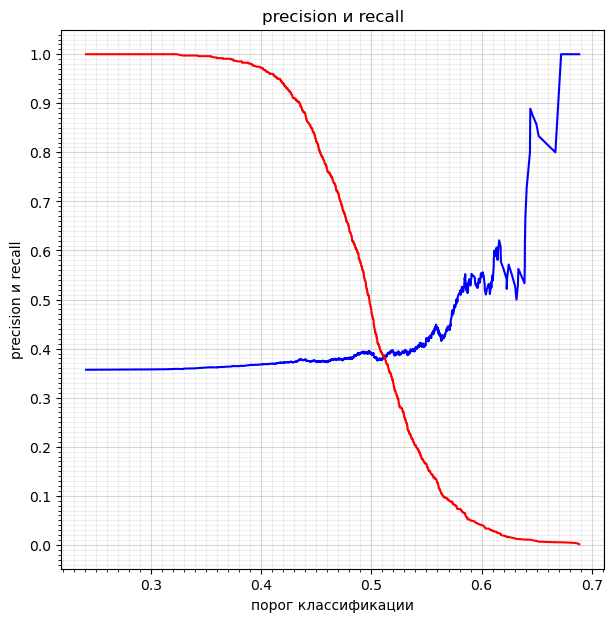

In [141]:
fig, axes = plt.subplots(figsize=(7,7))
axes.plot(thresholds, precision[:-1], color='blue')
axes.plot(thresholds, recall[:-1], color='red')
axes.set_title('precision и recall')
axes.set_ylabel('precision и recall')
axes.set_xlabel('порог классификации')
axes.xaxis.set_major_locator(MultipleLocator(0.1))
axes.yaxis.set_major_locator(MultipleLocator(0.1))
axes.xaxis.set_minor_locator(AutoMinorLocator(10))
axes.yaxis.set_minor_locator(AutoMinorLocator(10))
axes.grid(which='major', alpha = 0.5)
axes.grid(which='minor', alpha = 0.2)

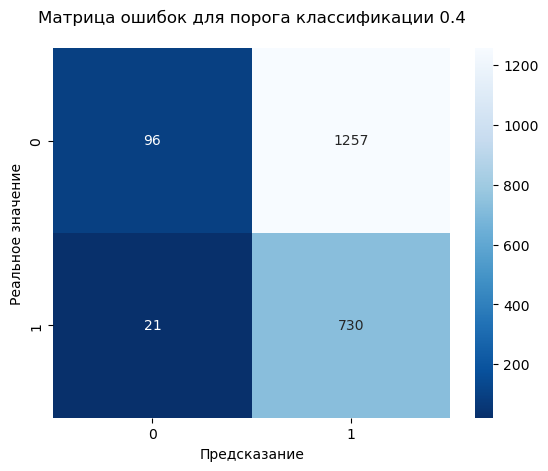

accuracy = 0.3925855513307985
precision = 0.36738802214393557
recall = 0.9720372836218375


In [142]:
view_metrics_for_threshold(model.predict_proba(X_valid)[:,1], 0.4, y_valid)

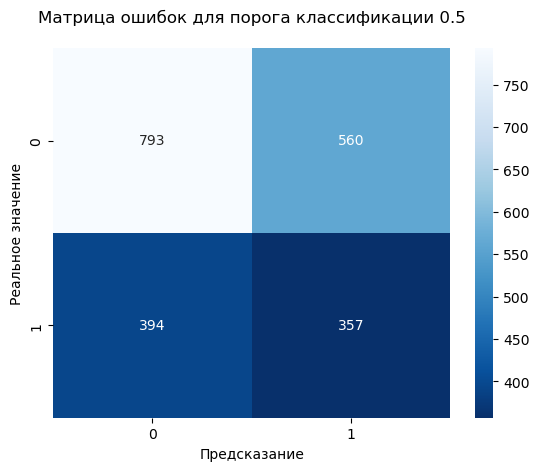

accuracy = 0.5465779467680608
precision = 0.3893129770992366
recall = 0.47536617842876167


In [143]:
view_metrics_for_threshold(model.predict_proba(X_valid)[:,1], 0.5, y_valid)

### Выбор модели

**Выводы:**
- модели обладают низким качеством, что может объясняться отсутствием выраженных зависимостей целевого признака от входящих признаков
- максимизация метрики recall приводит к низким значениям метрики accuracy и кране высокому количеству ложноположительных предсказаний
- в качестве оптимальной модели выберем модель, полученную с помощью градиентного бустинга с порогом классификации 0.4, т.к. она обеспечивает максимальное значение recall при сопоставимом уровне accuracy при сравнении с моделями kNN и деревом решений.

## Прогнозирование

### Подготовка тестовых данных

In [144]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              966 non-null    float64
 1   cholesterol                      966 non-null    float64
 2   heart_rate                       966 non-null    float64
 3   diabetes                         935 non-null    float64
 4   family_history                   935 non-null    float64
 5   smoking                          935 non-null    float64
 6   obesity                          935 non-null    float64
 7   alcohol_consumption              935 non-null    float64
 8   exercise_hours_per_week          966 non-null    float64
 9   diet                             966 non-null    int64  
 10  previous_heart_problems          935 non-null    float64
 11  medication_use                   935 non-null    float64
 12  stress_level          

**Кодировка пола**

In [145]:
df_test['gender'] = df_test['gender'].apply(fill_gender)
df_test['gender'].unique()

array(['Male', 'Female'], dtype=object)

**Отбор столбцов**

In [146]:
X_test = df_test.loc[:, selected_columns]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              966 non-null    float64
 1   cholesterol                      966 non-null    float64
 2   heart_rate                       966 non-null    float64
 3   diabetes                         935 non-null    float64
 4   alcohol_consumption              935 non-null    float64
 5   exercise_hours_per_week          966 non-null    float64
 6   diet                             966 non-null    int64  
 7   stress_level                     935 non-null    float64
 8   sedentary_hours_per_day          966 non-null    float64
 9   income                           966 non-null    float64
 10  bmi                              966 non-null    float64
 11  triglycerides                    966 non-null    float64
 12  physical_activity_days

**Заполнение пропущенных значений**

In [147]:
cat_columns_final = cat_columns + ohe_columns #Перенести трансформер в раздел с моделью
final_data_transformer = ColumnTransformer(
    [('num', num_pipe, num_columns),
     ('cat', cat_pipe, cat_columns_final)
    ], 
    remainder='passthrough'
)

In [148]:
final_data_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleImputer_num',
                                                  SimpleImputer(strategy='median'))]),
                                 ['troponin', 'bmi', 'stress_level',
                                  'sedentary_hours_per_day', 'heart_rate',
                                  'systolic_blood_pressure',
                                  'sleep_hours_per_day', 'age',
                                  'exercise_hours_per_week',
                                  'physical_activity_days_per_week',
                                  'cholesterol', 'triglycerides', 'income']),
                                ('cat',
                                 Pipeline(steps=[('simpleImputer_cat',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['alcohol_consumption', 'diabetes', 'diet',
                                  'gender'])])

In [149]:
X_test_transformed = final_data_transformer.transform(X_test)

In [150]:
X_test = pd.DataFrame(data = X_test_transformed, columns = final_data_transformer.get_feature_names_out())
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   num__troponin                         966 non-null    object
 1   num__bmi                              966 non-null    object
 2   num__stress_level                     966 non-null    object
 3   num__sedentary_hours_per_day          966 non-null    object
 4   num__heart_rate                       966 non-null    object
 5   num__systolic_blood_pressure          966 non-null    object
 6   num__sleep_hours_per_day              966 non-null    object
 7   num__age                              966 non-null    object
 8   num__exercise_hours_per_week          966 non-null    object
 9   num__physical_activity_days_per_week  966 non-null    object
 10  num__cholesterol                      966 non-null    object
 11  num__triglycerides              

In [151]:
X_test.columns = X_test.columns.str.replace('num__', '').str.replace('cat__', '')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   troponin                         966 non-null    object
 1   bmi                              966 non-null    object
 2   stress_level                     966 non-null    object
 3   sedentary_hours_per_day          966 non-null    object
 4   heart_rate                       966 non-null    object
 5   systolic_blood_pressure          966 non-null    object
 6   sleep_hours_per_day              966 non-null    object
 7   age                              966 non-null    object
 8   exercise_hours_per_week          966 non-null    object
 9   physical_activity_days_per_week  966 non-null    object
 10  cholesterol                      966 non-null    object
 11  triglycerides                    966 non-null    object
 12  income                           966

In [152]:
float_to_int_columns = list(set(float_to_int_columns) & set(selected_columns))
X_test[float_to_int_columns] = X_test[float_to_int_columns].astype('int')
X_test[num_columns] = X_test[num_columns].astype('float')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   troponin                         966 non-null    float64
 1   bmi                              966 non-null    float64
 2   stress_level                     966 non-null    float64
 3   sedentary_hours_per_day          966 non-null    float64
 4   heart_rate                       966 non-null    float64
 5   systolic_blood_pressure          966 non-null    float64
 6   sleep_hours_per_day              966 non-null    float64
 7   age                              966 non-null    float64
 8   exercise_hours_per_week          966 non-null    float64
 9   physical_activity_days_per_week  966 non-null    float64
 10  cholesterol                      966 non-null    float64
 11  triglycerides                    966 non-null    float64
 12  income                

In [153]:
X_test = X_test[selected_columns]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              966 non-null    float64
 1   cholesterol                      966 non-null    float64
 2   heart_rate                       966 non-null    float64
 3   diabetes                         966 non-null    int64  
 4   alcohol_consumption              966 non-null    int64  
 5   exercise_hours_per_week          966 non-null    float64
 6   diet                             966 non-null    int64  
 7   stress_level                     966 non-null    float64
 8   sedentary_hours_per_day          966 non-null    float64
 9   income                           966 non-null    float64
 10  bmi                              966 non-null    float64
 11  triglycerides                    966 non-null    float64
 12  physical_activity_days

### Прогноз

In [154]:
y_test = model.predict(X_test)
y_test

array([0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,

**Прогноз с учетом порога классификации 0.4**

In [155]:
y_pred = predictions_with_threshold(model.predict_proba(X_test)[:, 1], 0.4)
y_pred

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

**Сохранение прогноза**

In [156]:
predictions = pd.DataFrame()

In [157]:
predictions['id'] = df_test['id']

In [158]:
predictions['prediction'] = list(y_pred)

In [159]:
predictions.head()

,id,prediction
0,7746,1
1,4202,1
2,6632,1
3,4639,0
4,4825,1


In [160]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          966 non-null    int64
 1   prediction  966 non-null    int64
dtypes: int64(2)
memory usage: 15.2 KB


In [161]:
#predictions.to_csv('predictions.csv', index=False)

## Сохранение модели

**Модель**

In [162]:
#with open('model.pkl','wb') as f:
    #pickle.dump(model, f)

**Предобработка данных**

In [163]:
#with open('preprocessing.pkl','wb') as f:
    #pickle.dump(final_data_transformer, f)

In [164]:
#float_to_int_columns

In [165]:
#num_columns

## Общий вывод

Проект реализован с целью обучения модели для бинарной классификации пациентов с высоким и низким риском сердечного приступа. Оптимальная модель, полученная в ходе обучения будет использована для создания вэб-приложения для обработки медицинских данных и предсказания риска сердечного приступа.

Предварительный обзор данных в обучающей выборке показал наличие незначительного количества пропущенных знаячений, которые были удалены перед обучением модели. Количественные данные, предоставленные для исследования, уже масштабированы.Выявлен незначительный дисбаланс классов (соотношение классов в целевом признаке - 64/36), который учитывался при дальнейшем моделировании. Исследовательский анализ данных, а также корреляционный анализ признаков с использованием корреляции $\phi_k$ не выявил выраженных зависимостей целевого и входящих признаков. Дополнительно в ходе исследования было выдвинуто предположение, что в обучающей выборке могут содержаться некорректные данные, поскольку не коррелируют (корреляции $\phi_k$ и диаграммы рассеяния) признаки, которые должны коррелировать с учетом наших знаний о предметной области:
* систолическое и диастолическое артериальное давление;
* бинарный признак ожирение и индекс массы тела.

Перед процессом моделирования из исследования были исключены признаки, которые
* сильно коррелируют друг с другом
* никак не влияют/ не связаны с целевым признаком по результатам асследовательского и корреляционного анализа
* являются подозрительными с точки зрения корректности (см. выше)

В качестве целевой метрики при моделировании используется **recall** для минимизации ложноотрицательных предсказаний, поскольку предполагается, что с учетом предсказания модели пациент будет направлен на дополнительные обследования, а также предполагается, что опасно пропустить пациента с риском сердечного приступа. Дополнительно рассматривались метрики acceracy, precision и ROC-AUC.

Модели, включенное в исследование:
* дерево решений (`DecisionTreeClassifier`)
* k ближайших соседей (`KNeighborsClassifier`)
* градиентный бустинг (библиотека `catboost`)

В качестве оптимальной модели выбрана модель, полученная с помощью градиентного бустинга.

Метрики при пороге классификации 0,5:
* accuracy = 0.55
* precision = 0.39
* recall = 0.47

Метрики при пороге классификации 0,4 (выбранный порог классификации):
* accuracy = 0.39
* precision = 0.37
* recall = 0.97

Модель обладает крайне низкой точностью и в текущей конфигурации не рекомендуется для импользования, т.к. при максимизации метрики recall генерирует значительное количество ложно положительных предсказаний.

Для улучшения качества модели можно рекомендовать:
* дополнительную проверку обучающего датасета, в частности до масштабирования данных
* повторное обучение модели